In [2]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *
from venn import venn

HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()
ExpMat, ExpZscoreMat, ExpMatNorm, ExpZscoreMatNorm = LoadExpressionMatrices()
gnomad_cons = pd.read_csv("../dat/genes/gnomad.v2.1.1.lof_metrics.by_gene.txt",
                          delimiter="\t", index_col="gene")

In [682]:
gnomad_cons.head(2)

transcript  obs_mis  exp_mis   oe_mis    mu_mis  possible_mis  \
gene                                                                        
MED13  ENST00000397786      871   1117.8  0.77921  0.000056         14195   
NIPBL  ENST00000282516      846   1441.5  0.58688  0.000074         18540   

       obs_mis_pphen  exp_mis_pphen  oe_mis_pphen  possible_mis_pphen  ...  \
gene                                                                   ...   
MED13          314.0         529.75       0.59273              6708.0  ...   
NIPBL          158.0         543.10       0.29092              7135.0  ...   

            gene_type  gene_length  exac_pLI  exac_obs_lof  exac_exp_lof  \
gene                                                                       
MED13  protein_coding       122678       1.0           0.0        64.393   
NIPBL  protein_coding       189655       1.0           1.0       110.570   

       exac_oe_lof  brain_expression  chromosome  start_position  end_position  
gene                                                                            
MED13     0.000000               NaN          17        60019966      60142643  
NIPBL     0.009044               NaN           5        36876861      37066515  

[2 rows x 76 columns]

In [589]:
# Calculate Prob
allen_mouse_genes = loadgenelist("../dat/allen-mouse-exp/allen-mouse-gene_entrez.txt")
BGMR = pd.read_csv("/Users/jiayao/Work/Resources/MutationRate_20170710_rate.txt", delimiter="\t")
BGMR["Entrez"] = [int(GeneSymbol2Entrez.get(x, -1)) for x in BGMR["GeneName"].values]
BGMR = BGMR[BGMR["Entrez"].isin(allen_mouse_genes)]
BGMR.index=BGMR["Entrez"].values

In [593]:
BGMR.columns.values

array(['#Reference', 'GeneVersion', 'Transcript.TranscriptVersion',
       'ExonCount', 'Chr', 'StartPos', 'EndPos', 'GeneName',
       'p_synonymous', 'p_misense', 'p_nonsense', 'p_splicing',
       'p_frameshift', 'p_LGD', 'p_mcap', 'p_mcap_0.05', 'p_metaSVM',
       'p_metalr', 'p_pdmis', 'p_stoploss', 'p_phvar_dmis', 'p_cadd10',
       'p_cadd15', 'p_cadd18', 'p_cadd20', 'p_cadd22', 'p_cadd24',
       'p_cadd25', 'p_cadd26', 'p_cadd28', 'p_cadd30', 'p_cadd35',
       'p_pp2Hvar', 'p_fahmm', 'peigen_pred10', 'peigen_pred15',
       'peigen_pc10', 'peigen_pc15', 'prevel_0.4', 'prevel_0.5',
       'prevel_0.6', 'prevel_0.7', 'prevel_0.8', 'prevel_0.9', '0.05',
       '0.1', '0.15', '0.2', '0.25', '0.3', '0.35', '0.4', '0.45', '0.5',
       '0.55', '0.6', '0.65', '0.7', '0.75', '0.8', '0.85', '0.9', '0.95',
       '0.56', 'Entrez'], dtype=object)

In [ ]:
"p_LGD/prevel_0.5"

In [805]:
BGMR["Mutability"] = BGMR["p_LGD"] + BGMR["prevel_0.5"]
BGMR["Mutability2"] = BGMR["p_synonymous"]

In [806]:
Total_Mut = BGMR["Mutability"].sum()
Total_Mut2 = BGMR["Mutability2"].sum()

In [627]:
xx2 = BGMR["Mutability"].values / Total_Mut
xx2[-1] = 1 - np.sum(xx2[:-1])

In [807]:
xx3 = BGMR["Mutability2"].values / Total_Mut2
xx3[-1] = 1 - np.sum(xx3[:-1])

In [631]:
df = pd.DataFrame(data={"Genes": BGMR.index.values, "Prob":xx2})
df.to_csv("Jan20_Gene_n_Prob.csv", index=False)

In [808]:
df = pd.DataFrame(data={"Genes": BGMR.index.values, "Prob":xx3})
df.to_csv("Jan20_Gene_n_Prob.syn.csv", index=False)

In [629]:
print(len(xx2), sum(xx2))

14456 0.9999999999999978


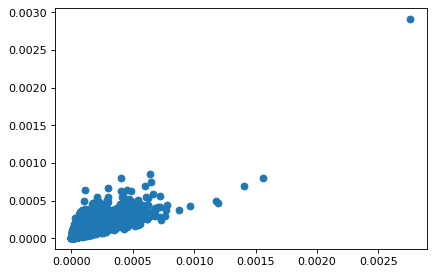

In [809]:
plt.scatter(xx2, xx3)

In [603]:
sibling_genes = list(weight_dict.keys())
g_w_data = [g for g in sibling_genes if g in allen_mouse_genes]
g_w_data2 = [g for g in sibling_genes if g in BGMR.index.values]

In [ ]:
print

In [637]:
print(len(sibling_genes), len(g_w_data), len(g_w_data2))

1357 1236 1194


In [609]:
print(BGMR.loc[g_w_data2, "Mutability"].sum())

0.01624299594428045


In [639]:
Sib_Sim_Dir = "dat/SimulateControlBiasDefault/"
RateDist = []
for file in os.listdir(Sib_Sim_Dir):
    if not file.startswith("cont.genes"):
        continue
    genes = LoadList(Sib_Sim_Dir+file)
    genes = [int(g) for g in genes]
    genes = [g for g in genes if g in BGMR.index.values]
    rate = BGMR.loc[genes, "Mutability"].sum()
    RateDist.append(rate)

No handles with labels found to put in legend.


<AxesSubplot:>

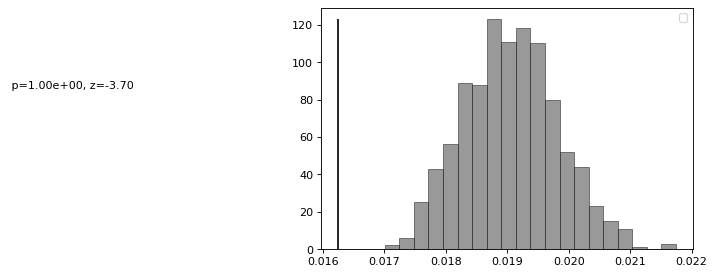

In [640]:
fig, ax = plt.subplots()
PlotPermutationP(RateDist, BGMR.loc[g_w_data2, "Mutability"].sum(), ax)

In [814]:
# Functions
def CI(simulations, p):
    simulations = sorted(simulations, reverse=False)
    n = len(simulations)
    u_pval = (1+p)/2.
    l_pval = (1-u_pval)
    l_indx = int(np.floor(n*l_pval))
    u_indx = int(np.floor(n*u_pval))
    return(simulations[l_indx],simulations[u_indx])

class STRBias:
    def __init__(self, STR, Bias, Rank):
        self.STR = STR
        self.Bias = Bias
        self.Rank = Rank
        self.Boots = []
    def GetCI(self, p):
        return CI(self.Boots, p)

def LoadBiasData(ASD_Bias, ASD_Boot_Dir, match_dir):
    #ASD_Bias = pd.read_csv(ASD_Bias, index_col="STR")
    ASD_STR_Biases = {}
    for STR, row in ASD_Bias.iterrows():
        ASD_STR_Biases[STR] = STRBias(STR, row["EFFECT"], row["Rank"])

    for i in np.arange(1,1000,1):
        try:
            df = pd.read_csv("{}/bootstrap.{}.csv".format(ASD_Boot_Dir,i), index_col="STR")
        except:
            continue
        for STR, row in df.iterrows():
            ASD_STR_Biases[STR].Boots.append(row["EFFECT"])      
            
    biases_match_rank = {}
    biases_match_STR = {}
    for file in os.listdir(match_dir):
        df = pd.read_csv(match_dir+file, index_col="STR")
        for STR, row in df.iterrows():
            if STR not in biases_match_STR:
                biases_match_STR[STR] = []
            biases_match_STR[STR].append(row["EFFECT"])
            if row["Rank"] not in biases_match_rank:
                biases_match_rank[row["Rank"]] = []
            biases_match_rank[row["Rank"]].append(row["EFFECT"])
    return ASD_STR_Biases, biases_match_rank, biases_match_STR

def LoadBiasData2(Real_Bias, Sim_dir):
    #ASD_Bias = pd.read_csv(ASD_Bias, index_col="STR")
    ASD_STR_Biases = {}
    for STR, row in Real_Bias.iterrows():
        ASD_STR_Biases[STR] = STRBias(STR, row["EFFECT"], row["Rank"])     
            
    biases_match_rank = {}
    biases_match_STR = {}
    for file in os.listdir(Sim_dir):
        if file.startswith("cont.genes"):
            continue
        df = pd.read_csv(Sim_dir+file, index_col="STR")
        for STR, row in df.iterrows():
            if STR not in biases_match_STR:
                biases_match_STR[STR] = []
            biases_match_STR[STR].append(row["EFFECT"])
            if row["Rank"] not in biases_match_rank:
                biases_match_rank[row["Rank"]] = []
            biases_match_rank[row["Rank"]].append(row["EFFECT"])
    return ASD_STR_Biases, biases_match_rank, biases_match_STR

def LoadSiblingBias(Sib_Bias, Sib_Boot_Dir):
    Sib_Bias = pd.read_csv(Sib_Bias, index_col="STR")
    Sib_STR_Biases = {}
    for STR, row in Sib_Bias.iterrows():
        Sib_STR_Biases[STR] = STRBias(STR, row["EFFECT"], row["Rank"])
        #print(Sib_STR_Biases[STR].Bias)

    for i in np.arange(1,1001,1):
        df = pd.read_csv("{}/bootstrap.{}.csv".format(Sib_Boot_Dir,i), index_col="STR")
        for STR, row in df.iterrows():
            Sib_STR_Biases[STR].Boots.append(row["EFFECT"])
    return Sib_STR_Biases

def PlotExpBias(ASD_STR_Biases, Sib_STR_Biases, biases_match_rank, 
                title="Structure Expression Bias of ASD vs Match"):
    fig, ax = plt.subplots(figsize=(6, 8), dpi=720)
    for i, (STR, STR_bias) in enumerate(sorted(ASD_STR_Biases.items(), key=lambda x:x[1].Rank)):
        upper, lower = STR_bias.GetCI(0.95)
        ax.hlines(i+1, lower, upper, color = "blue", lw=0.2)
        x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="blue")
        
    #for i, (STR, STR_bias) in enumerate(sorted(Sib_STR_Biases.items(), key=lambda x:x[1].Rank)):
    #    upper, lower = STR_bias.GetCI(0.95)
    #    ax.hlines(i+1, lower, upper, color = "green", lw=0.2)
    #    x2 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="green")
        
    for i, (Rank, data) in enumerate(sorted(biases_match_rank.items(), key=lambda x:x[0])):
        upper, lower = CI(data, 0.95)
        ax.hlines(i+1 -0.3, lower, upper, color = "red", lw=0.2)
        x3 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="red")

    plt.gca().invert_yaxis()
    lgnd = ax.legend([x1, x3], 
                     ["Proband Bias", "Matched Bias"], 
                     prop={'size': 8})
    lgnd.legendHandles[0]._sizes = [30]
    lgnd.legendHandles[1]._sizes = [30]
    #lgnd.legendHandles[2]._sizes = [30]

    plt.title(title)
    plt.xlabel("Expression Bias")
    plt.ylabel("Structure Rank")
    plt.grid(True)
    return plt


### BGMR Bias

In [ ]:
#BGMR_Meta_Spec


### Sibling Mutations

In [564]:
SiblingDF = pd.read_csv("dat/ASD_Siblings.csv")
SiblingDF.head(2)

HGNC  Entrez  N_LGD  N_Mis  N_Dmis  N_Syn
0    ZNF679  168417      0      2       0      0
1  ARHGAP12   94134      0      1       1      0

In [634]:
weight_dict = {}
for index, row in SiblingDF.iterrows():
    weight = row["N_LGD"] * 0.375 + row["N_Dmis"] * 0.231
    if weight >0:
        weight_dict[row["Entrez"]] = weight

In [635]:
writer = csv.writer(open("dat/sibling_weights_LGD_Dmis.csv", 'wt'))
for k,v in sorted(weight_dict.items(), key=lambda x:x[1], reverse=True):
    if k in g_w_data2 and v > 0:
        writer.writerow([k,v])
WeightDF = pd.read_csv("dat/sibling_weights_LGD_Dmis.csv", header=None)
weight_dict = dict(zip(WeightDF[0].values, WeightDF[1].values))

In [647]:
WeightDF = pd.read_csv("dat/sibling_weights_LGD_Dmis.csv", header=None)
weight_dict = dict(zip(WeightDF[0].values, WeightDF[1].values))

In [648]:
#ExpZ2 = pd.read_csv("dat/ExpMat/Energy.ExpZ2.csv", index_col=0)
ExpZ2 = pd.read_csv("dat/z2.all.genes.str.mat.csv", index_col=0)

In [649]:
AvgSTRZ_Weighted(ExpZ2, weight_dict, csv_fil="dat/sib.bias.csv")

STR    EFFECT           REGION  \
0                    Anterior_pretectal_nucleus  0.136741         Midbrain   
1    Posterior_limiting_nucleus_of_the_thalamus  0.128938         Thalamus   
2            Lateral_dorsal_nucleus_of_thalamus  0.125797         Thalamus   
3     Lateral_posterior_nucleus_of_the_thalamus  0.103281         Thalamus   
4                    Nucleus_of_the_optic_tract  0.102876         Midbrain   
..                                          ...       ...              ...   
208          Agranular_insular_area_dorsal_part -0.084711        Isocortex   
209      Nucleus_of_the_lateral_olfactory_tract -0.090006  Olfactory_areas   
210                             Tuberal_nucleus -0.102352     Hypothalamus   
211                               Piriform_area -0.106072  Olfactory_areas   
212                        Retrochiasmatic_area -0.116751     Hypothalamus   

     Rank  
0       1  
1       2  
2       3  
3       4  
4       5  
..    ...  
208   209  
209   210  
210   211  
211   212  
212   213  

[213 rows x 4 columns]

### Denovo Simulation

In [739]:
Sib_Z2_BiasDF = pd.read_csv("dat/bias2/ASD.Siblings.z2.csv", index_col="STR")
Sib_Sim_Dir = "dat/Denovo_Sim/SimulateSibling_Denovo/"
Sib_Z2_Bias, Sib_Sim_Bias_Rank, Sib_Sim_Bias_STR = LoadBiasData2(Sib_Z2_BiasDF, Sib_Sim_Dir)

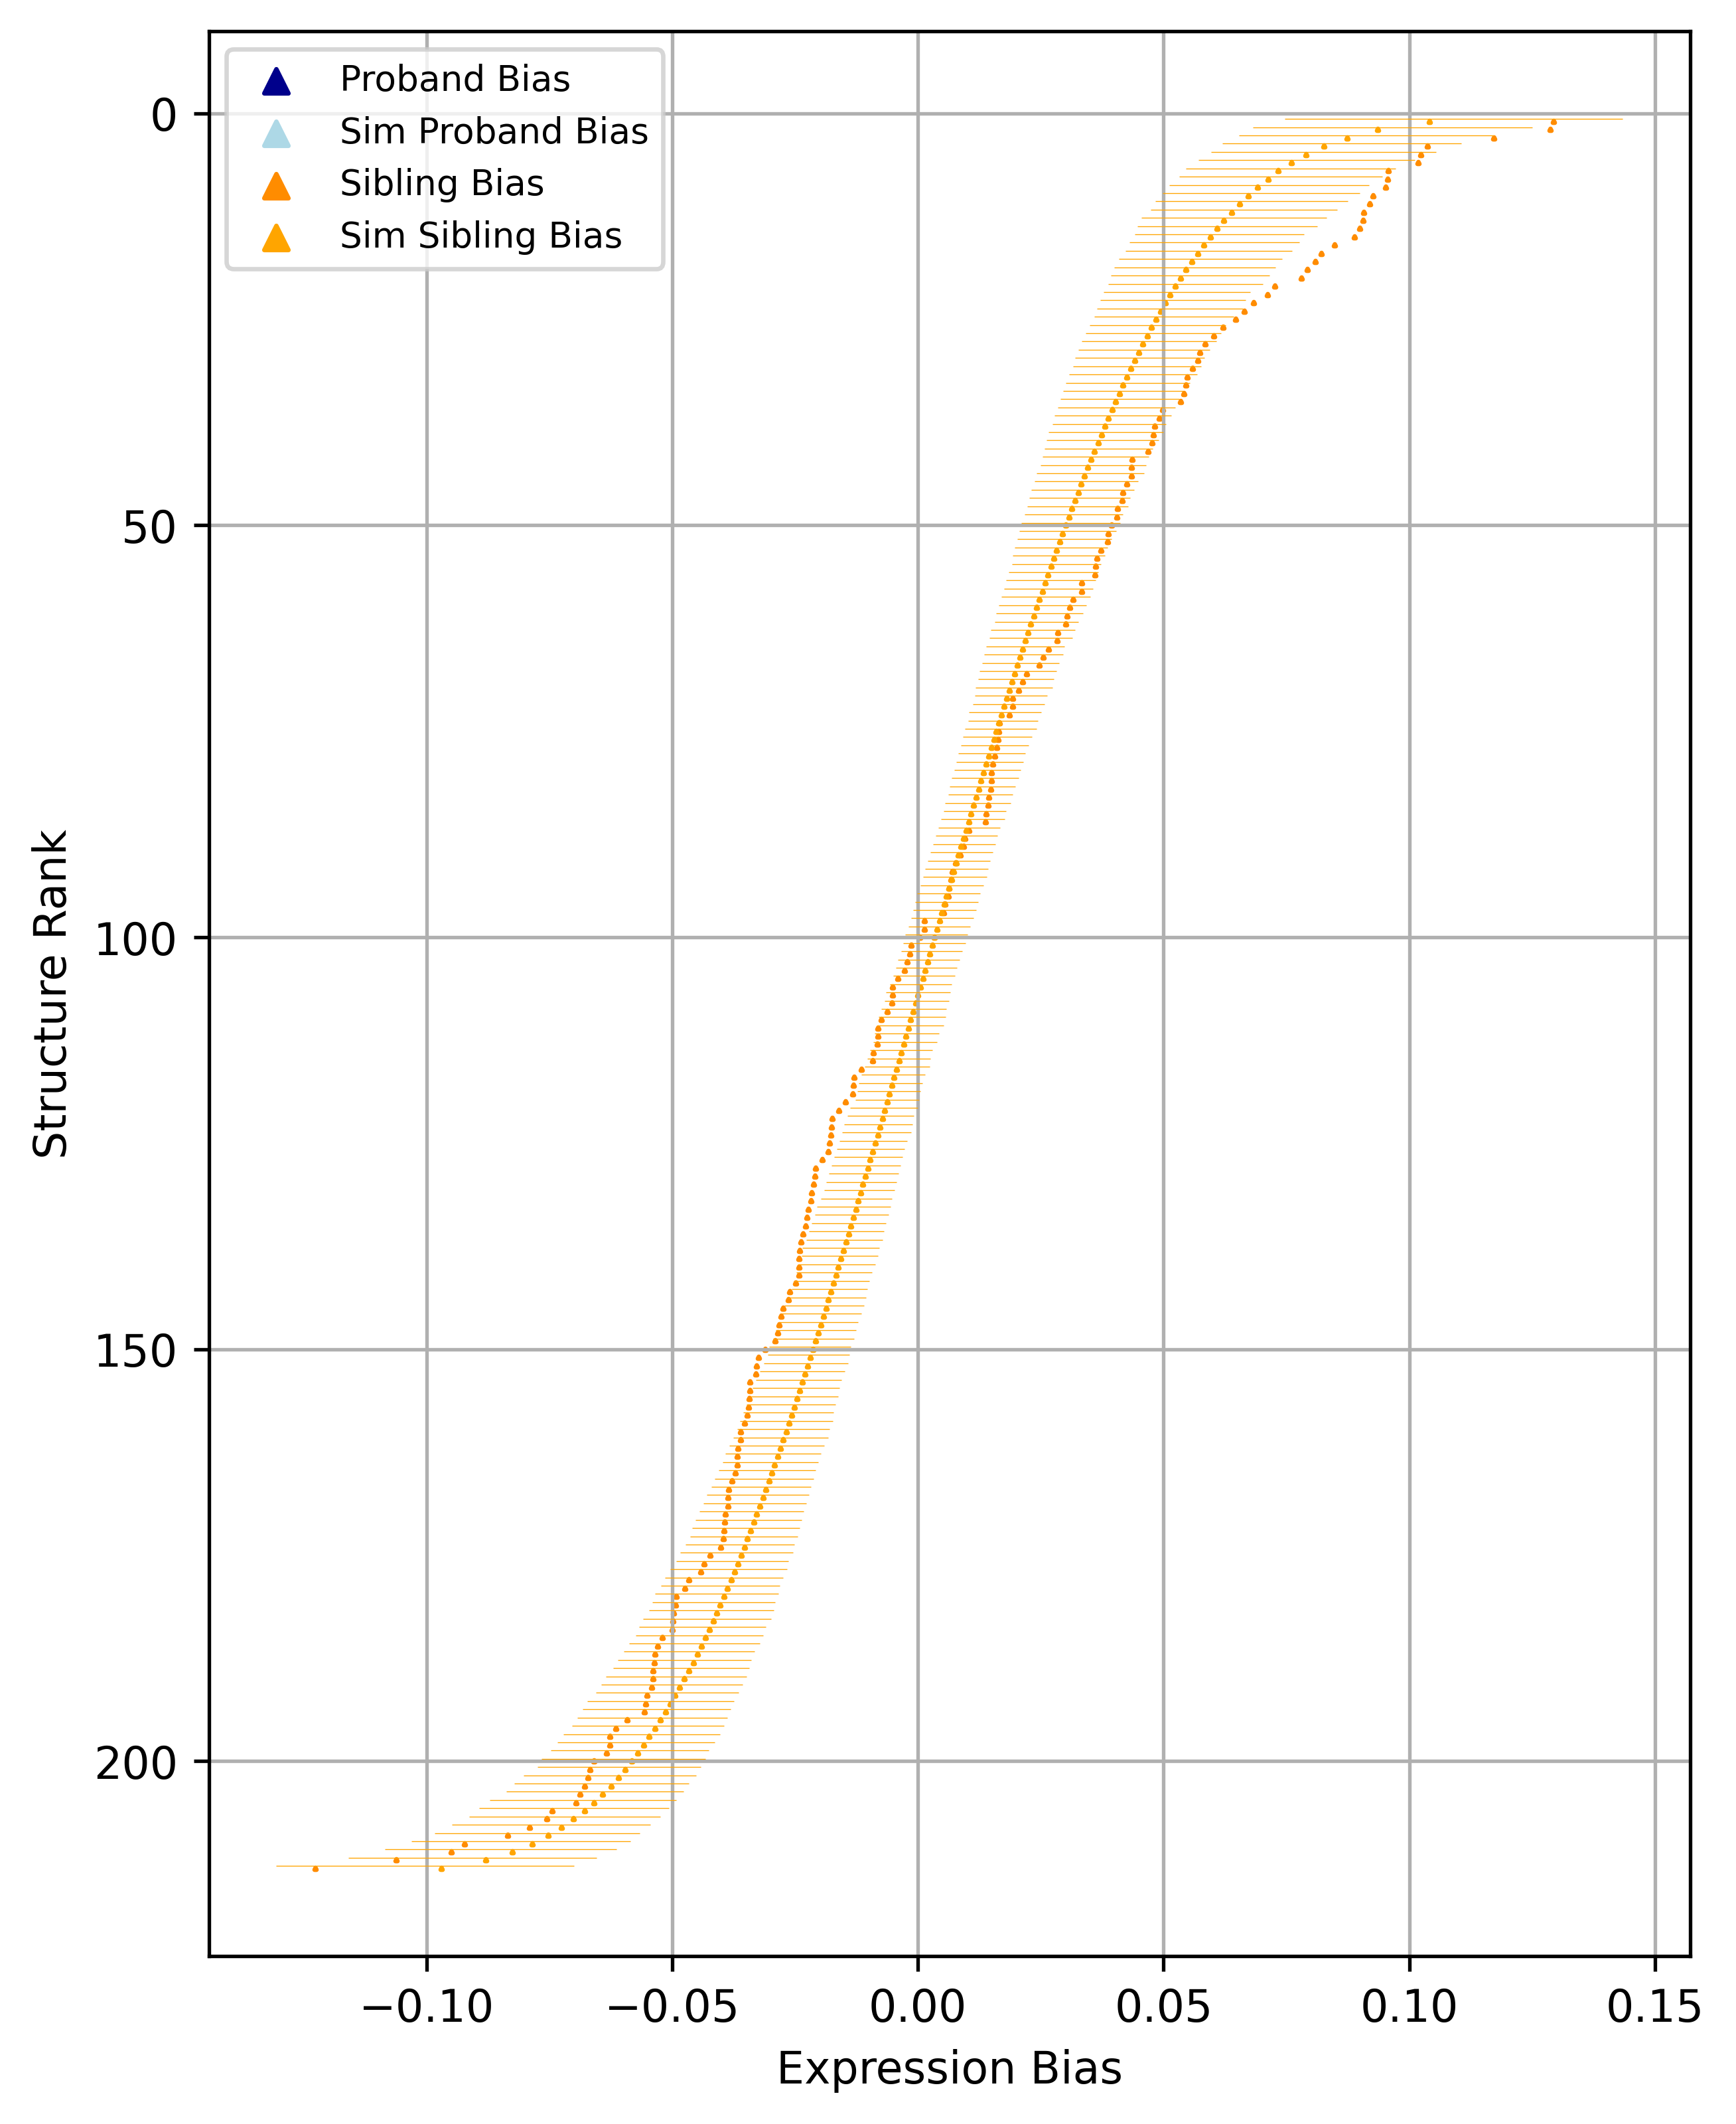

In [740]:
fig, ax = plt.subplots(figsize=(6, 8), dpi=480)

for i, (STR, STR_bias) in enumerate(sorted(Sib_Z2_Bias.items(), key=lambda x:x[1].Rank)):
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="darkorange")
for i, (Rank, data) in enumerate(sorted(Sib_Sim_Bias_Rank.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1 -0.3, lower, upper, color = "orange", lw=0.2)
    x3 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="orange")
    
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x2, x4, x1, x3], 
                 ["Proband Bias", "Sim Proband Bias", "Sibling Bias", "Sim Sibling Bias"], 
                 prop={'size': 8})
#lgnd = ax.legend([x1, x3], 
#                 ["Proband Bias", "Control Bias"], 
#                 prop={'size': 8})
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
#lgnd.legendHandles[2]._sizes = [30]

#plt.title(title)
plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.grid(True)
#return plt

No handles with labels found to put in legend.


<AxesSubplot:>

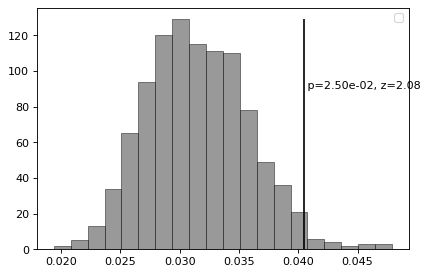

In [741]:
# Sibling bootstraped biases
biases_sib_boot = []
for file in os.listdir(Sib_Sim_Dir):
    df = pd.read_csv(Sib_Sim_Dir+file, index_col="STR")
    biases_sib_boot.append(np.mean([abs(x) for x in df["EFFECT"].values]))
    
bias_sib = np.mean([abs(x) for x in Sib_Z2_BiasDF["EFFECT"].values])

fig, ax = plt.subplots()
PlotPermutationP(biases_sib_boot, bias_sib, ax)

### Anlyze sibling mutations

In [743]:
complete_sibling_biasDF = pd.read_csv("dat/bias2/ASD.Siblings.z2.csv", index_col="STR")
complete_sibling_noweight_biasDF = pd.read_csv("dat/sib.bias.noweight.csv", index_col="STR")

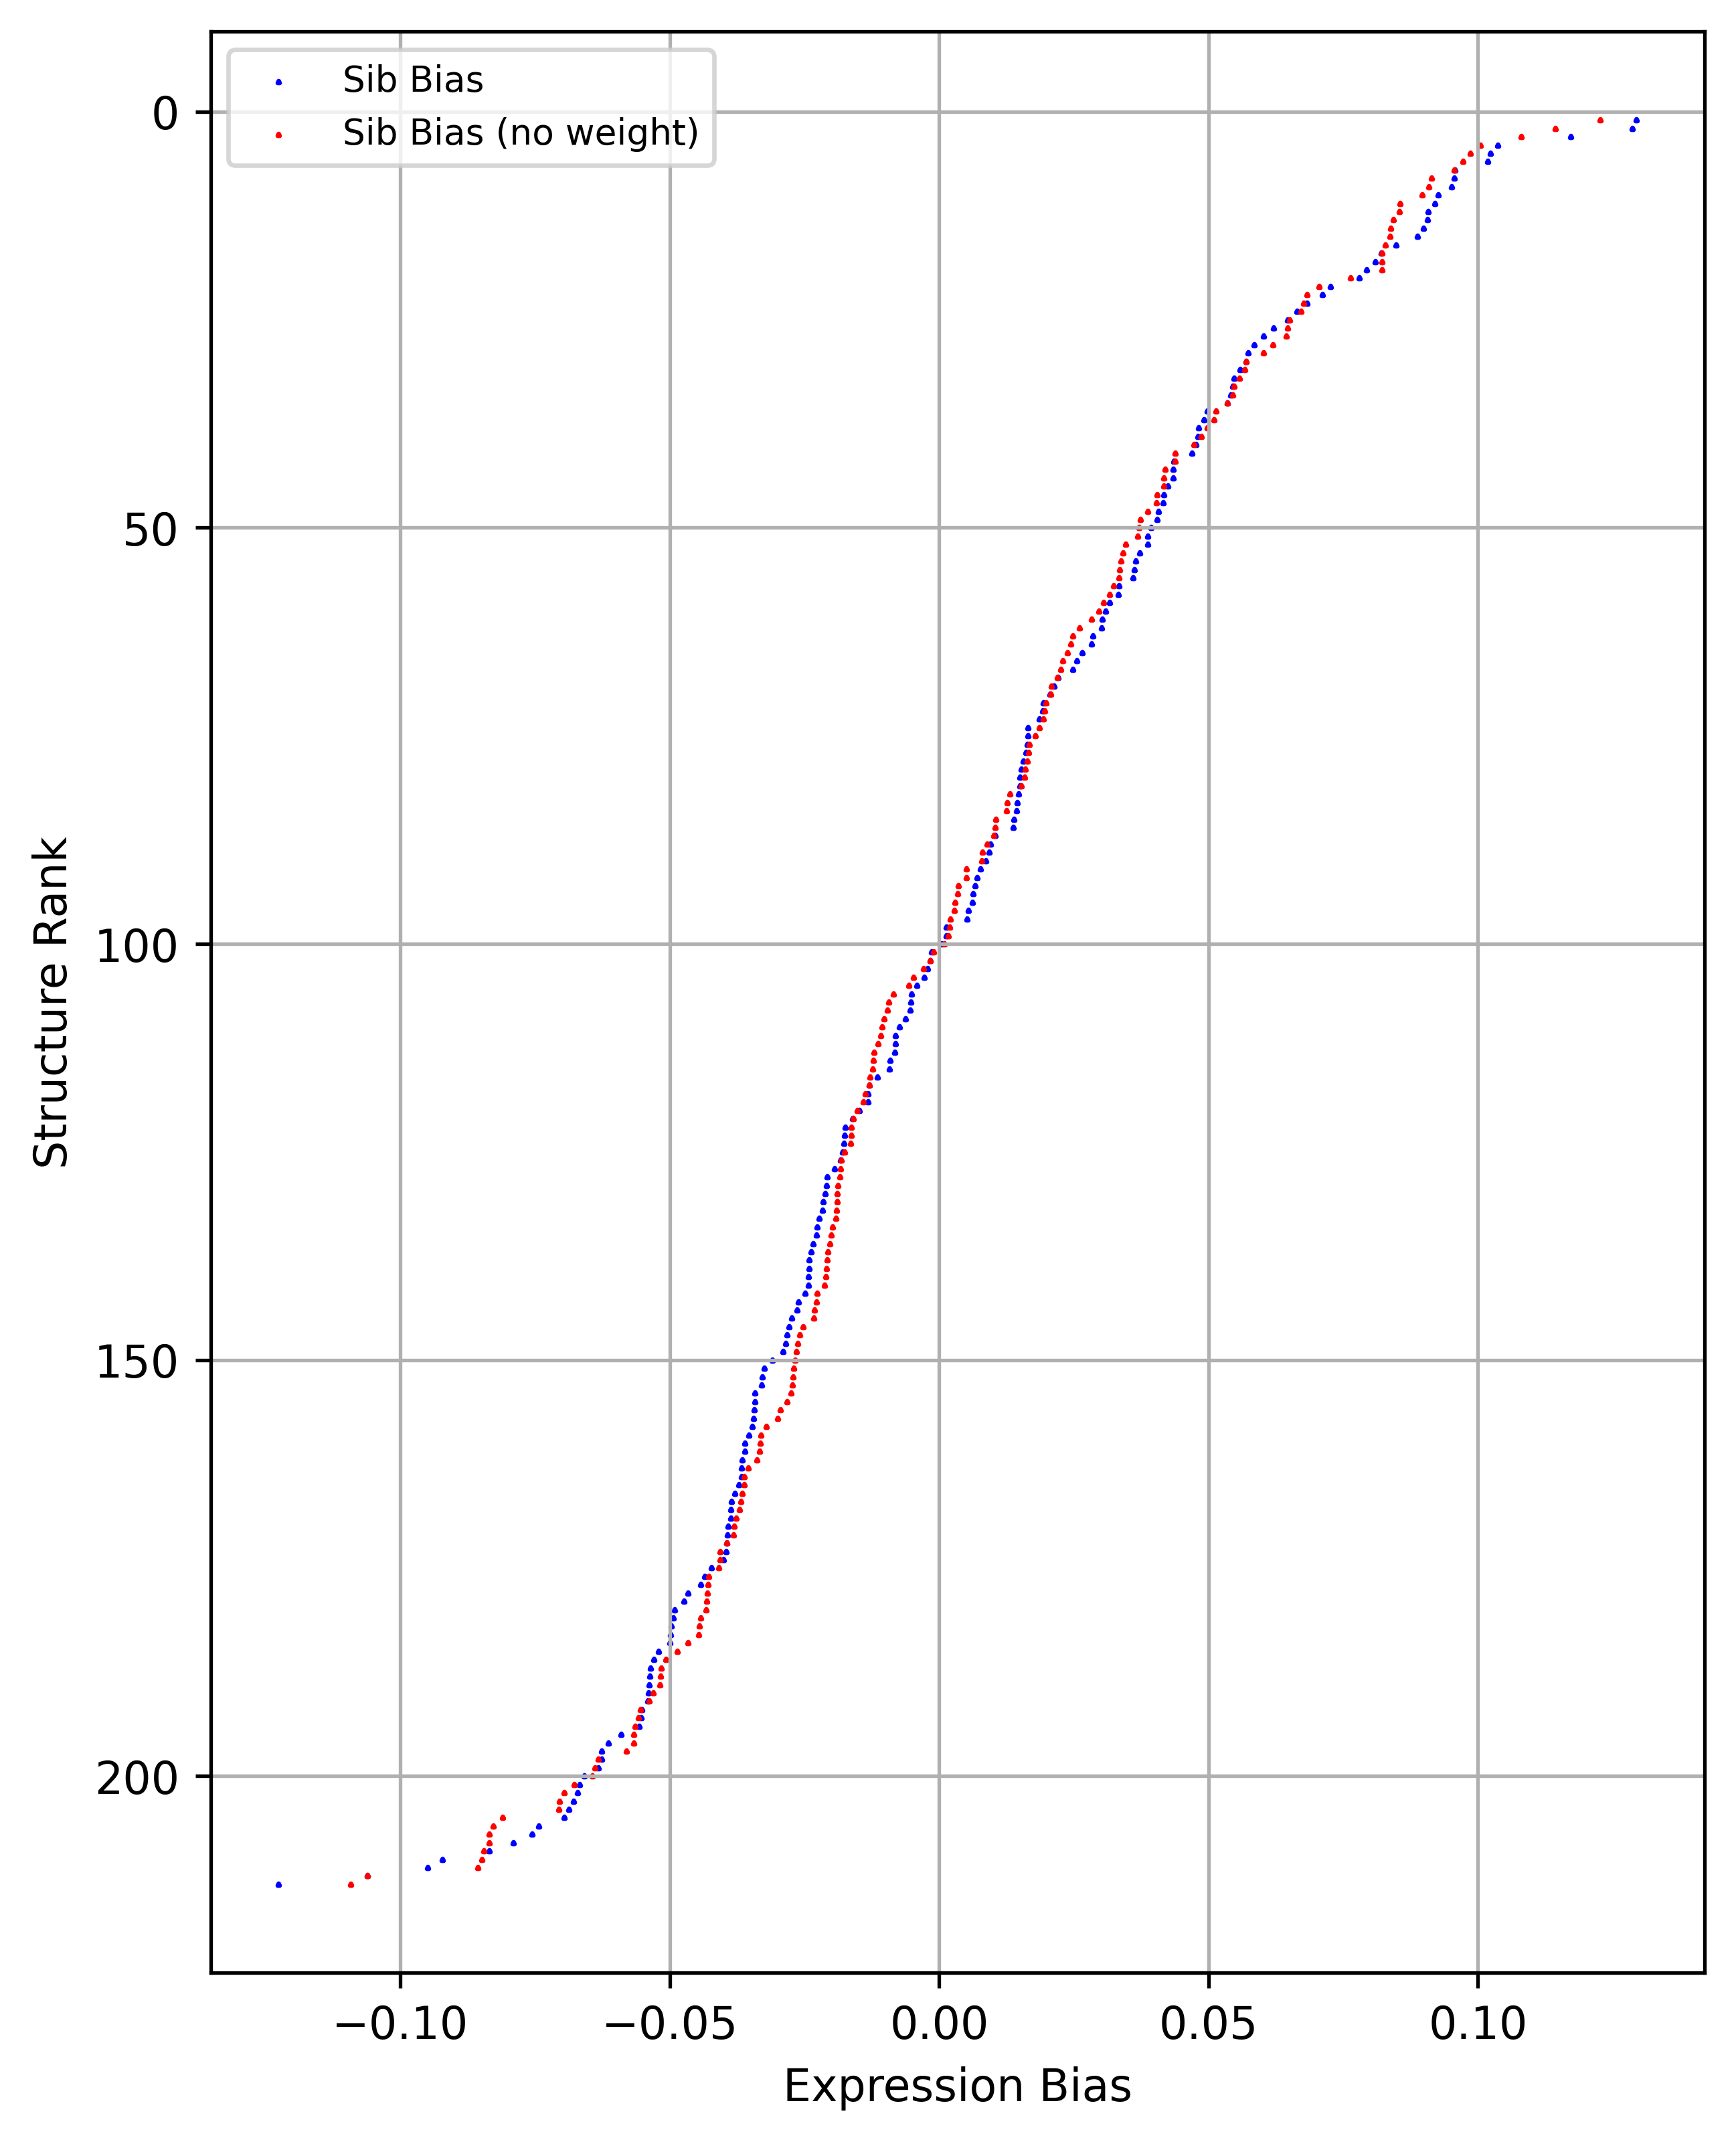

In [748]:
fig, ax = plt.subplots(figsize=(6, 8), dpi=480)

for i, (id, row) in enumerate(complete_sibling_biasDF.iterrows()):
    x1 = ax.scatter(row['EFFECT'], i+1, marker="^", s=0.2, color="blue")
    
for i, (id, row) in enumerate(complete_sibling_noweight_biasDF.iterrows()):
    x2 = ax.scatter(row['EFFECT'], i+1, marker="^", s=0.2, color="red")

plt.gca().invert_yaxis()
lgnd = ax.legend([x1, x2, ], 
                 ["Sib Bias", "Sib Bias (no weight)", ], 
                 prop={'size': 8})
plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.grid(True)
#return plt

In [761]:
def avg_indv_bias(sub_bias_mat, topN=10):
    res = []
    for g, row in sub_bias_mat.iterrows():
        row = [x for x in row if x==x]
        sorted_row = sorted(row, reverse=True)
        res.append(np.mean(sorted_row[:topN]))
    return np.mean(res)

In [763]:
Dir = "dat/SimulateSibling_Plain_Weight/"
sim_avg_bias = []
for file in os.listdir(Dir):
    if file.startswith("cont.genes"):
        sib_genes = [int(x) for x in LoadList(Dir + file) if int(x) in ExpZ2.index.values]
        #print(sib_genes[:5])
        indv_bias = ExpZ2.loc[sib_genes, :]
        sim_avg_bias.append(avg_indv_bias(indv_bias))

In [764]:
#weight_dict = dict(zip(WeightDF[0].values, [1] * len(WeightDF[1].values)))
#AvgSTRZ_Weighted(ExpZ2, weight_dict, csv_fil="dat/sib.bias.noweight.csv")
sib_real_genes = list(weight_dict.keys())
sib_real_expbias = ExpZ2.loc[sib_real_genes, :]
mean_sib_bias = avg_indv_bias(sib_real_expbias)
print(mean_sib_bias)

2.4831515873034804


<AxesSubplot:title={'center':'avg individual top10 bias'}, xlabel='real sib'>

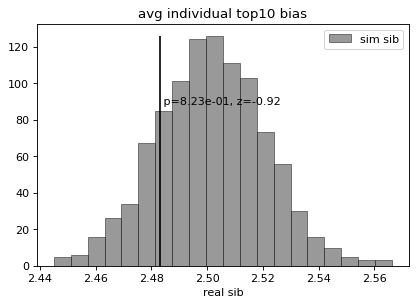

In [767]:
fig, ax = plt.subplots()
PlotPermutationP(sim_avg_bias, mean_sib_bias, ax, xlabel="real sib", dist_label="sim sib", title=
                "avg individual top10 bias")

In [817]:
SiblingDF = pd.read_csv("dat/ASD_Siblings.csv")
SynSibDF = SiblingDF[SiblingDF["N_Syn"]>=1]
Syn_weights = dict(zip(SynSibDF["Entrez"].values, SynSibDF["N_Syn"].values))
print(len(Syn_weights))
Sib_syn_bias = AvgSTRZ_Weighted(ExpZ2, Syn_weights, csv_fil="dat/sib.syn.bias.csv")
Sib_syn_bias = Sib_syn_bias.set_index("STR")

1597


In [821]:
BGMR.index.values

array([ 64109,   1438, 207063, ...,    410,  85358,     49])

In [822]:
writer = csv.writer(open("dat/sibling_weights_syn.csv", 'wt'))
for k,v in sorted(Syn_weights.items(), key=lambda x:x[1], reverse=True):
    if k in BGMR.index.values and v > 0:
        writer.writerow([k,v])
WeightDF = pd.read_csv("dat/sibling_weights_syn.csv", header=None)
Syn_weights2 = dict(zip(WeightDF[0].values, WeightDF[1].values))

In [823]:
Sib_syn_bias = AvgSTRZ_Weighted(ExpZ2, Syn_weights2, csv_fil="dat/sib.syn.2.bias.csv")
Sib_syn_bias = Sib_syn_bias.set_index("STR")
Sib_syn_bias.head(50)["EFFECT"].mean()

0.05768111622553025

In [830]:
# Check Number of genes
def reduceMut(DF):
    genes = DF.index.values
    Total_LGD_Mis = []
    Total_SYN = []
    for i, row in DF.iterrows():
        N_LGD_Mis = 0
        N_Syn = 0
        for index, value in row.items():
            N_lgd, N_dmis, N_syn = map(int, value.split(","))
            if N_lgd + N_dmis > 0:
                N_LGD_Mis += 1
            if N_syn > 0:
                N_Syn += 1
            Total_LGD_Mis.append(N_LGD_Mis)
            Total_SYN.append(N_Syn)
    return Total_LGD_Mis, Total_SYN

biases_sib_boot = []
Sib_Sim_Dir = "dat/Denovo_Sim/"
N_LGD_Dmis_genes = []
N_Syn_Genes = []
for file in os.listdir(Sib_Sim_Dir):
    if file.startswith("sib_denovo_simulations"):
        df = pd.read_csv(Sib_Sim_Dir+file, index_col=0)
        tmp1, tmp2 = reduceMut(df)
        N_LGD_Dmis_genes.extend(tmp1)
        N_Syn_Genes.extend(tmp2)

In [831]:
print(np.mean(N_LGD_Dmis_genes))
print(np.mean(N_Syn_Genes))

659.1207322718141
772.7825215154477


No handles with labels found to put in legend.


<AxesSubplot:>

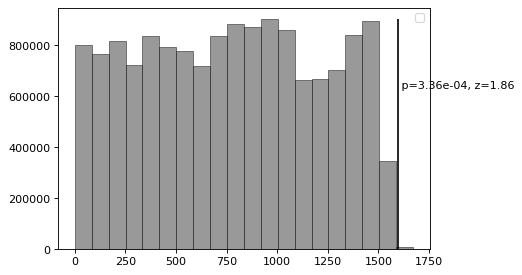

In [832]:
fig, ax = plt.subplots()
PlotPermutationP(N_Syn_Genes, len(Syn_weights), ax)

In [833]:
Sib_Sim_Dir = "dat/Denovo_Sim/DNV_Sib_Syn/"
Sib_Z2_Bias, Sib_Sim_Bias_Rank, Sib_Sim_Bias_STR = LoadBiasData2(Sib_syn_bias, Sib_Sim_Dir)

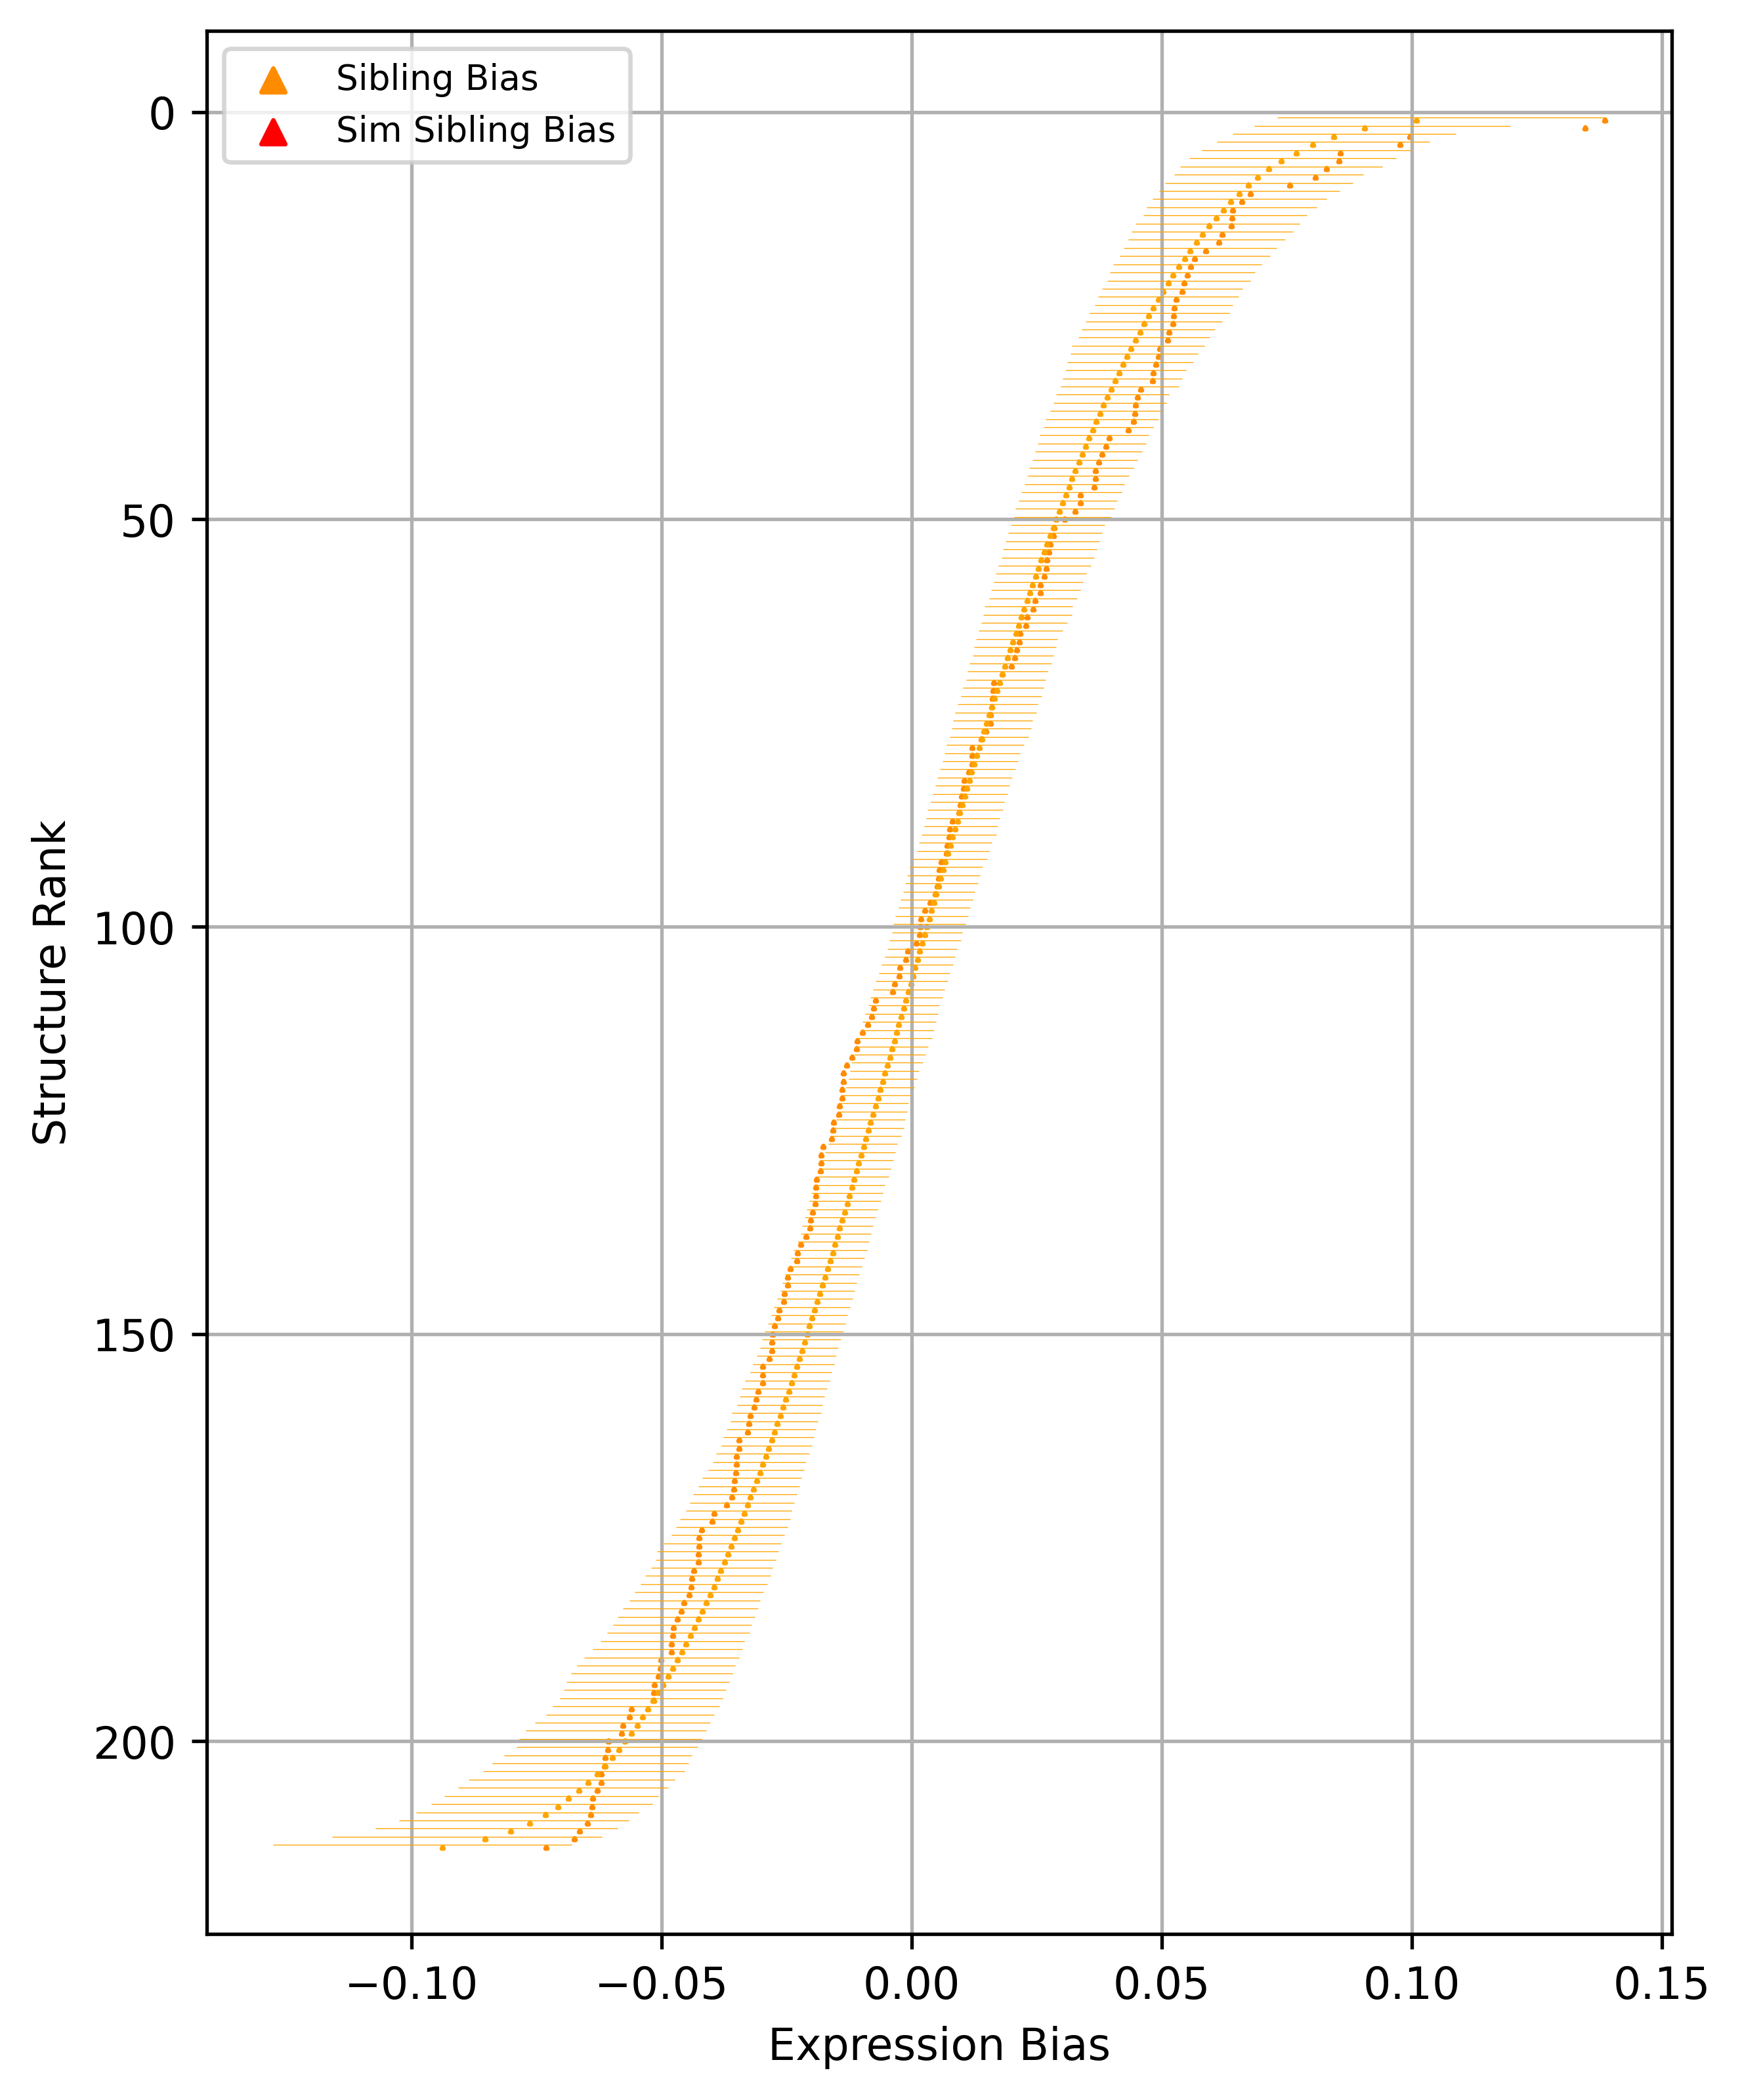

In [834]:
fig, ax = plt.subplots(figsize=(6, 8), dpi=480)

for i, (STR, STR_bias) in enumerate(sorted(Sib_Z2_Bias.items(), key=lambda x:x[1].Rank)):
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="darkorange")
for i, (Rank, data) in enumerate(sorted(Sib_Sim_Bias_Rank.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1 -0.3, lower, upper, color = "orange", lw=0.2)
    x3 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="orange")
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x1, x2], 
                 ["Sibling Bias", "Sim Sibling Bias"], 
                 prop={'size': 8})

lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]


plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.grid(True)

In [824]:
#Sib_Sim_Dir = "dat/Denovo_Sim/SimSib_0124/DNV_Sib_Syn/"
Sib_Sim_Dir = "dat/Control_GeneSet_Bias/Rand_Gene_Syn_Sib/"
Sib_Z2_Bias, Sib_Sim_Bias_Rank, Sib_Sim_Bias_STR = LoadBiasData2(Sib_syn_bias, Sib_Sim_Dir)

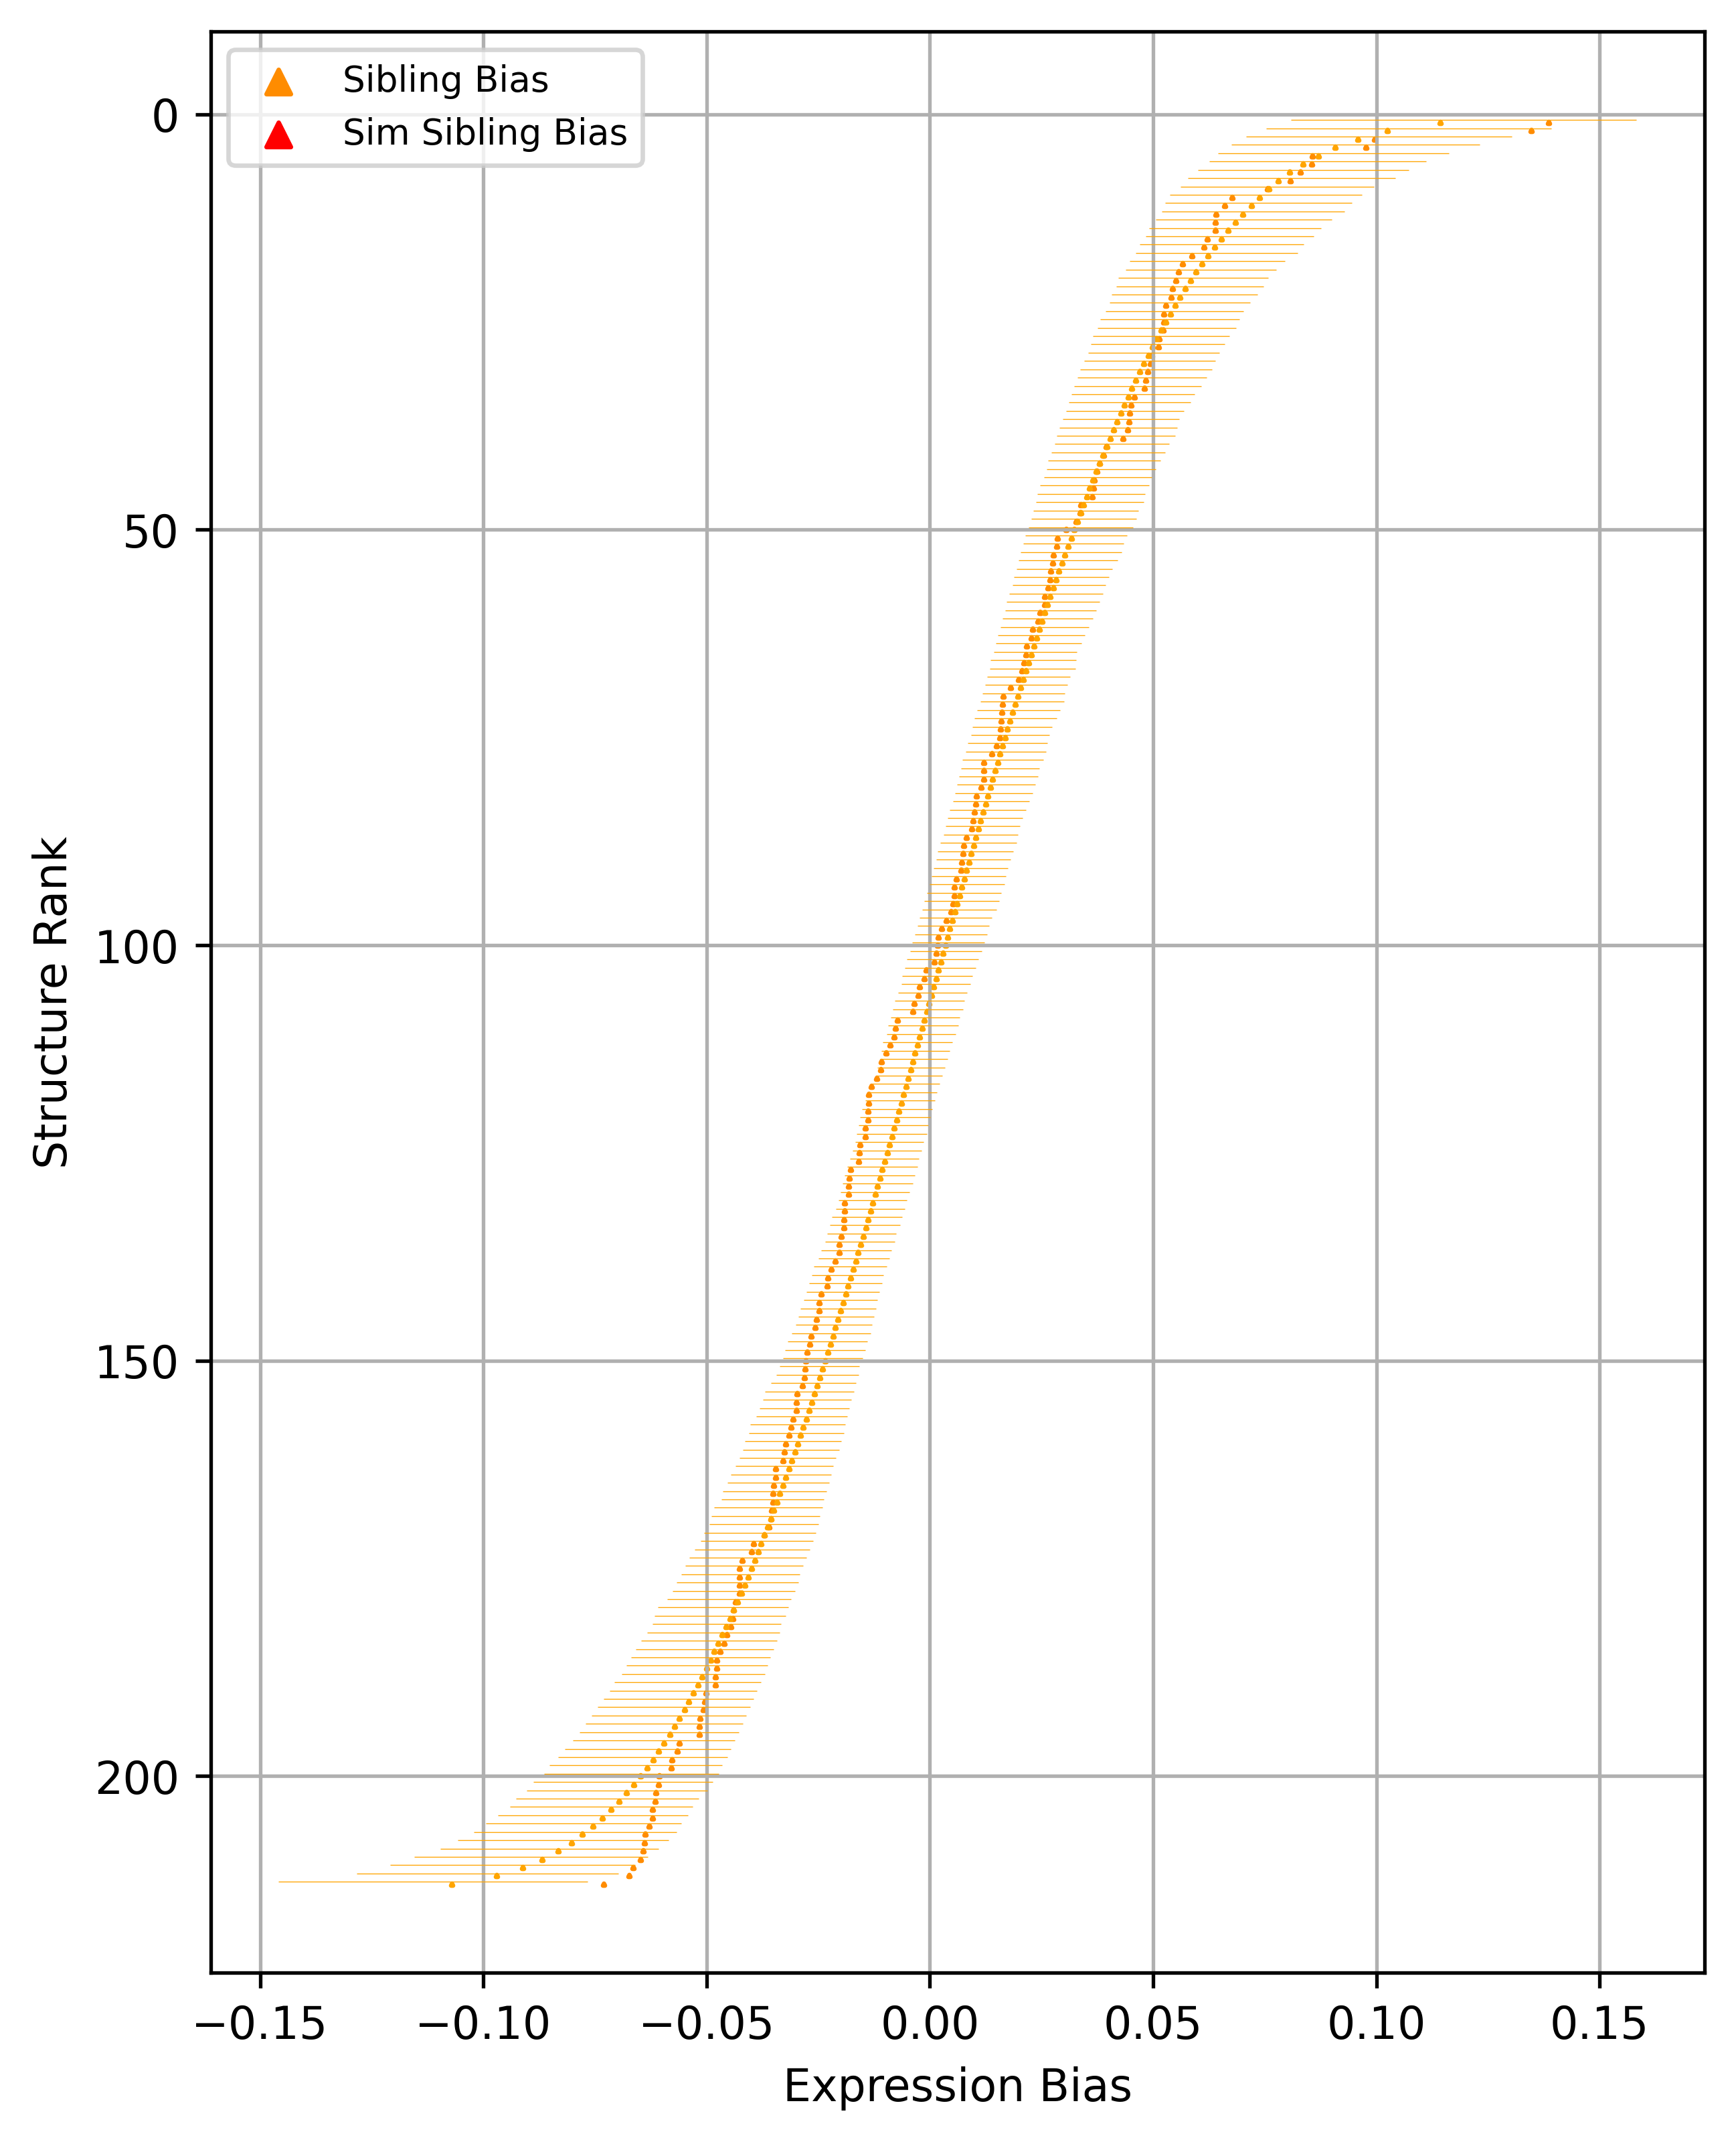

In [825]:
fig, ax = plt.subplots(figsize=(6, 8), dpi=480)

for i, (STR, STR_bias) in enumerate(sorted(Sib_Z2_Bias.items(), key=lambda x:x[1].Rank)):
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="darkorange")
for i, (Rank, data) in enumerate(sorted(Sib_Sim_Bias_Rank.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1 -0.3, lower, upper, color = "orange", lw=0.2)
    x3 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="orange")
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x1, x2], 
                 ["Sibling Bias", "Sim Sibling Bias"], 
                 prop={'size': 8})

lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]


plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.grid(True)

In [650]:
#ASD.Siblings.z2.csv
#Sib_Z2_Bias = pd.read_csv("dat/bias2/ASD.Siblings.z2.csv", index_col="STR")
###Sib_Z2_Bias = pd.read_csv("dat/sib.bias.csv", index_col="STR")
#Sib_Sim_Dir = "dat/bias2/DNV_SM_Sib_Z2/"
#Sib_Z2_Bias, Sib_Sim_Bias_Rank, Sib_Sim_Bias_STR = LoadBiasData2(Sib_Z2_Bias, Sib_Sim_Dir)

In [657]:
Sib_Z2_BiasDF = pd.read_csv("dat/sib.bias.csv", index_col="STR")
Sib_Sim_Dir = "dat/SimulateControlBiasDefault/"
Sib_Z2_Bias, Sib_Sim_Bias_Rank, Sib_Sim_Bias_STR = LoadBiasData2(Sib_Z2_Bias, Sib_Sim_Dir)

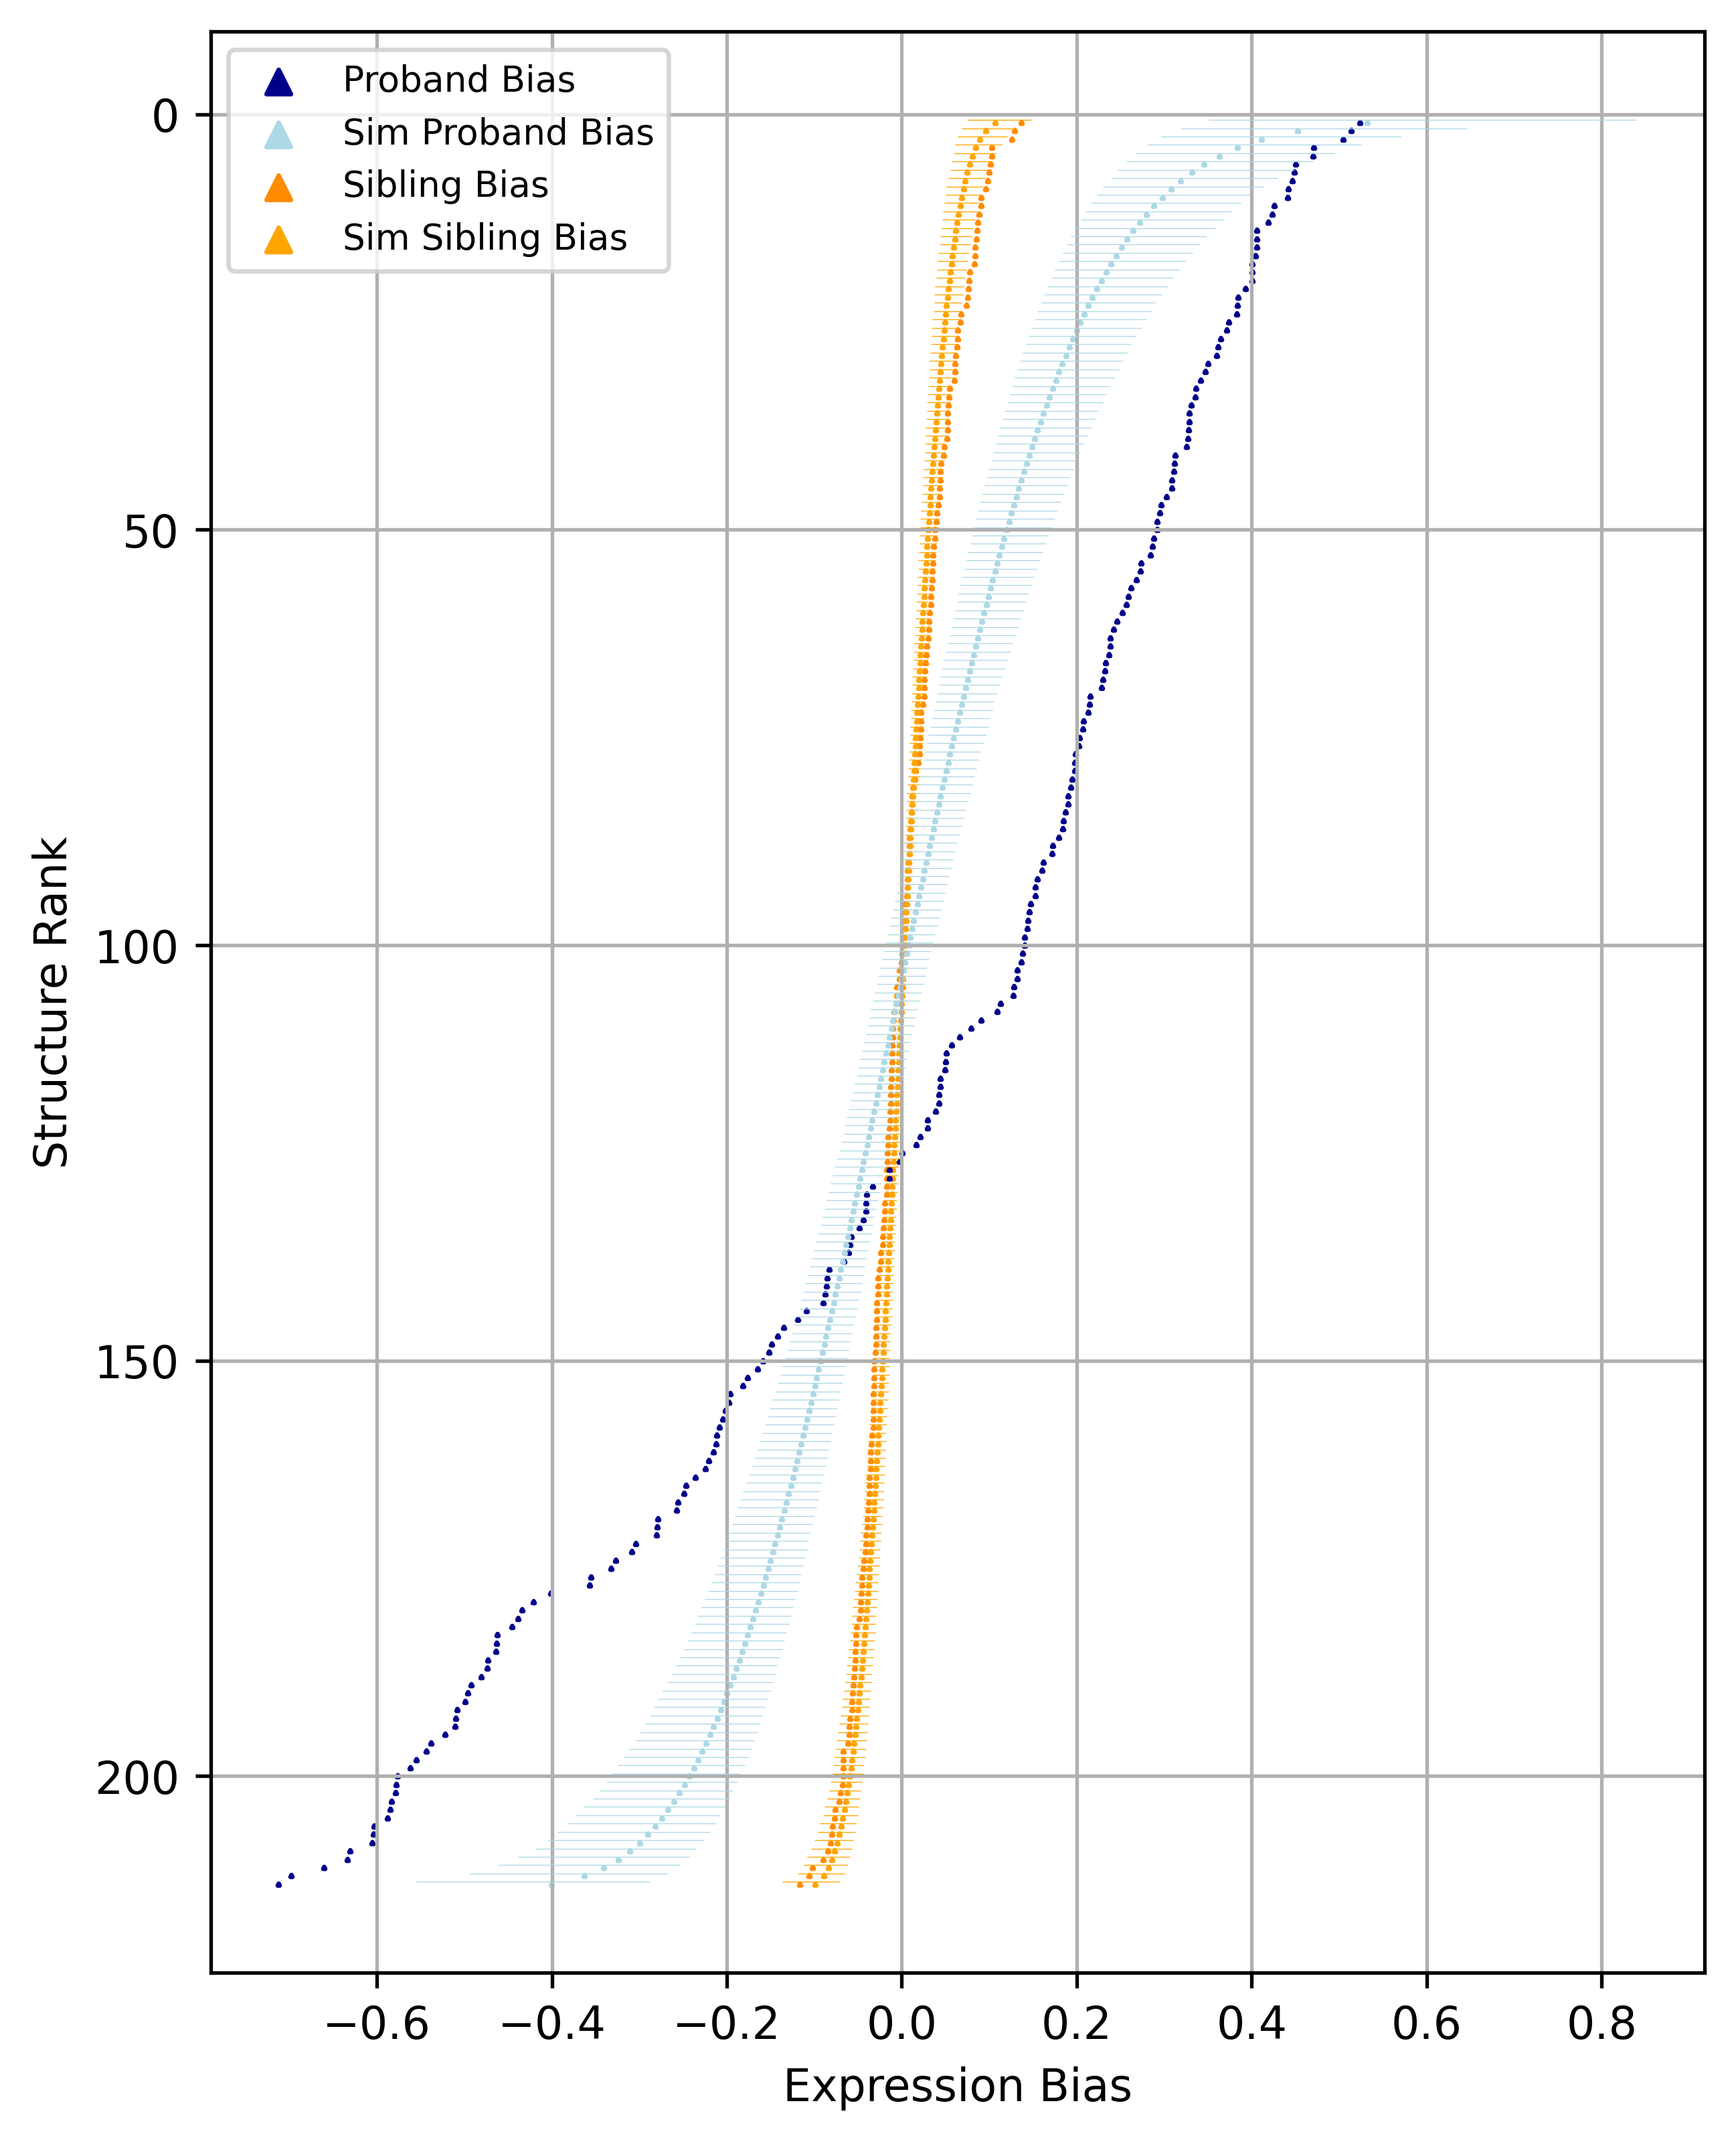

In [652]:
fig, ax = plt.subplots(figsize=(6, 8), dpi=480)

for i, (STR, STR_bias) in enumerate(sorted(Sib_Z2_Bias.items(), key=lambda x:x[1].Rank)):
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="darkorange")
for i, (Rank, data) in enumerate(sorted(Sib_Sim_Bias_Rank.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1 -0.3, lower, upper, color = "orange", lw=0.2)
    x3 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="orange")

#plt = PlotExpBias(_Z2_Bias, _Z2_Bias, _Z2_Match_Bias_Rank, "Z2")
for i, (STR, STR_bias) in enumerate(sorted(_Z2_Bias.items(), key=lambda x:x[1].Rank)):
    x2 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="darkblue")
for i, (Rank, data) in enumerate(sorted(_Z2_Match_Bias_Rank.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1 -0.3, lower, upper, color = "lightblue", lw=0.2)
    x4 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="lightblue")
    
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x2, x4, x1, x3], 
                 ["Proband Bias", "Sim Proband Bias", "Sibling Bias", "Sim Sibling Bias"], 
                 prop={'size': 8})
#lgnd = ax.legend([x1, x3], 
#                 ["Proband Bias", "Control Bias"], 
#                 prop={'size': 8})
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
#lgnd.legendHandles[2]._sizes = [30]

#plt.title(title)
plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.grid(True)
#return plt

In [658]:
# Sibling bootstraped biases
biases_sib_boot = []
sib_boot_dir = "dat/asd.sib.boot.bias/"
for file in os.listdir(Sib_Sim_Dir):
    if not file.startswith("cont.bias"):
        continue
    df = pd.read_csv(Sib_Sim_Dir+file, index_col="STR")
    biases_sib_boot.append(np.mean([abs(x) for x in df["EFFECT"].values]))
    
bias_sib = np.mean([abs(x) for x in Sib_Z2_BiasDF["EFFECT"].values])

fig, ax = plt.subplots()
Sib_Z2_Bias = pd.read_csv("dat/sib.bias.csv", index_col="STR")
PlotPermutationP(biases_sib_boot, bias_sib, ax)

No handles with labels found to put in legend.


<AxesSubplot:>

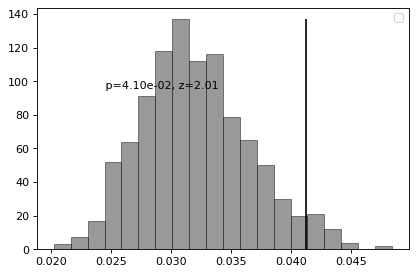

In [659]:
fig, ax = plt.subplots()
Sib_Z2_Bias = pd.read_csv("dat/sib.bias.csv", index_col="STR")
PlotPermutationP(biases_sib_boot, bias_sib, ax)

In [ ]:
0.04

### pLAIN WEIGHT sIBLING

In [742]:
weight_dict = dict(zip(WeightDF[0].values, [1] * len(WeightDF[1].values)))
AvgSTRZ_Weighted(ExpZ2, weight_dict, csv_fil="dat/sib.bias.noweight.csv")

STR    EFFECT  \
0                  Lateral_dorsal_nucleus_of_thalamus  0.122657   
1                          Anterior_pretectal_nucleus  0.114402   
2          Posterior_limiting_nucleus_of_the_thalamus  0.107968   
3    Ventral_anterior_lateral_complex_of_the_thalamus  0.100438   
4            Intermediodorsal_nucleus_of_the_thalamus  0.098640   
..                                                ...       ...   
208                          Medial_amygdalar_nucleus -0.084515   
209                                   Tuberal_nucleus -0.084930   
210                Agranular_insular_area_dorsal_part -0.085589   
211                                     Piriform_area -0.106182   
212                              Retrochiasmatic_area -0.109238   

              REGION  Rank  
0           Thalamus     1  
1           Midbrain     2  
2           Thalamus     3  
3           Thalamus     4  
4           Thalamus     5  
..               ...   ...  
208        Amygdalar   209  
209     Hypothalamus   210  
210        Isocortex   211  
211  Olfactory_areas   212  
212     Hypothalamus   213  

[213 rows x 4 columns]

In [728]:
print(len(weight_dict))

1194


In [729]:
Sib_Z2_BiasDF = pd.read_csv("dat/sib.bias.csv", index_col="STR")
Sib_Sim_Dir = "dat/SimulateSibling_Plain_Weight/"
Sib_Z2_Bias, Sib_Sim_Bias_Rank, Sib_Sim_Bias_STR = LoadBiasData2(Sib_Z2_BiasDF, Sib_Sim_Dir)

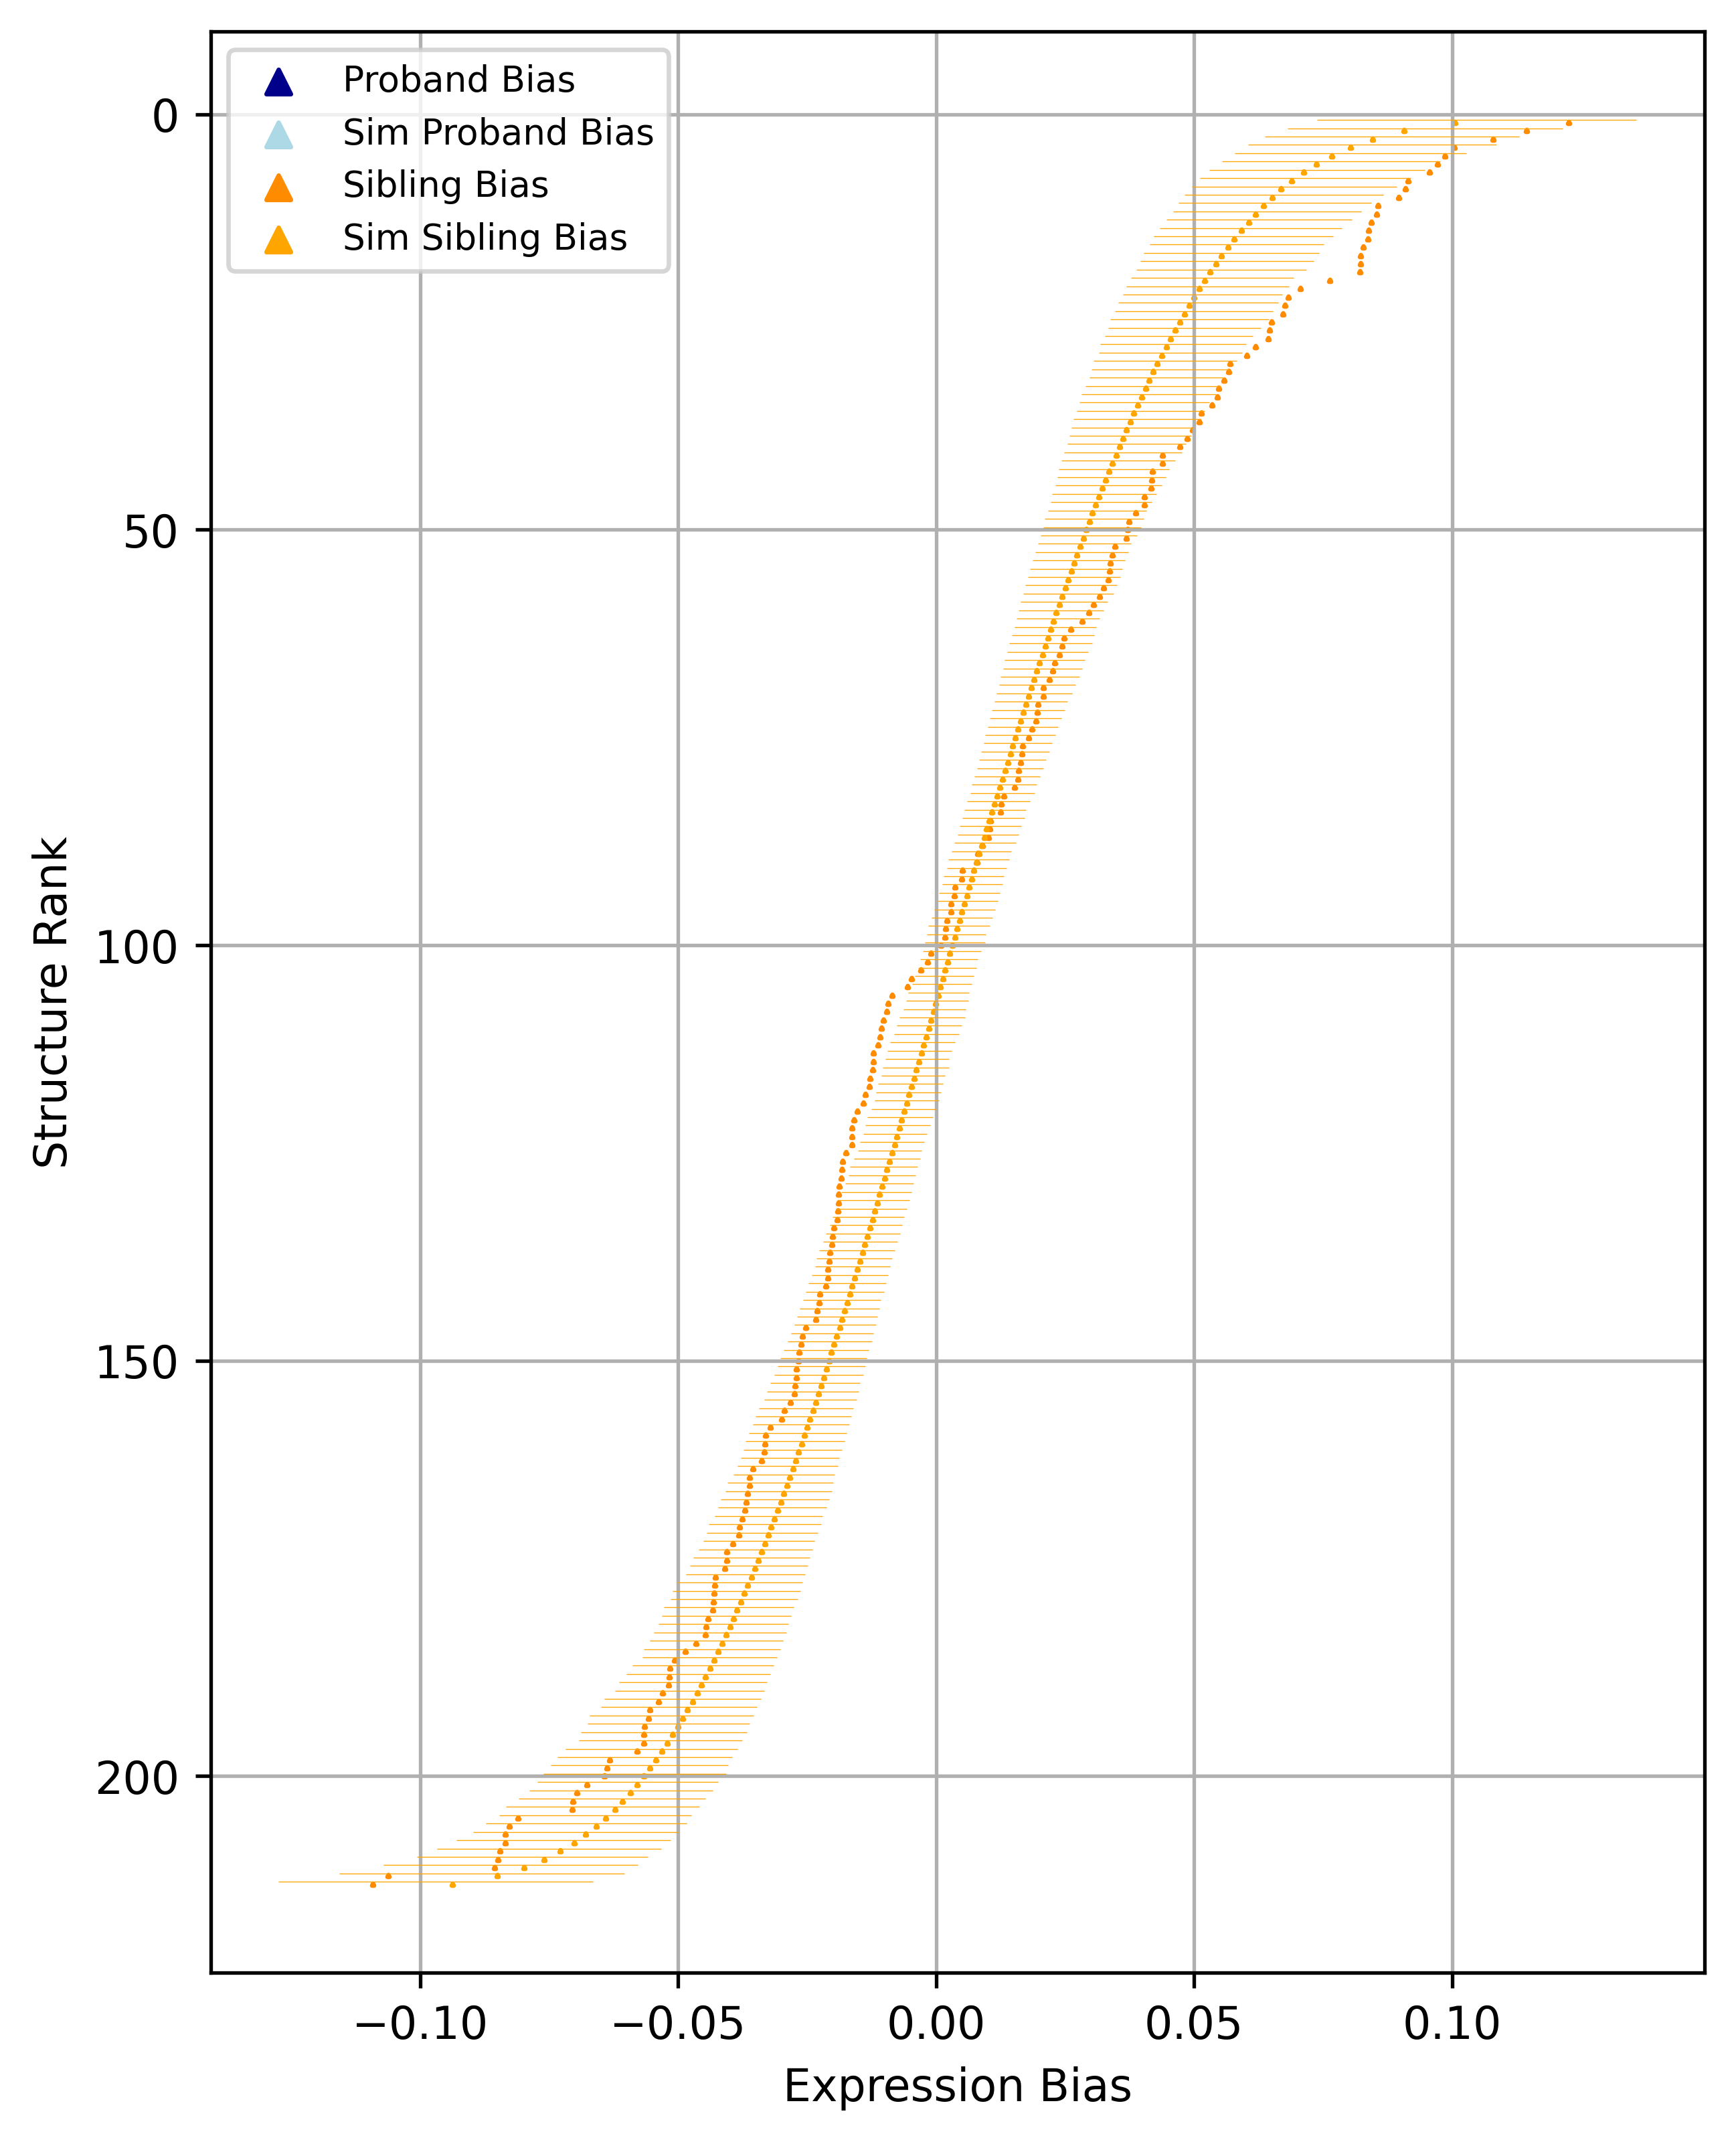

In [730]:
fig, ax = plt.subplots(figsize=(6, 8), dpi=480)

for i, (STR, STR_bias) in enumerate(sorted(Sib_Z2_Bias.items(), key=lambda x:x[1].Rank)):
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="darkorange")
for i, (Rank, data) in enumerate(sorted(Sib_Sim_Bias_Rank.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1 -0.3, lower, upper, color = "orange", lw=0.2)
    x3 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="orange")
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x2, x4, x1, x3], 
                 ["Proband Bias", "Sim Proband Bias", "Sibling Bias", "Sim Sibling Bias"], 
                 prop={'size': 8})

lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
#lgnd.legendHandles[2]._sizes = [30]

#plt.title(title)
plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.grid(True)
#return plt

In [731]:
for STR, row in Sib_Z2_BiasDF.iterrows():
    #mat_bias = getBiasesBySTR(STR, match_dfs)
    mat_bias = Sib_Sim_Bias_STR[STR]
    Z, P = GetPermutationP(mat_bias, row["EFFECT"])
    print("%d %s %.3f %.3f" % (row["Rank"], STR, row["EFFECT"], P))
    Z2_Bias.loc[STR, "Z3"] = Z
    Z2_Bias.loc[STR, "Pvalue"] = P

1 Lateral_dorsal_nucleus_of_thalamus 0.123 0.001
2 Anterior_pretectal_nucleus 0.114 0.013
3 Posterior_limiting_nucleus_of_the_thalamus 0.108 0.009
4 Ventral_anterior_lateral_complex_of_the_thalamus 0.100 0.005
5 Intermediodorsal_nucleus_of_the_thalamus 0.099 0.032
6 Rhomboid_nucleus 0.097 0.017
7 Lateral_posterior_nucleus_of_the_thalamus 0.096 0.041
8 Superior_central_nucleus_raphe 0.091 0.010
9 Nucleus_of_the_optic_tract 0.091 0.015
10 Nucleus_incertus 0.090 0.008
11 Paraventricular_nucleus_of_the_thalamus 0.086 0.130
12 Medial_geniculate_complex_dorsal_part 0.085 0.074
13 Ventral_posterolateral_nucleus_of_the_thalamus 0.084 0.008
14 Medial_geniculate_complex_medial_part 0.084 0.046
15 Lateral_septal_nucleus_rostral_rostroventral_part 0.084 0.171
16 Subparafascicular_area 0.083 0.154
17 Nucleus_of_reuniens 0.082 0.038
18 Parataenial_nucleus 0.082 0.100
19 Central_medial_nucleus_of_the_thalamus 0.082 0.077
20 Paraventricular_hypothalamic_nucleus 0.076 0.046
21 Lateral_habenula 0.071 0.

No handles with labels found to put in legend.


<AxesSubplot:>

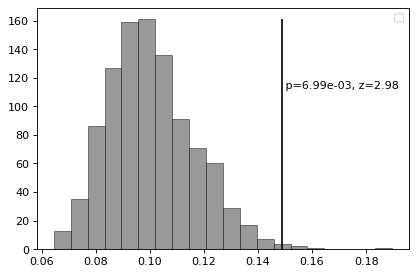

In [734]:
# Sibling bootstraped biases
biases_sib_boot = []
for file in os.listdir(Sib_Sim_Dir):
    if not file.startswith("cont.bias"):
        continue
    df = pd.read_csv(Sib_Sim_Dir+file, index_col="STR")
    #biases_sib_boot.append(np.mean([abs(x) for x in df["EFFECT"].values]))
    biases_sib_boot.append(df["EFFECT"].values[0])
    
#bias_sib = np.mean([abs(x) for x in Sib_BiasDF["EFFECT"].values)
bias_sib = Sib_BiasDF["EFFECT"].values[0]

fig, ax = plt.subplots()
PlotPermutationP(biases_sib_boot, bias_sib, ax)

### Expression level

In [675]:
ExpLevel = pd.read_csv("dat/ExpMat/Energy.ExpLevel.Log2.QN.csv", index_col=0)
ExpZ1 = pd.read_csv("dat/ExpMat/Energy.ExpZ1.csv", index_col=0)
ExpZ2 = pd.read_csv("dat/ExpMat/Energy.ExpZ2.csv", index_col=0)

In [687]:
ExpLevel.head(2)

Anterior_amygdalar_area  Anterior_cingulate_area_dorsal_part  \
ROW                                                                 
1                   0.133567                             0.061364   
2                   0.066673                             0.012083   

     Anterior_cingulate_area_ventral_part  Nucleus_accumbens  \
ROW                                                            
1                                0.064413           0.046877   
2                                0.030438           0.048658   

     Anterodorsal_nucleus  Anterior_hypothalamic_nucleus  \
ROW                                                        
1                0.029437                       0.294088   
2                0.391771                       0.104894   

     Agranular_insular_area_dorsal_part  \
ROW                                       
1                              0.026526   
2                              0.237200   

     Agranular_insular_area_posterior_part  \
ROW                                          
1                                 3.878044   
2                                 0.091017   

     Agranular_insular_area_ventral_part  Nucleus_ambiguus  ...  \
ROW                                                         ...   
1                               0.074032          0.059840  ...   
2                               0.180110          0.046563  ...   

     Primary_visual_area  Posterolateral_visual_area  \
ROW                                                    
1               0.031463                    0.252325   
2               0.040549                    0.016760   

     posteromedial_visual_area  Ventral_medial_nucleus_of_the_thalamus  \
ROW                                                                      
1                     0.007014                                0.107305   
2                     0.177242                                0.164126   

     Ventromedial_hypothalamic_nucleus  \
ROW                                      
1                             0.283145   
2                             0.114905   

     Ventral_posterolateral_nucleus_of_the_thalamus  \
ROW                                                   
1                                          0.109796   
2                                          0.052295   

     Ventral_posteromedial_nucleus_of_the_thalamus  \
ROW                                                  
1                                         0.145047   
2                                         0.060488   

     Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part  \
ROW                                                                     
1                                             0.111556                  
2                                             0.114958                  

     Ventral_tegmental_area  Hypoglossal_nucleus  
ROW                                               
1                  0.262347             0.215233  
2                  0.286529             0.996977  

[2 rows x 213 columns]

In [688]:
ExpZ1.head(2)

Anterior_amygdalar_area  Anterior_cingulate_area_dorsal_part  \
1                -0.185493                            -0.281418   
2                -0.444595                            -0.551758   

   Anterior_cingulate_area_ventral_part  Nucleus_accumbens  \
1                             -0.277367          -0.300664   
2                             -0.515725          -0.479959   

   Anterodorsal_nucleus  Anterior_hypothalamic_nucleus  \
1             -0.323835                       0.027768   
2              0.193582                      -0.369567   

   Agranular_insular_area_dorsal_part  Agranular_insular_area_posterior_part  \
1                           -0.327701                               4.789218   
2                           -0.109847                              -0.396808   

   Agranular_insular_area_ventral_part  Nucleus_ambiguus  ...  \
1                            -0.264587         -0.283442  ...   
2                            -0.221915         -0.484073  ...   

   Primary_visual_area  Posterolateral_visual_area  posteromedial_visual_area  \
1            -0.321143                   -0.027718                  -0.353625   
2            -0.495879                   -0.542577                  -0.227545   

   Ventral_medial_nucleus_of_the_thalamus  Ventromedial_hypothalamic_nucleus  \
1                               -0.220383                           0.013229   
2                               -0.253293                          -0.349915   

   Ventral_posterolateral_nucleus_of_the_thalamus  \
1                                       -0.217074   
2                                       -0.472820   

   Ventral_posteromedial_nucleus_of_the_thalamus  \
1                                      -0.170240   
2                                      -0.456737   

   Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part  \
1                                          -0.214736                  
2                                          -0.349810                  

   Ventral_tegmental_area  Hypoglossal_nucleus  
1               -0.014402            -0.076996  
2               -0.013012             1.381619  

[2 rows x 213 columns]

In [689]:
xx = AvgSTRZ_Weighted(ExpLevel, weight_dict, csv_fil="dat/sib.bias.explevel.csv")
xx.head(5)

STR    EFFECT    REGION  Rank
0                Lateral_dorsal_nucleus_of_thalamus  1.343758  Thalamus     1
1        Posterior_limiting_nucleus_of_the_thalamus  1.342101  Thalamus     2
2  Ventral_anterior_lateral_complex_of_the_thalamus  1.340093  Thalamus     3
3                        Anterior_pretectal_nucleus  1.335321  Midbrain     4
4    Ventral_posterolateral_nucleus_of_the_thalamus  1.335298  Thalamus     5

In [712]:
Sib_BiasDF = pd.read_csv("dat/sib.bias.explevel.csv", index_col="STR")
Sib_Sim_Dir = "dat/SimulateSibling_ExpL/"
Sib_Bias, Sib_Sim_Bias_Rank, Sib_Sim_Bias_STR = LoadBiasData2(Sib_BiasDF, Sib_Sim_Dir)

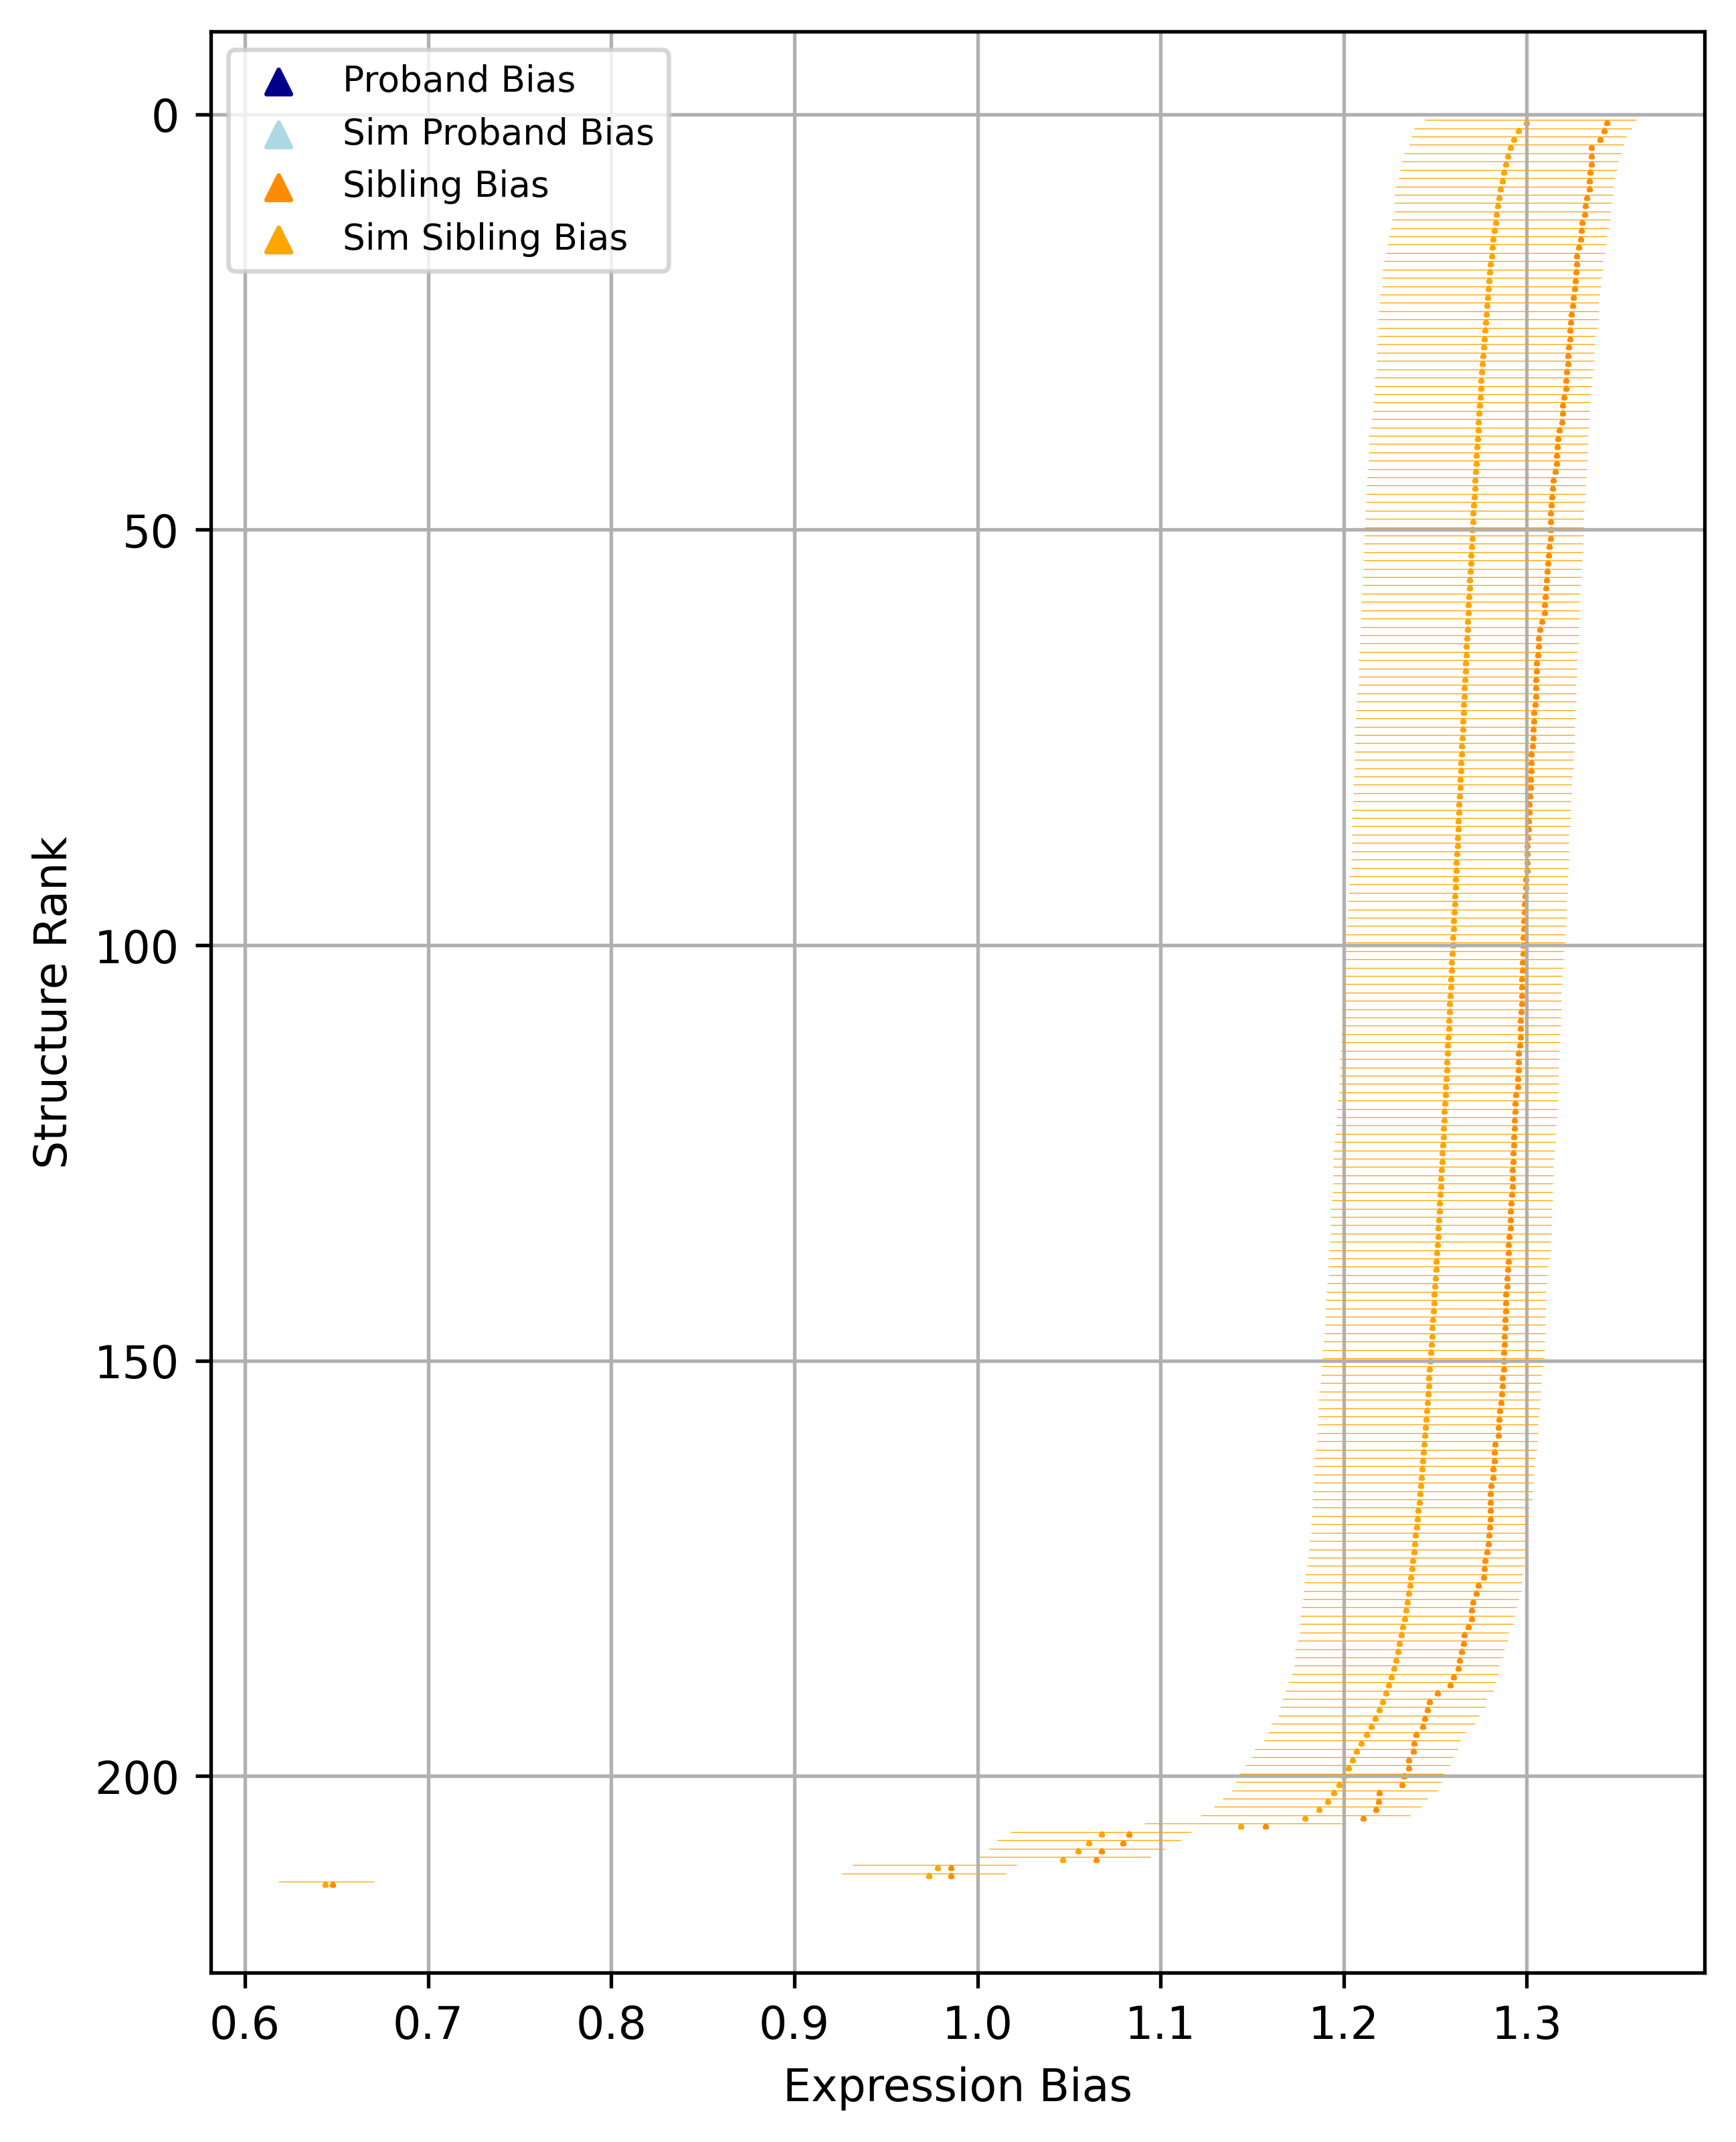

In [713]:
fig, ax = plt.subplots(figsize=(6, 8), dpi=480)

for i, (STR, STR_bias) in enumerate(sorted(Sib_Bias.items(), key=lambda x:x[1].Rank)):
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="darkorange")
for i, (Rank, data) in enumerate(sorted(Sib_Sim_Bias_Rank.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1 -0.3, lower, upper, color = "orange", lw=0.2)
    x3 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="orange")
    
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x2, x4, x1, x3], 
                 ["Proband Bias", "Sim Proband Bias", "Sibling Bias", "Sim Sibling Bias"], 
                 prop={'size': 8})

lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
#lgnd.legendHandles[2]._sizes = [30]

#plt.title(title)
#plt.xlim(-0.2, 0.2)
plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.grid(True)
#return plt

No handles with labels found to put in legend.


<AxesSubplot:>

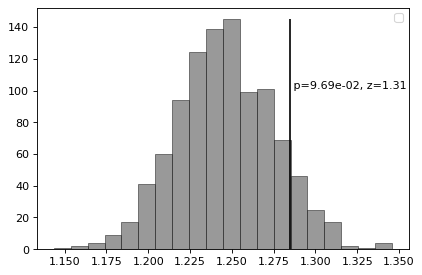

In [715]:
# Sibling bootstraped biases
biases_sib_boot = []
for file in os.listdir(Sib_Sim_Dir):
    if not file.startswith("cont.bias"):
        continue
    df = pd.read_csv(Sib_Sim_Dir+file, index_col="STR")
    biases_sib_boot.append(np.mean([abs(x) for x in df["EFFECT"].values]))
    
bias_sib = np.mean([abs(x) for x in Sib_BiasDF["EFFECT"].values])

fig, ax = plt.subplots()
PlotPermutationP(biases_sib_boot, bias_sib, ax)

### Z1 

In [716]:
xx = AvgSTRZ_Weighted(ExpZ1, weight_dict, csv_fil="dat/sib.bias.z1.csv")
Sib_BiasDF = pd.read_csv("dat/sib.bias.z1.csv", index_col="STR")
Sib_Sim_Dir = "dat/SimulateSibling_Z1/"
Sib_Bias, Sib_Sim_Bias_Rank, Sib_Sim_Bias_STR = LoadBiasData2(Sib_BiasDF, Sib_Sim_Dir)

In [717]:
xx.head(5)

STR    EFFECT    REGION  Rank
0         Posterior_limiting_nucleus_of_the_thalamus  0.148767  Thalamus     1
1   Ventral_anterior_lateral_complex_of_the_thalamus  0.132126  Thalamus     2
2                                  Cuneiform_nucleus  0.128632  Midbrain     3
3  Lateral_septal_nucleus_rostral_rostroventral_part  0.125161  Striatum     4
4              Medial_geniculate_complex_medial_part  0.125039  Thalamus     5

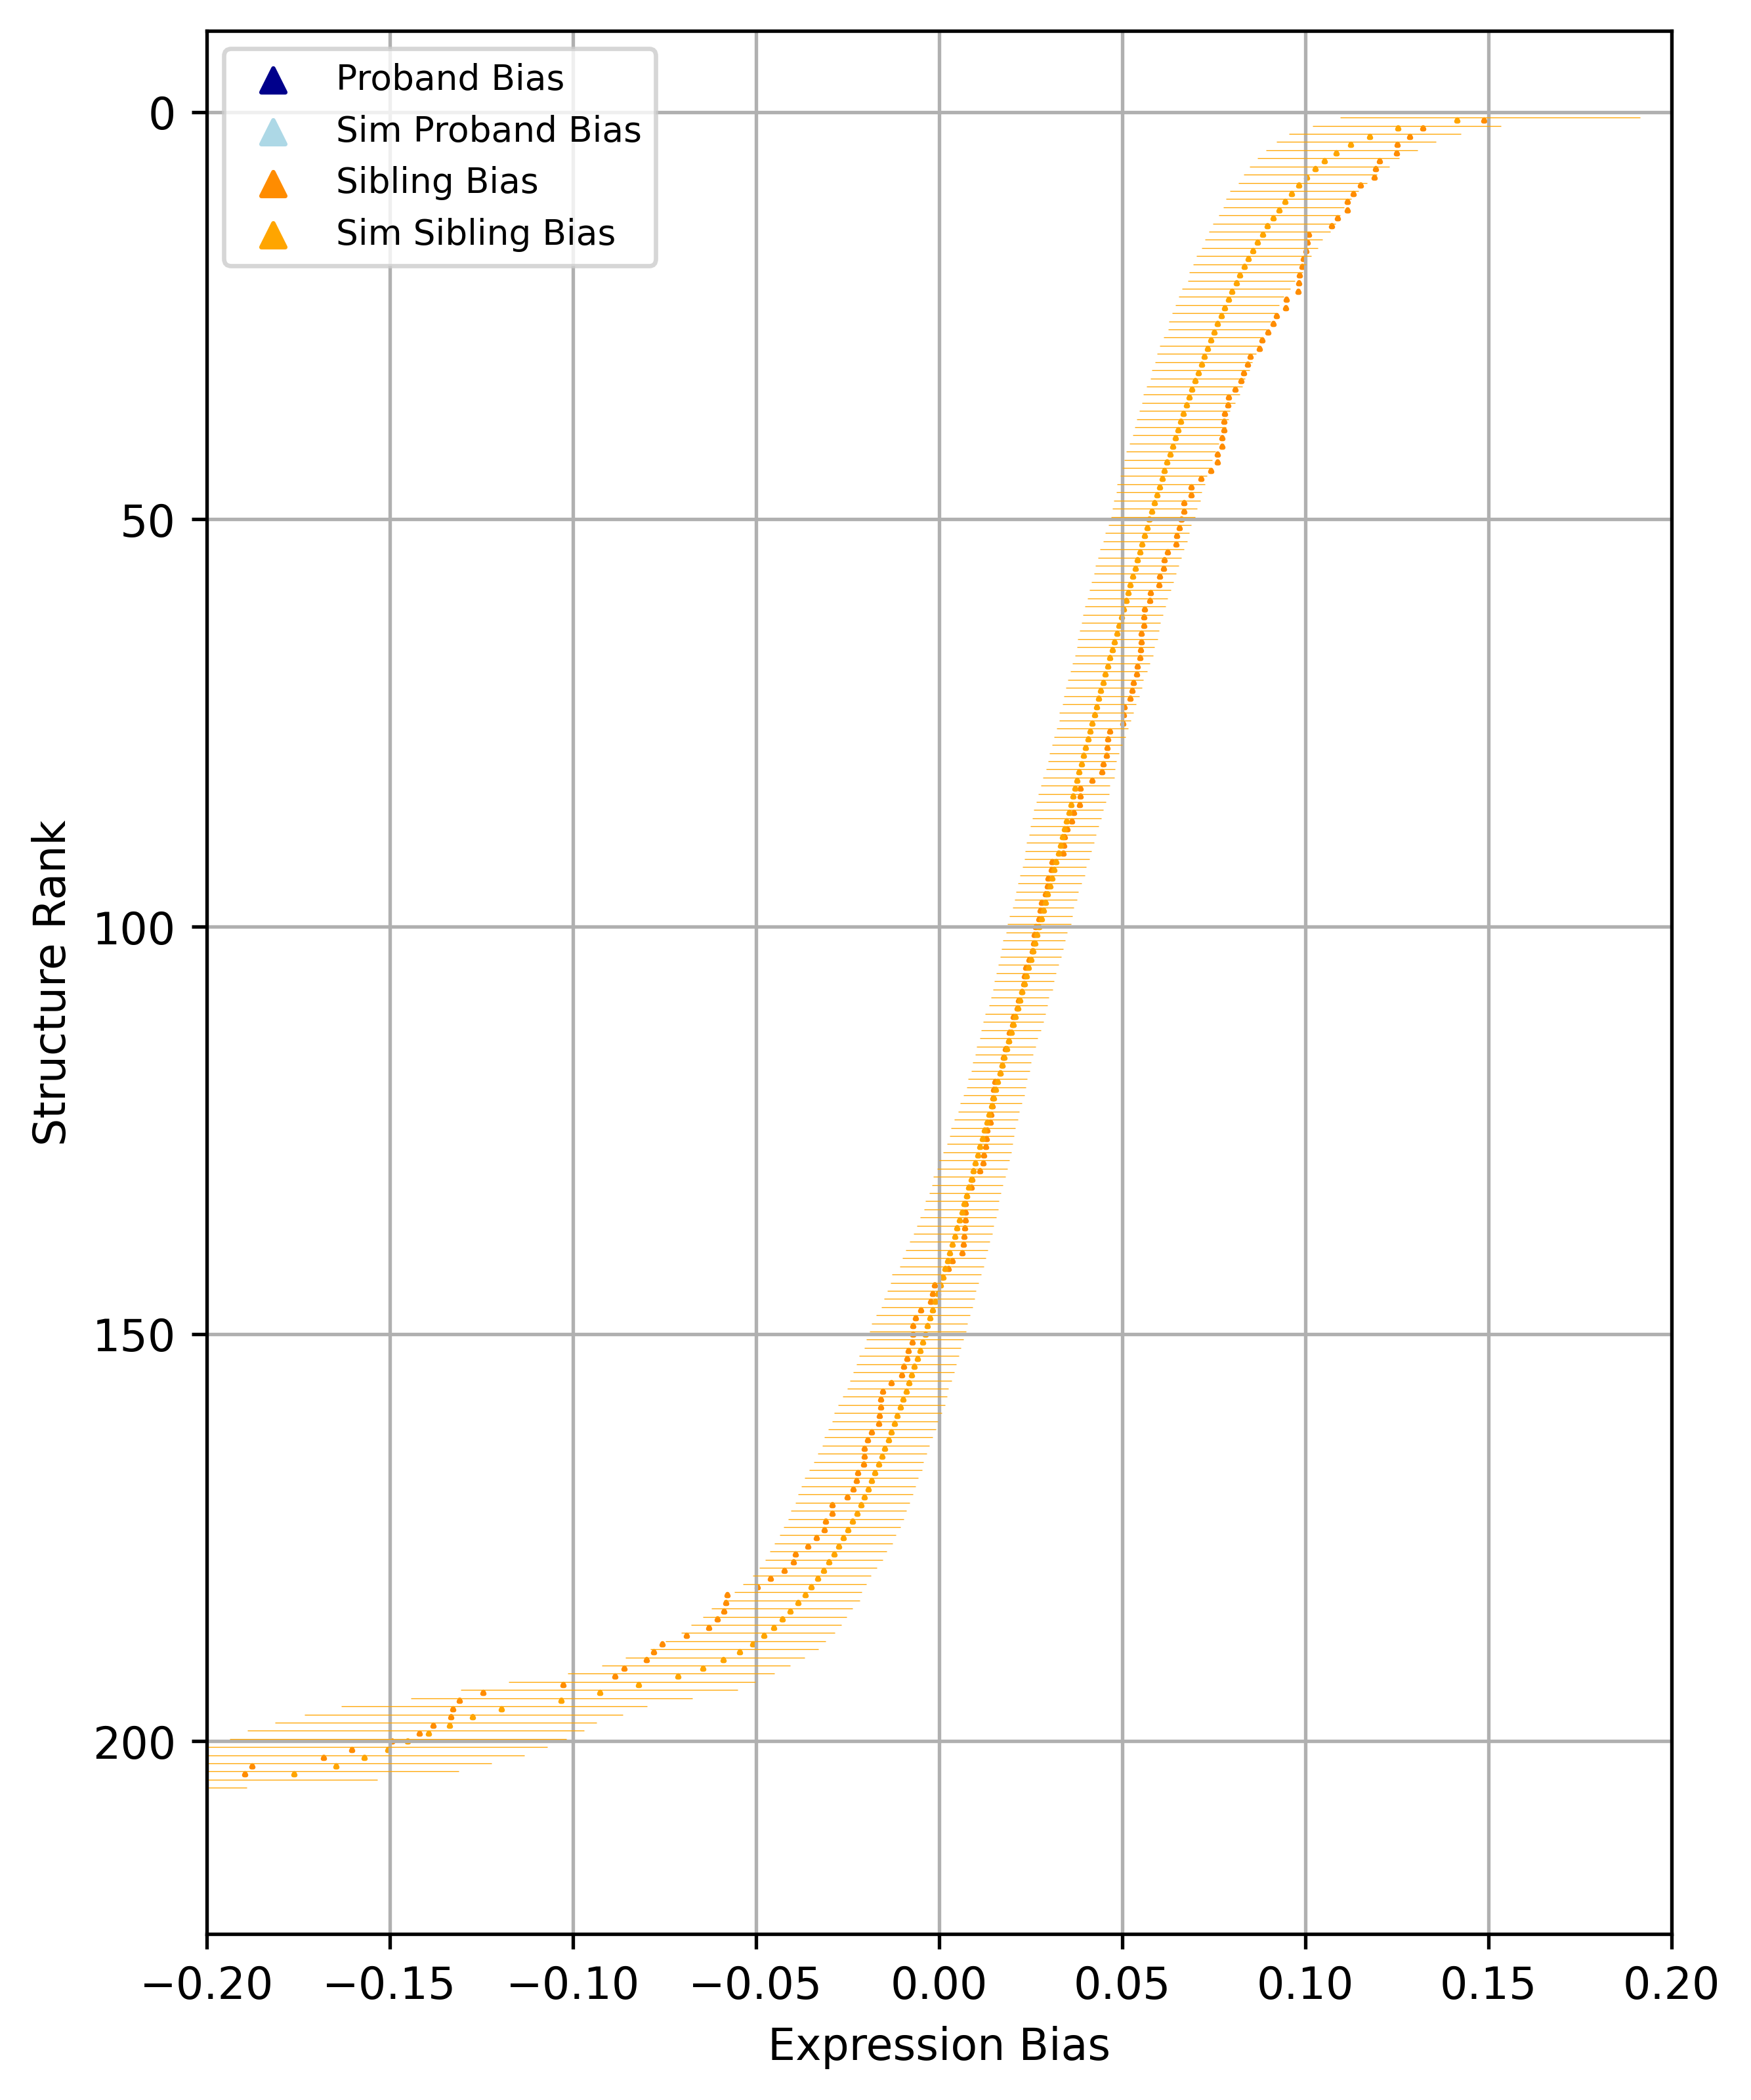

In [718]:
fig, ax = plt.subplots(figsize=(6, 8), dpi=480)

for i, (STR, STR_bias) in enumerate(sorted(Sib_Bias.items(), key=lambda x:x[1].Rank)):
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="darkorange")
for i, (Rank, data) in enumerate(sorted(Sib_Sim_Bias_Rank.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1 -0.3, lower, upper, color = "orange", lw=0.2)
    x3 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="orange")
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x2, x4, x1, x3], 
                 ["Proband Bias", "Sim Proband Bias", "Sibling Bias", "Sim Sibling Bias"], 
                 prop={'size': 8})

lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]
#lgnd.legendHandles[2]._sizes = [30]

#plt.title(title)
plt.xlim(-0.2, 0.2)
plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.grid(True)

No handles with labels found to put in legend.


<AxesSubplot:>

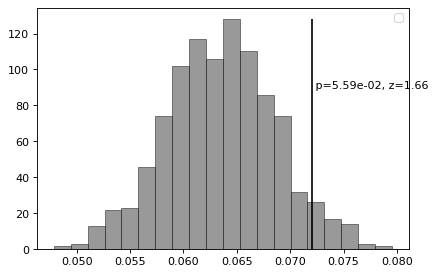

In [719]:
# Sibling bootstraped biases
biases_sib_boot = []
for file in os.listdir(Sib_Sim_Dir):
    if not file.startswith("cont.bias"):
        continue
    df = pd.read_csv(Sib_Sim_Dir+file, index_col="STR")
    biases_sib_boot.append(np.mean([abs(x) for x in df["EFFECT"].values]))
    
bias_sib = np.mean([abs(x) for x in Sib_BiasDF["EFFECT"].values])

fig, ax = plt.subplots()
PlotPermutationP(biases_sib_boot, bias_sib, ax)

In [660]:
topN = 50
dist_asd = _Z2_Match_Bias[:, :topN].mean(axis=1)

sib_Z2_Match_Bias = []
for file in os.listdir(Sib_Sim_Dir):
    if not file.startswith("cont.bias"):
        continue
    df = pd.read_csv(Sib_Sim_Dir+file, index_col="STR")
    sib_Z2_Match_Bias.append(df["EFFECT"].values)
sib_Z2_Match_Bias = np.array(sib_Z2_Match_Bias)
dist_sib = sib_Z2_Match_Bias[:, :topN].mean(axis=1)

No handles with labels found to put in legend.


<AxesSubplot:>

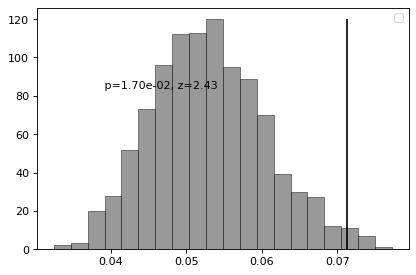

In [661]:
fig, ax = plt.subplots()
Sib_Z2_Bias = pd.read_csv("dat/sib.bias.csv", index_col="STR")
PlotPermutationP(dist_sib, np.mean(Sib_Z2_Bias["EFFECT"].values[:topN]), ax)

In [550]:
xxx = pd.read_csv("dat/Denovo_Sim/sib_denovo_simulations.1.csv", index_col=0)

In [552]:
datxx = []
for i, row in xxx.iterrows():
    #row = [sum(x) for x in row]
    row = [sum([int(y) for y in x.split(",")]) for x in row]
    counts = [1 for x in row if x > 0]
    datxx.append(sum(counts))

In [553]:
datxx

[1552,
 1503,
 1579,
 1532,
 1462,
 1526,
 1474,
 1556,
 1527,
 1553,
 1547,
 1512,
 1517,
 1487,
 1529,
 1536,
 1578,
 1515,
 1515,
 1499,
 1549,
 1554,
 1558,
 1575,
 1508,
 1569,
 1548,
 1520,
 1485,
 1472,
 1520,
 1532,
 1571,
 1491,
 1541,
 1525,
 1521,
 1543,
 1531,
 1464,
 1469,
 1495,
 1413,
 1573,
 1541,
 1546,
 1530,
 1489,
 1478,
 1528,
 1560,
 1527,
 1500,
 1477,
 1502,
 1555,
 1490,
 1535,
 1558,
 1536,
 1558,
 1470,
 1538,
 1575,
 1463,
 1474,
 1593,
 1579,
 1485,
 1553,
 1529,
 1510,
 1470,
 1509,
 1500,
 1491,
 1505,
 1529,
 1466,
 1500,
 1616,
 1558,
 1546,
 1547,
 1451,
 1546,
 1502,
 1533,
 1548,
 1417,
 1517,
 1480,
 1472,
 1514,
 1501,
 1539,
 1500,
 1567,
 1510,
 1488,
 1573,
 1481,
 1578,
 1507,
 1546,
 1498,
 1491,
 1451,
 1568,
 1504,
 1522,
 1488,
 1553,
 1463,
 1542,
 1545,
 1528,
 1567,
 1473,
 1571,
 1503,
 1535,
 1543,
 1546,
 1573,
 1446,
 1477,
 1447,
 1541,
 1564,
 1553,
 1538,
 1456,
 1548,
 1507,
 1611,
 1528,
 1557,
 1576,
 1466,
 1537,
 1534,
 1537,

In [556]:
ccc = 0
for k,v in weight_dict.items():
    if v > 0:
        ccc += 1
print(ccc)

1356


In [458]:
# ASD Z2 and 61 Rand Genes
Z2_Bias = pd.read_csv("dat/bias2/ASD.EW.pLI.z2.csv", index_col="STR")
Z2_Boot_Dir = "dat/Bootstrap_Match/asd.boot.bias.z2/"
Z2_Match_dir = "dat/Control_GeneSet_Bias/Rand_Gene_WeightTransfer/"
_Z2_Bias, _Z2_Match_Bias_Rank, _Z2_Match_Bias_STR = LoadBiasData(
    Z2_Bias,Z2_Boot_Dir,Z2_Match_dir)

In [473]:
_Z2_Match_Bias = []
for file in os.listdir(Z2_Match_dir):
    df = pd.read_csv(Z2_Match_dir+file, index_col="STR")
    _Z2_Match_Bias.append(df["EFFECT"].values)

In [475]:
_Z2_Match_Bias = np.array(_Z2_Match_Bias)

In [476]:
_Z2_Match_Bias.shape

(9988, 213)

In [496]:
topN = 50
dist = _Z2_Match_Bias[:, :topN].mean(axis=1)

No handles with labels found to put in legend.


<AxesSubplot:>

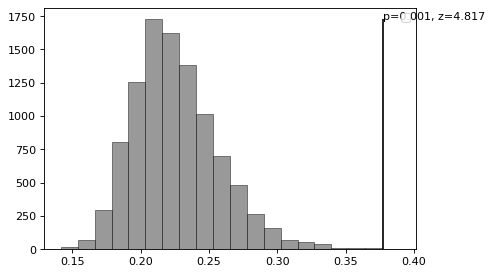

In [497]:
fig, ax = plt.subplots()
PlotPermutationP(dist, np.mean(Z2_Bias["EFFECT"].values[:topN]), ax)

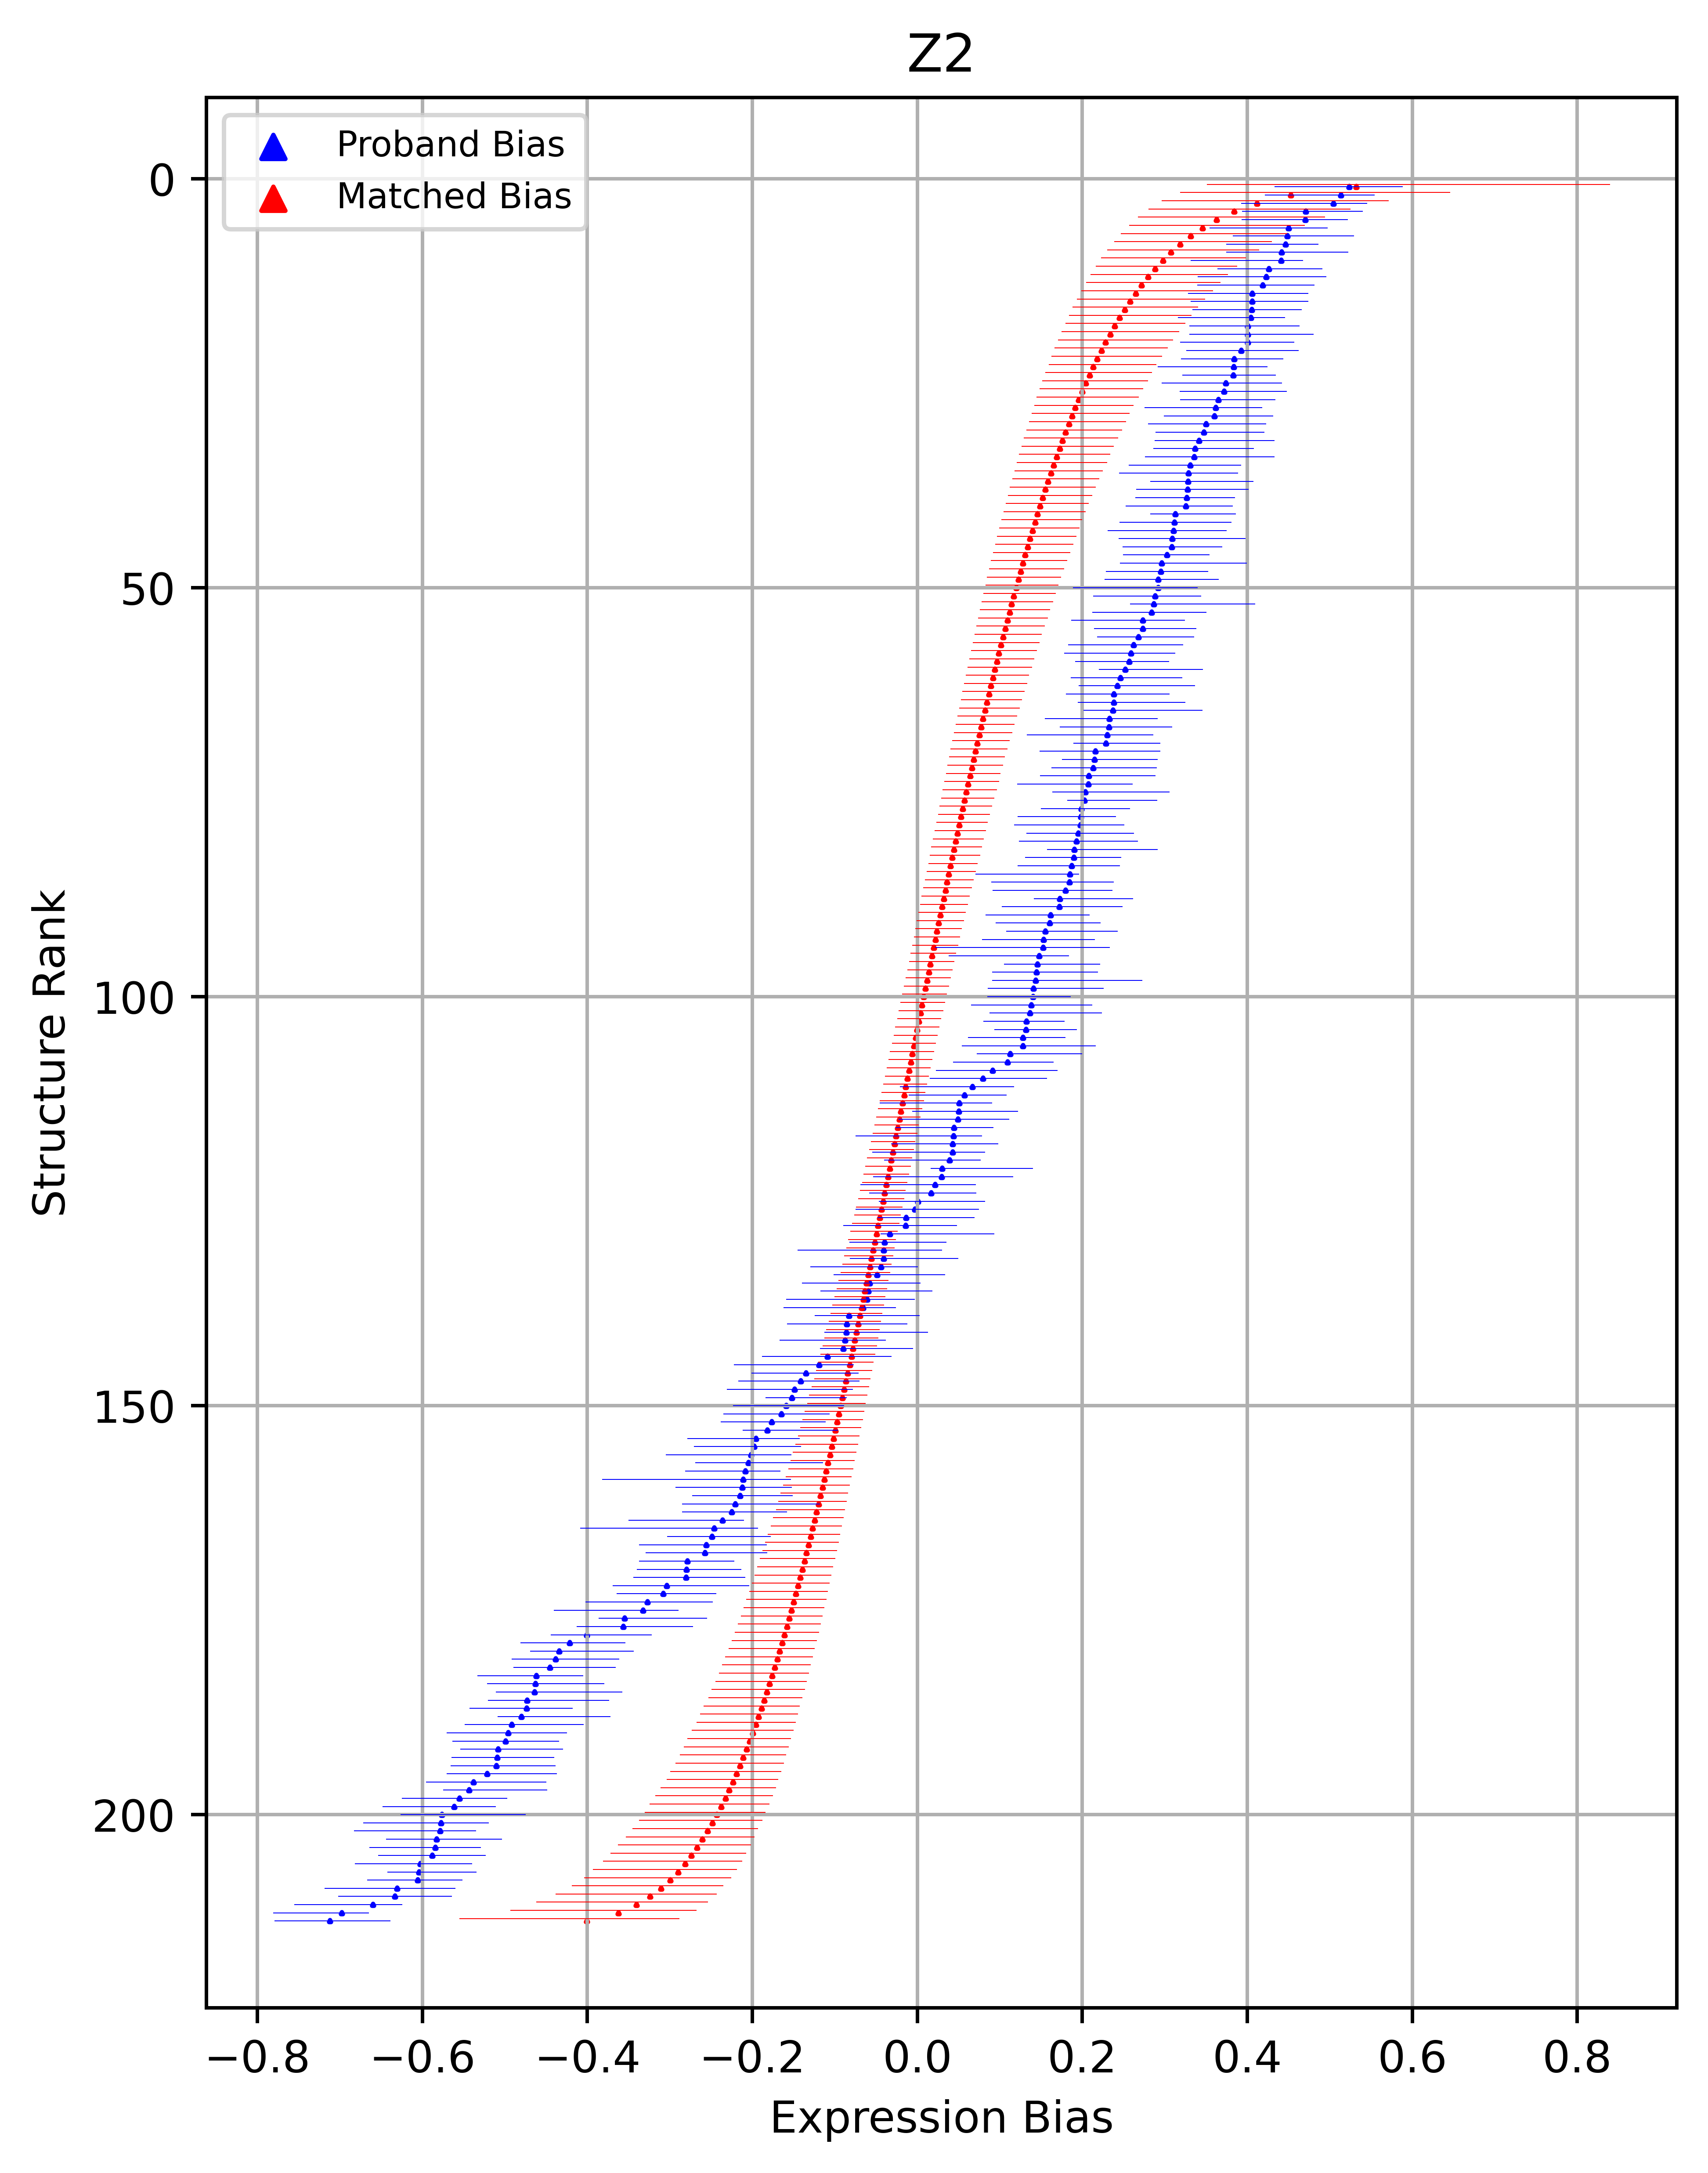

In [520]:
plt = PlotExpBias(_Z2_Bias, _Z2_Bias, _Z2_Match_Bias_Rank, "Z2")

No handles with labels found to put in legend.


<AxesSubplot:>

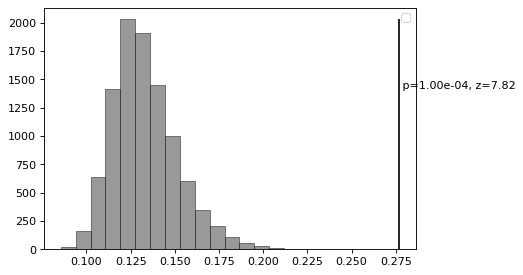

In [721]:
# Sibling bootstraped biases
biases_sib_boot = []
for file in os.listdir(Z2_Match_dir):
    if not file.startswith("cont.bias"):
        continue
    df = pd.read_csv(Z2_Match_dir+file, index_col="STR")
    biases_sib_boot.append(np.mean([abs(x) for x in df["EFFECT"].values]))
    
bias_sib = np.mean([abs(x) for x in Z2_Bias["EFFECT"].values])

fig, ax = plt.subplots()
PlotPermutationP(biases_sib_boot, bias_sib, ax)

In [722]:
Z2_Match_dir

'dat/Control_GeneSet_Bias/Rand_Gene_WeightTransfer/'

In [465]:
for STR, row in Z2_Bias.iterrows():
    #mat_bias = getBiasesBySTR(STR, match_dfs)
    mat_bias = _Z2_Match_Bias_STR[STR]
    Z, P = GetPermutationP(mat_bias, row["EFFECT"])
    print("%d %s %.3f %.3e" % (row["Rank"], STR, row["EFFECT"], P))
    Z2_Bias.loc[STR, "Z3"] = Z
    Z2_Bias.loc[STR, "Pvalue"] = P

1 Lateral_amygdalar_nucleus 0.524 3.504e-03
2 Orbital_area_lateral_part 0.514 2.303e-03
3 Prelimbic_area 0.504 3.504e-03
4 Dentate_gyrus 0.471 9.110e-03
5 Nucleus_accumbens 0.470 6.607e-03
6 Orbital_area_ventrolateral_part 0.450 4.805e-03
7 Anterior_pretectal_nucleus 0.449 9.110e-03
8 Basomedial_amygdalar_nucleus 0.447 7.108e-03
9 Lateral_posterior_nucleus_of_the_thalamus 0.442 1.041e-02
10 Infralimbic_area 0.441 7.108e-03
11 Intercalated_amygdalar_nucleus 0.426 8.910e-03
12 Endopiriform_nucleus_dorsal_part 0.423 9.310e-03
13 Claustrum 0.419 1.321e-02
14 Nucleus_of_reuniens 0.406 1.221e-02
15 Anterior_olfactory_nucleus 0.406 1.301e-02
16 Primary_somatosensory_area_lower_limb 0.406 1.271e-02
17 Dorsal_peduncular_area 0.404 1.512e-02
18 Field_CA3 0.401 1.351e-02
19 Subiculum_ventral_part 0.400 1.251e-02
20 Field_CA1 0.400 1.472e-02
21 Anteromedial_visual_area 0.392 1.502e-02
22 Parafascicular_nucleus 0.384 1.672e-02
23 Field_CA2 0.383 1.772e-02
24 Endopiriform_nucleus_ventral_part 0.383 

194 Nucleus_of_the_solitary_tract -0.510 9.995e-01
195 Parvicellular_reticular_nucleus -0.522 9.997e-01
196 Nucleus_prepositus -0.538 9.999e-01
197 Spinal_nucleus_of_the_trigeminal_oral_part -0.543 9.999e-01
198 Motor_nucleus_of_trigeminal -0.555 9.999e-01
199 Nucleus_of_the_lateral_lemniscus -0.562 9.999e-01
200 Paragigantocellular_reticular_nucleus_dorsal_part -0.576 1.000e+00
201 Pontine_reticular_nucleus -0.578 1.000e+00
202 Lateral_reticular_nucleus -0.579 9.999e-01
203 Intermediate_reticular_nucleus -0.583 9.998e-01
204 Magnocellular_reticular_nucleus -0.585 9.999e-01
205 Hypoglossal_nucleus -0.588 9.998e-01
206 Principal_sensory_nucleus_of_the_trigeminal -0.603 1.000e+00
207 Globus_pallidus_internal_segment -0.604 1.000e+00
208 Gigantocellular_reticular_nucleus -0.606 1.000e+00
209 Superior_olivary_complex -0.631 1.000e+00
210 Pontine_reticular_nucleus_caudal_part -0.634 1.000e+00
211 Paragigantocellular_reticular_nucleus_lateral_part -0.660 1.000e+00
212 Facial_motor_nucleus -0

In [467]:
Z2_Bias.head(50)

EFFECT  \
STR                                                           
Lateral_amygdalar_nucleus                          0.523800   
Orbital_area_lateral_part                          0.513619   
Prelimbic_area                                     0.504315   
Dentate_gyrus                                      0.470681   
Nucleus_accumbens                                  0.470189   
Orbital_area_ventrolateral_part                    0.449988   
Anterior_pretectal_nucleus                         0.448637   
Basomedial_amygdalar_nucleus                       0.446566   
Lateral_posterior_nucleus_of_the_thalamus          0.441555   
Infralimbic_area                                   0.440787   
Intercalated_amygdalar_nucleus                     0.425861   
Endopiriform_nucleus_dorsal_part                   0.423122   
Claustrum                                          0.418710   
Nucleus_of_reuniens                                0.405664   
Anterior_olfactory_nucleus                         0.405628   
Primary_somatosensory_area_lower_limb              0.405558   
Dorsal_peduncular_area                             0.404170   
Field_CA3                                          0.400516   
Subiculum_ventral_part                             0.400483   
Field_CA1                                          0.400464   
Anteromedial_visual_area                           0.392481   
Parafascicular_nucleus                             0.384060   
Field_CA2                                          0.383446   
Endopiriform_nucleus_ventral_part                  0.383209   
Lateral_septal_nucleus_ventral_part                0.373794   
Agranular_insular_area_posterior_part              0.371547   
Bed_nuclei_of_the_stria_terminalis                 0.364845   
Visceral_area                                      0.361528   
Caudoputamen                                       0.360304   
Retrosplenial_area_lateral_agranular_part          0.350012   
Primary_motor_area                                 0.347098   
Primary_visual_area                                0.341214   
Submedial_nucleus_of_the_thalamus                  0.336608   
Mediodorsal_nucleus_of_thalamus                    0.335703   
Anterior_cingulate_area_dorsal_part                0.330674   
Rhomboid_nucleus                                   0.328770   
Parasubiculum                                      0.328215   
Secondary_motor_area                               0.327629   
Gustatory_areas                                    0.326739   
Piriform_area                                      0.325450   
Central_amygdalar_nucleus                          0.312884   
Lateral_visual_area                                0.311490   
Basolateral_amygdalar_nucleus                      0.310648   
Parataenial_nucleus                                0.308930   
Lateral_septal_nucleus_rostral_rostroventral_part  0.308565   
Agranular_insular_area_ventral_part                0.302838   
Accessory_olfactory_bulb                           0.296242   
Lateral_septal_nucleus_caudal_caudodorsal_part     0.295091   
Central_lateral_nucleus_of_the_thalamus            0.291800   
Orbital_area_medial_part                           0.291742   

                                                              REGION  Rank  \
STR                                                                          
Lateral_amygdalar_nucleus                                  Amygdalar     1   
Orbital_area_lateral_part                                  Isocortex     2   
Prelimbic_area                                             Isocortex     3   
Dentate_gyrus                                            Hippocampus     4   
Nucleus_accumbens                                           Striatum     5   
Orbital_area_ventrolateral_part                            Isocortex     6   
Anterior_pretectal_nucleus                                  Midbrain     7   
Basomedial_amygdalar_nucleus                               Amygdalar     8

In [198]:
Z1_Bias = pd.read_csv("dat/bias2/ASD.EW.pLI.z1.csv", index_col="STR")
Z1_Boot_Dir = "dat/Bootstrap_Match/asd.boot.bias.z1/"
Z1_Match_Dir = "dat/Bootstrap_Match/asd.cont.bias.z1/"
_Z1_Bias, _Z1_Match_Bias_Rank, _Z1_Match_Bias_STR = LoadBiasData(Z1_Bias,Z1_Boot_Dir,Z1_Match_Dir)

In [228]:
Z1_Sib = "dat/bias2/ASD.Siblings.z1.csv"
Z1_Sib_Boot = "dat/Bootstrap_Match/Sib.boot.Z1.bias/"
Z1_Sib = LoadSiblingBias(Z1_Sib, Z1_Sib_Boot)

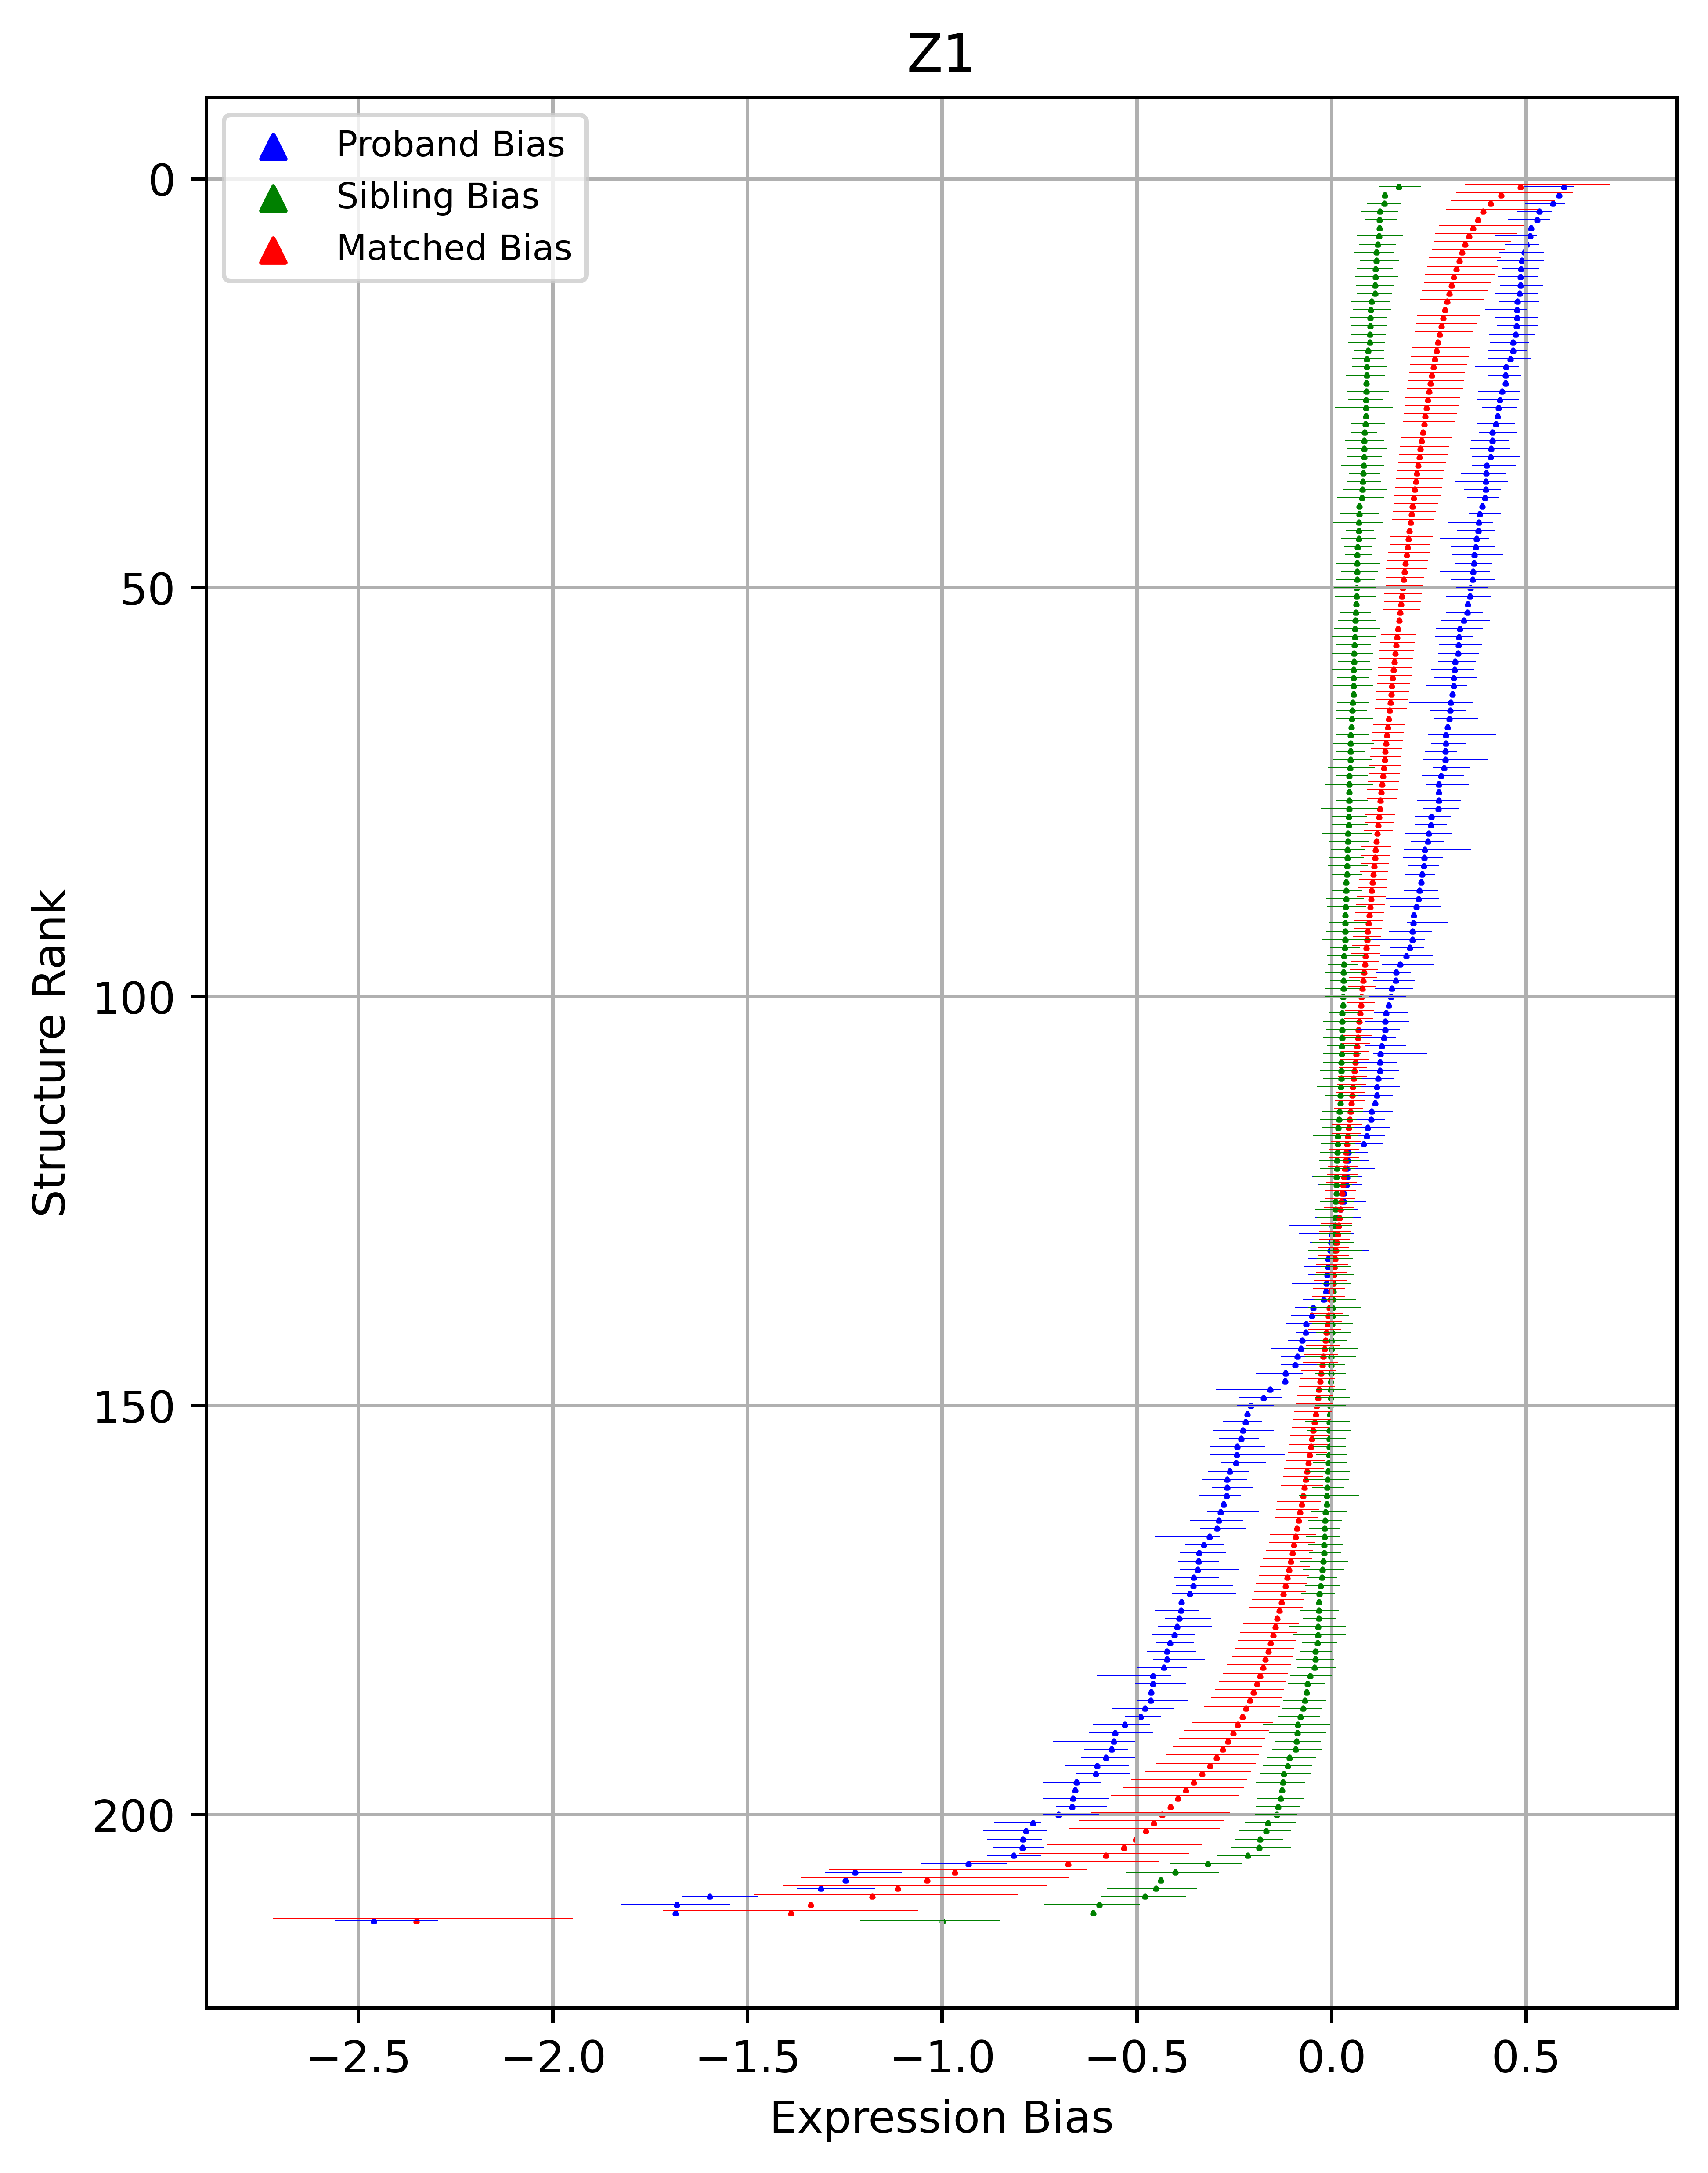

In [235]:
plt = PlotExpBias(_Z1_Bias, Z1_Sib, _Z1_Match_Bias_Rank, "Z1")

In [114]:
Z2_Bias = pd.read_csv("dat/bias2/ASD.EW.pLI.z2.csv", index_col="STR")
Z2_Boot_Dir = "dat/Bootstrap_Match/asd.boot.bias.z2/"
Z2_Match_dir = "dat/Bootstrap_Match/asd.cont.bias.z2/"
_Z2_Bias, _Z2_Match_Bias_Rank, _Z2_Match_Bias_STR = LoadBiasData(Z2_Bias,Z2_Boot_Dir,Z2_Match_dir)

In [217]:
Z2_Sib = "dat/bias2/ASD.Siblings.z2.csv"
Z2_Sib_Boot = "dat/Bootstrap_Match/Sib.boot.Z2.bias/"
Z2_Sib = LoadSiblingBias(Z2_Sib, Z2_Sib_Boot)

0.1294081714925991
0.1287079948495983
0.117248620620653
0.103704796528983
0.1023244089187741
0.1018270351239274
0.0957448908828157
0.0955449824868387
0.0951614493841909
0.0926740237764208
0.0919668528587878
0.090722870583524
0.0905948696532489
0.0899345432946247
0.0887768087181533
0.0847771301122143
0.0820242540061644
0.0809234609794139
0.0793028765425317
0.0779967415692157
0.0726190562361829
0.071174209758201
0.0682546481425196
0.0664038201151435
0.0646358626985954
0.0621091826556708
0.0602140192903337
0.0584940619484228
0.0573756277912516
0.0569224702532559
0.0559114959786301
0.0547576520437788
0.0545289734736954
0.0541514806127348
0.0534733975680852
0.0498276533281707
0.049170632043812
0.048147373166198
0.0479681533584653
0.0476992207074035
0.0468623045391761
0.0435922445129287
0.0434660231303839
0.0434239563528555
0.0425001849519236
0.0417179774702483
0.0415722258266953
0.040685028784326
0.0404602600819458
0.0393605834034025
0.0387445301992993
0.0386526029328123
0.037264568100923
0

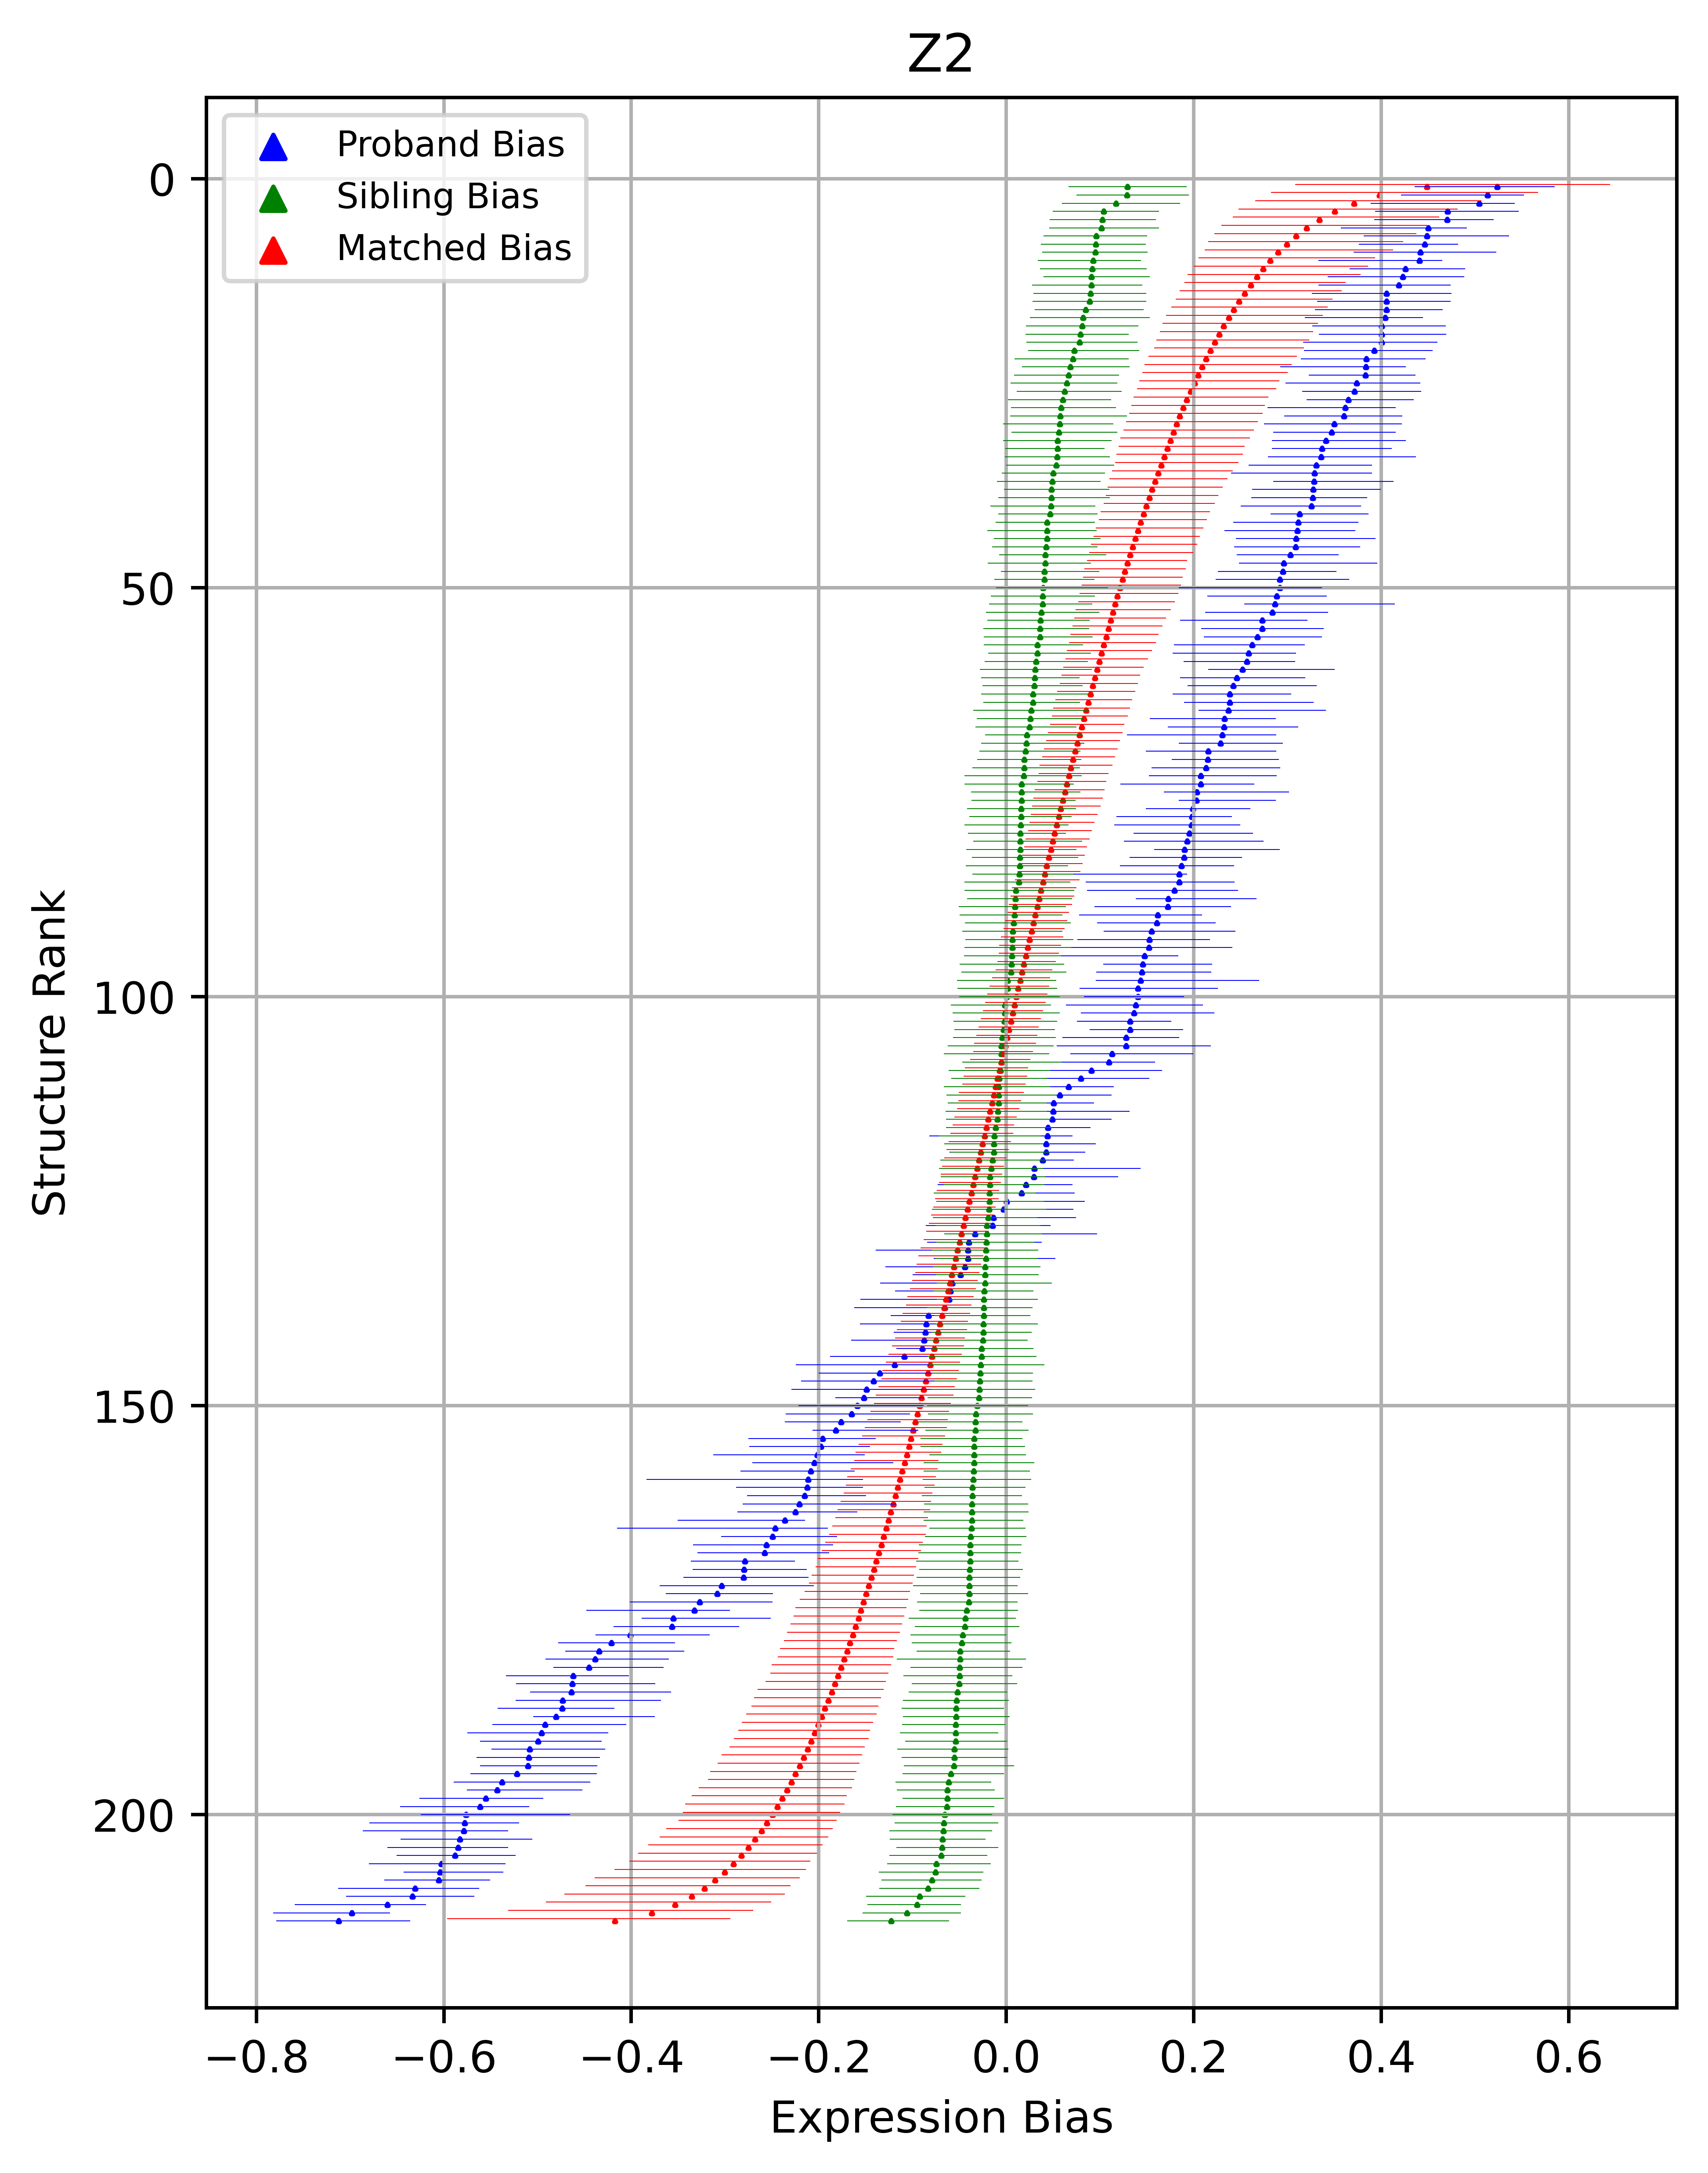

In [236]:
plt = PlotExpBias(_Z2_Bias, Z2_Sib, _Z2_Match_Bias_Rank, "Z2")

In [674]:
for STR, row in Z2_Bias.iterrows():
    #mat_bias = getBiasesBySTR(STR, match_dfs)
    mat_bias = _Z2_Match_Bias_STR[STR]
    Z, P = GetPermutationP(mat_bias, row["EFFECT"])
    print("%d %s %.3f %.3f" % (row["Rank"], STR, row["EFFECT"], P))
    Z2_Bias.loc[STR, "Z3"] = Z
    Z2_Bias.loc[STR, "Pvalue"] = P

1 Lateral_amygdalar_nucleus 0.524 0.004
2 Orbital_area_lateral_part 0.514 0.002
3 Prelimbic_area 0.504 0.004
4 Dentate_gyrus 0.471 0.009
5 Nucleus_accumbens 0.470 0.007
6 Orbital_area_ventrolateral_part 0.450 0.005
7 Anterior_pretectal_nucleus 0.449 0.009
8 Basomedial_amygdalar_nucleus 0.447 0.007
9 Lateral_posterior_nucleus_of_the_thalamus 0.442 0.010
10 Infralimbic_area 0.441 0.007
11 Intercalated_amygdalar_nucleus 0.426 0.009
12 Endopiriform_nucleus_dorsal_part 0.423 0.009
13 Claustrum 0.419 0.013
14 Nucleus_of_reuniens 0.406 0.012
15 Anterior_olfactory_nucleus 0.406 0.013
16 Primary_somatosensory_area_lower_limb 0.406 0.013
17 Dorsal_peduncular_area 0.404 0.015
18 Field_CA3 0.401 0.014
19 Subiculum_ventral_part 0.400 0.013
20 Field_CA1 0.400 0.015
21 Anteromedial_visual_area 0.392 0.015
22 Parafascicular_nucleus 0.384 0.017
23 Field_CA2 0.383 0.018
24 Endopiriform_nucleus_ventral_part 0.383 0.015
25 Lateral_septal_nucleus_ventral_part 0.374 0.023
26 Agranular_insular_area_posterior

In [153]:
Z2_Bias.to_csv("dat/bias2/what.csv")

In [123]:
Z1_qn_Bias = pd.read_csv("dat/bias2/ASD.EW.pLI.z1.qn.csv", index_col="STR")
Z1_qn_Boot_Dir = "dat/Bootstrap_Match/asd.boot.bias.z1_qn/"
Z1_qn_Match_Dir = "dat/Bootstrap_Match/asd.cont.bias.z1_qn/"
_Z1_qn_Bias, _Z1_qn_Match_Bias_Rank, _Zq_qn_Match_Bias_STR = LoadBiasData(
    Z1_qn_Bias,Z1_qn_Boot_Dir,Z1_qn_Match_Dir)

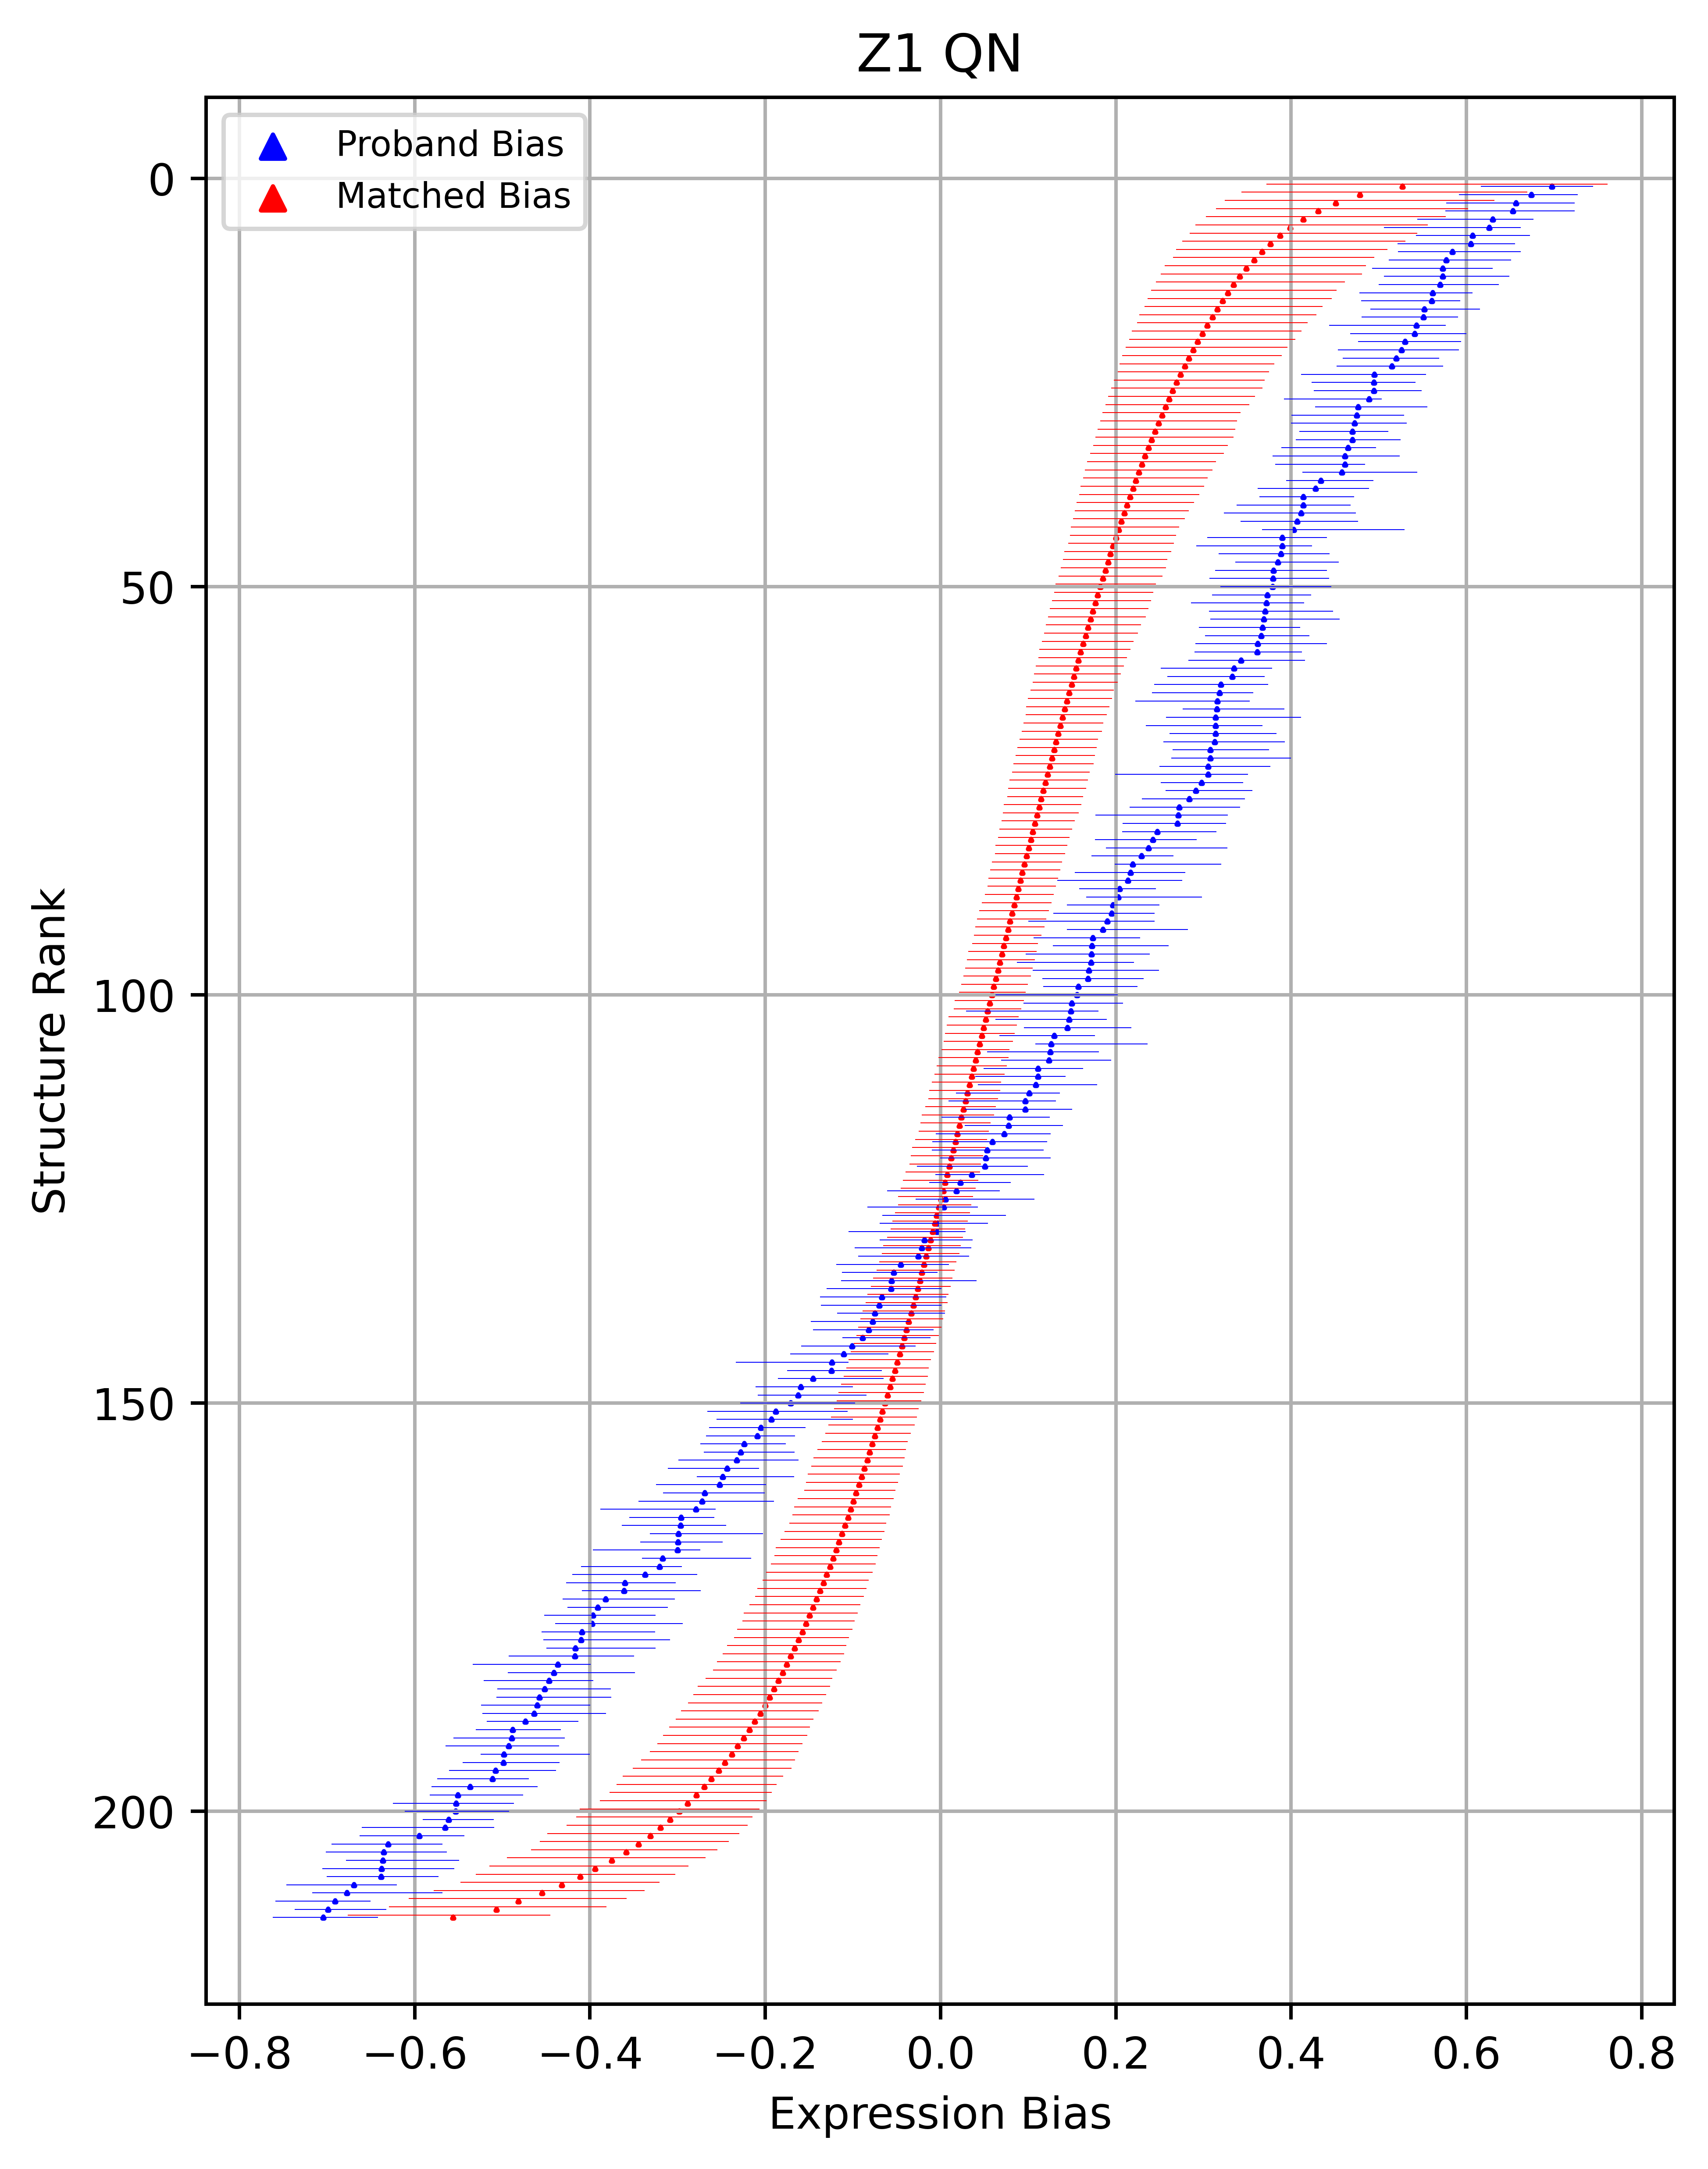

In [137]:
plt = PlotExpBias(_Z1_qn_Bias, _Z1_qn_Match_Bias_Rank, "Z1 QN")

In [128]:
Z1_Bias_ng = pd.read_csv("dat/bias2/ASD.EW.pLI.z1.noneg.csv", index_col="STR")
Z1_ng_Boot_Dir = "dat/Bootstrap_Match/asd.boot.bias.z1.noneg/"
Z1_ng_Match_Dir = "dat/Bootstrap_Match/asd.cont.bias.z1.noneg/"
_Z1_ng_Bias, _Z1_ng_Match_Bias_Rank, _Zq_ng_Match_Bias_STR = LoadBiasData(
    Z1_Bias_ng,Z1_ng_Boot_Dir,Z1_ng_Match_Dir)

In [230]:
Z1_Sib_ng = "dat/bias2/ASD.Siblings.z1.ng.csv"
Z1_Sib_ng_Boot = "dat/Bootstrap_Match/Sib.boot.Z1.bias.noneg/"
Z1_Sib_ng = LoadSiblingBias(Z1_Sib_ng, Z1_Sib_ng_Boot)

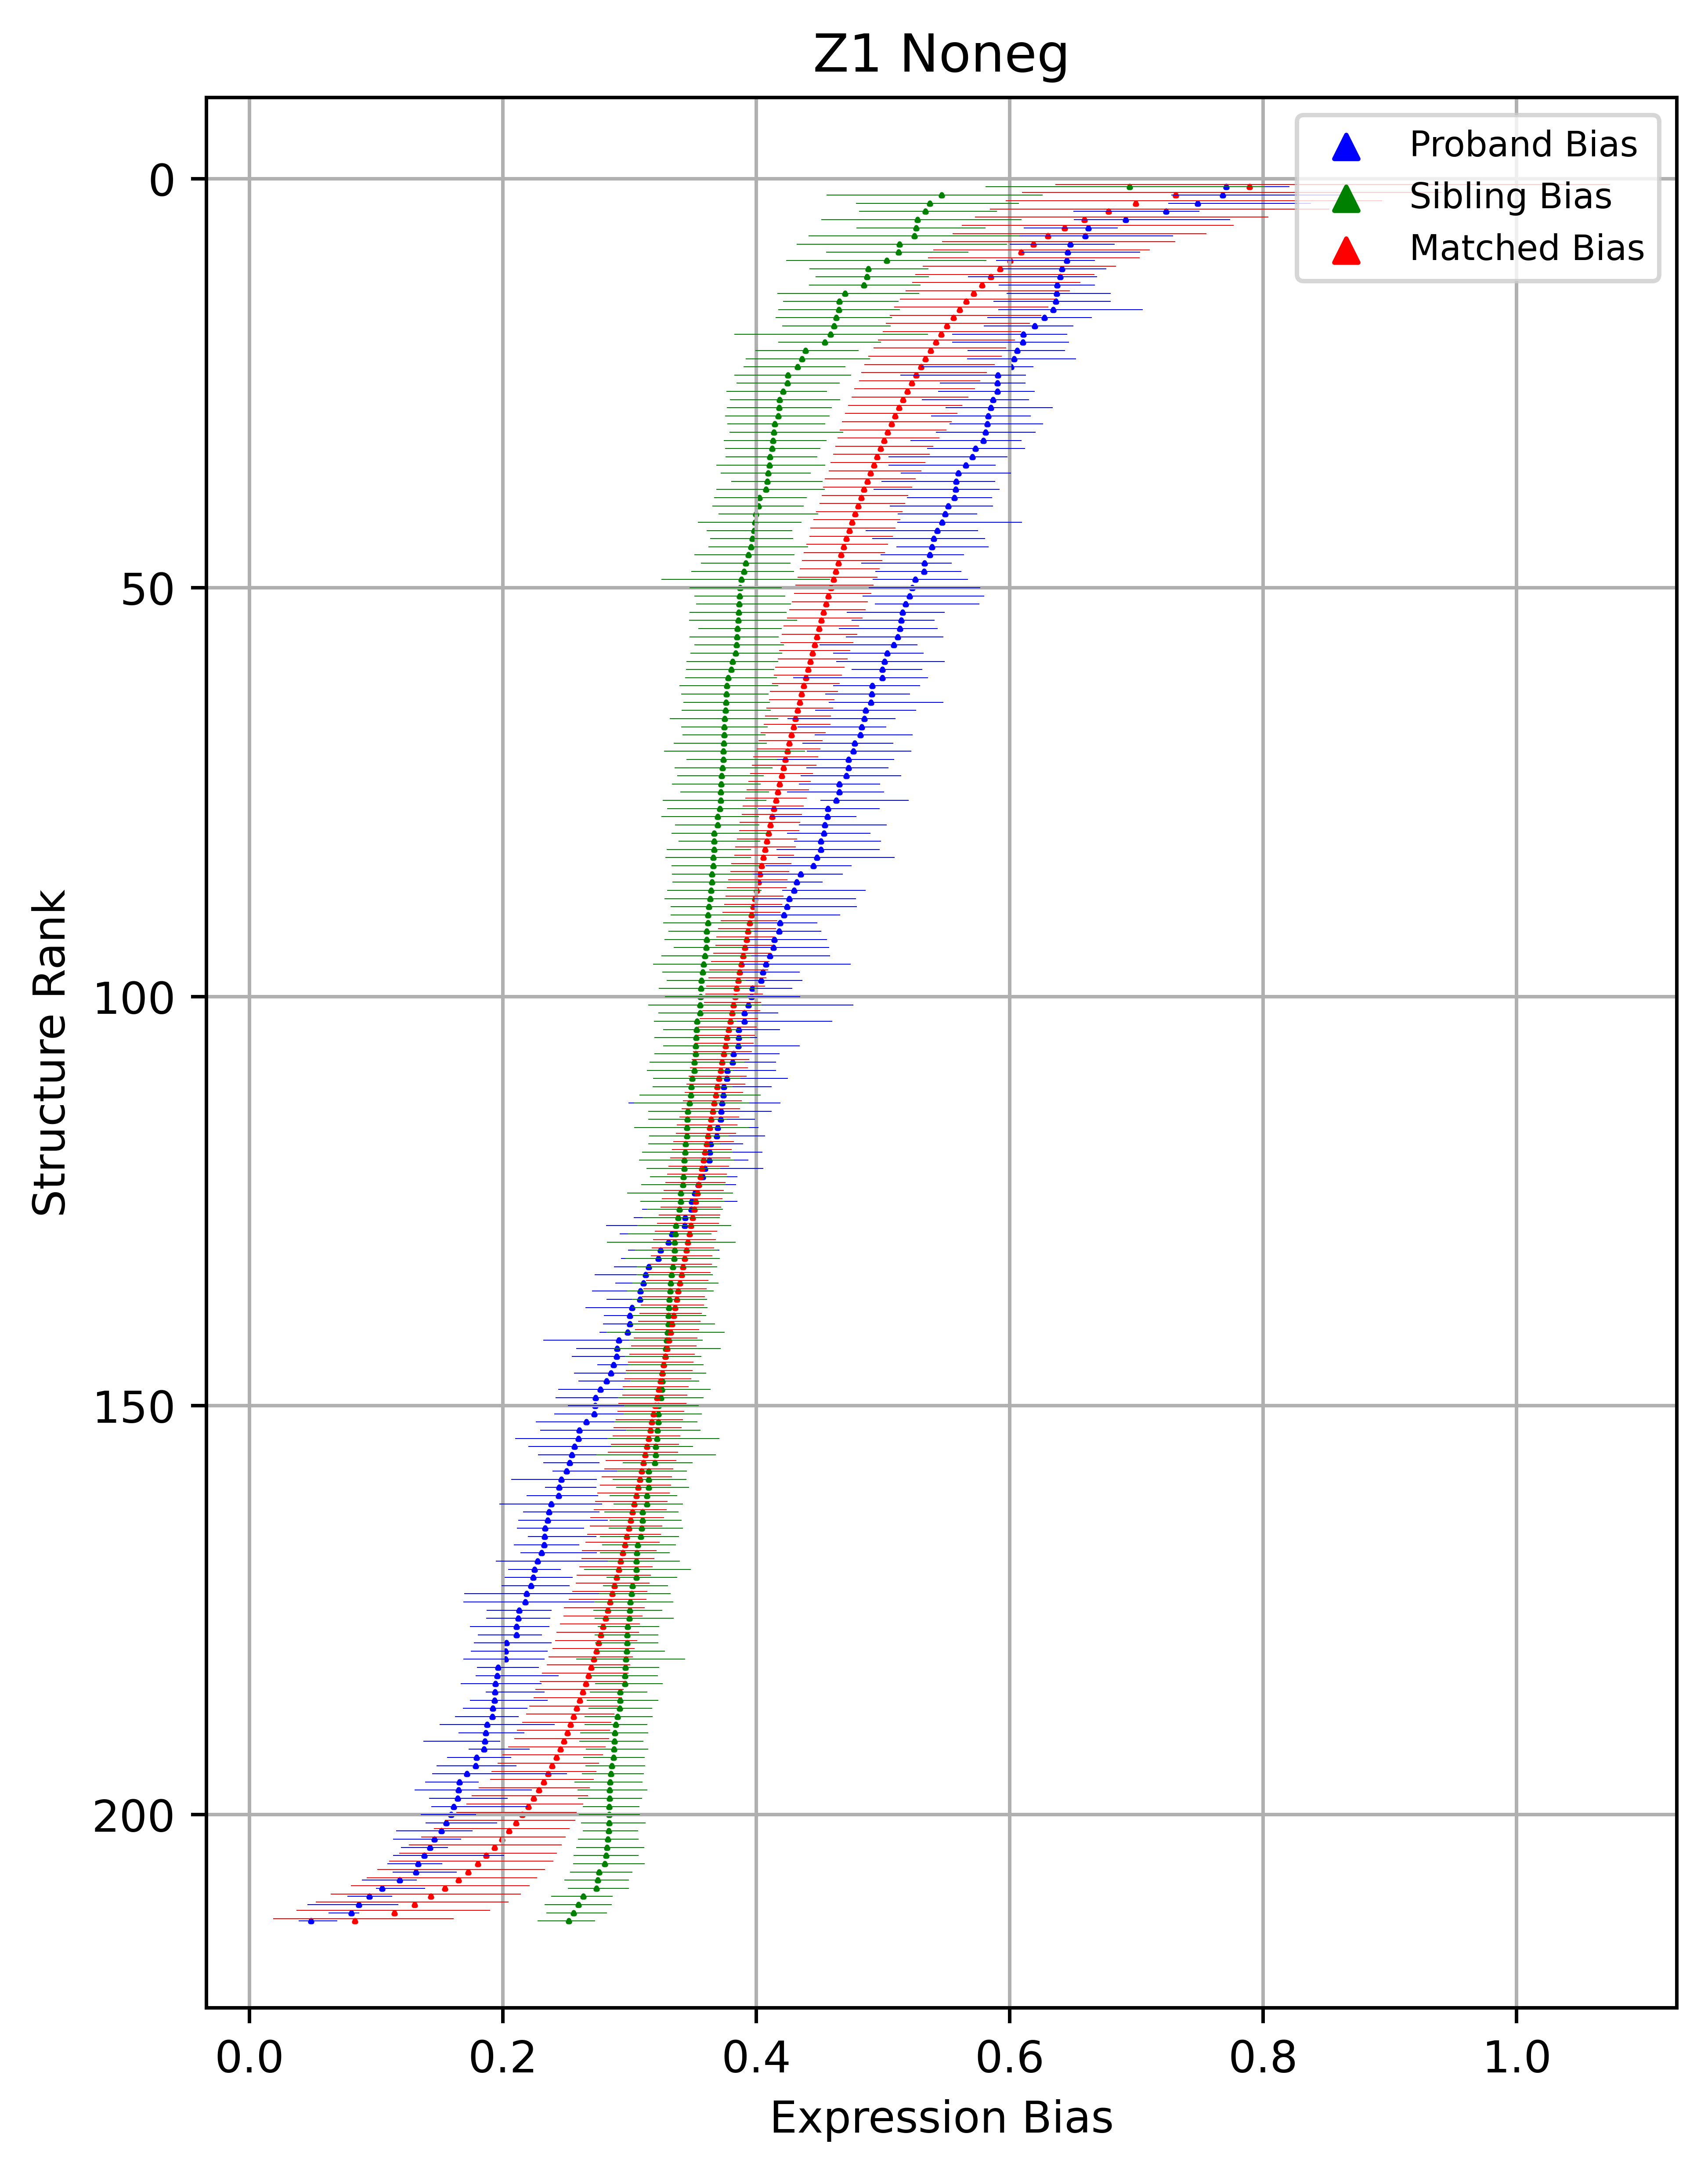

In [237]:
plt = PlotExpBias(_Z1_ng_Bias, Z1_Sib_ng, _Z1_ng_Match_Bias_Rank, "Z1 Noneg")

In [145]:
Z2_ng_Bias = pd.read_csv("dat/bias2/ASD.EW.pLI.z2.noneg.csv", index_col="STR")
Z2_Boot_ng_Dir = "dat/Bootstrap_Match/asd.boot.bias.z2.noneg/"
Z2_Match_ng_dir = "dat/Bootstrap_Match/asd.cont.bias.z2.noneg/"
_Z2_ng_Bias, _Z2_ng_Match_Bias_Rank, _Z2_ng_Match_Bias_STR = LoadBiasData(
    Z2_ng_Bias,Z2_Boot_ng_Dir,Z2_Match_ng_dir)

In [225]:
Z2_Sib_ng = "dat/bias2/ASD.Siblings.z2.ng.csv"
Z2_Sib_ng_Boot = "dat/Bootstrap_Match/Sib.boot.Z2.bias.noneg/"
Z2_Sib_ng = LoadSiblingBias(Z2_Sib_ng, Z2_Sib_ng_Boot)

0.4846254663918372
0.4702806408258512
0.4577940881932757
0.4507011288192381
0.4505181913852132
0.4471484371681365
0.4429748030632616
0.4427571802240564
0.438356159392794
0.4376821070170836
0.4346416482979606
0.4339804010504263
0.4331989622679001
0.4327715462029053
0.4322931132004141
0.429045859124525
0.4272196117057371
0.4252808078995464
0.4247765142188514
0.424435938120865
0.4233836161323972
0.4227903611237226
0.4212725072339591
0.4201123953246418
0.4189242881441721
0.4187861142940794
0.416627158183444
0.4164886411079568
0.4157104248110876
0.4153735795173059
0.4147424737185002
0.4143435573642738
0.4140972922006558
0.412990592480763
0.4128228757399159
0.4122454972011666
0.4119349626753108
0.4115348967429758
0.4109150482111475
0.4107890530160023
0.4098321346796693
0.4089907928245331
0.4084501380657693
0.4082964399903333
0.4082265627961222
0.4078986168142764
0.4077520397324291
0.4074631668570777
0.4073659468492734
0.4071164889733434
0.4069494807187259
0.4059008698456919
0.405821674460492

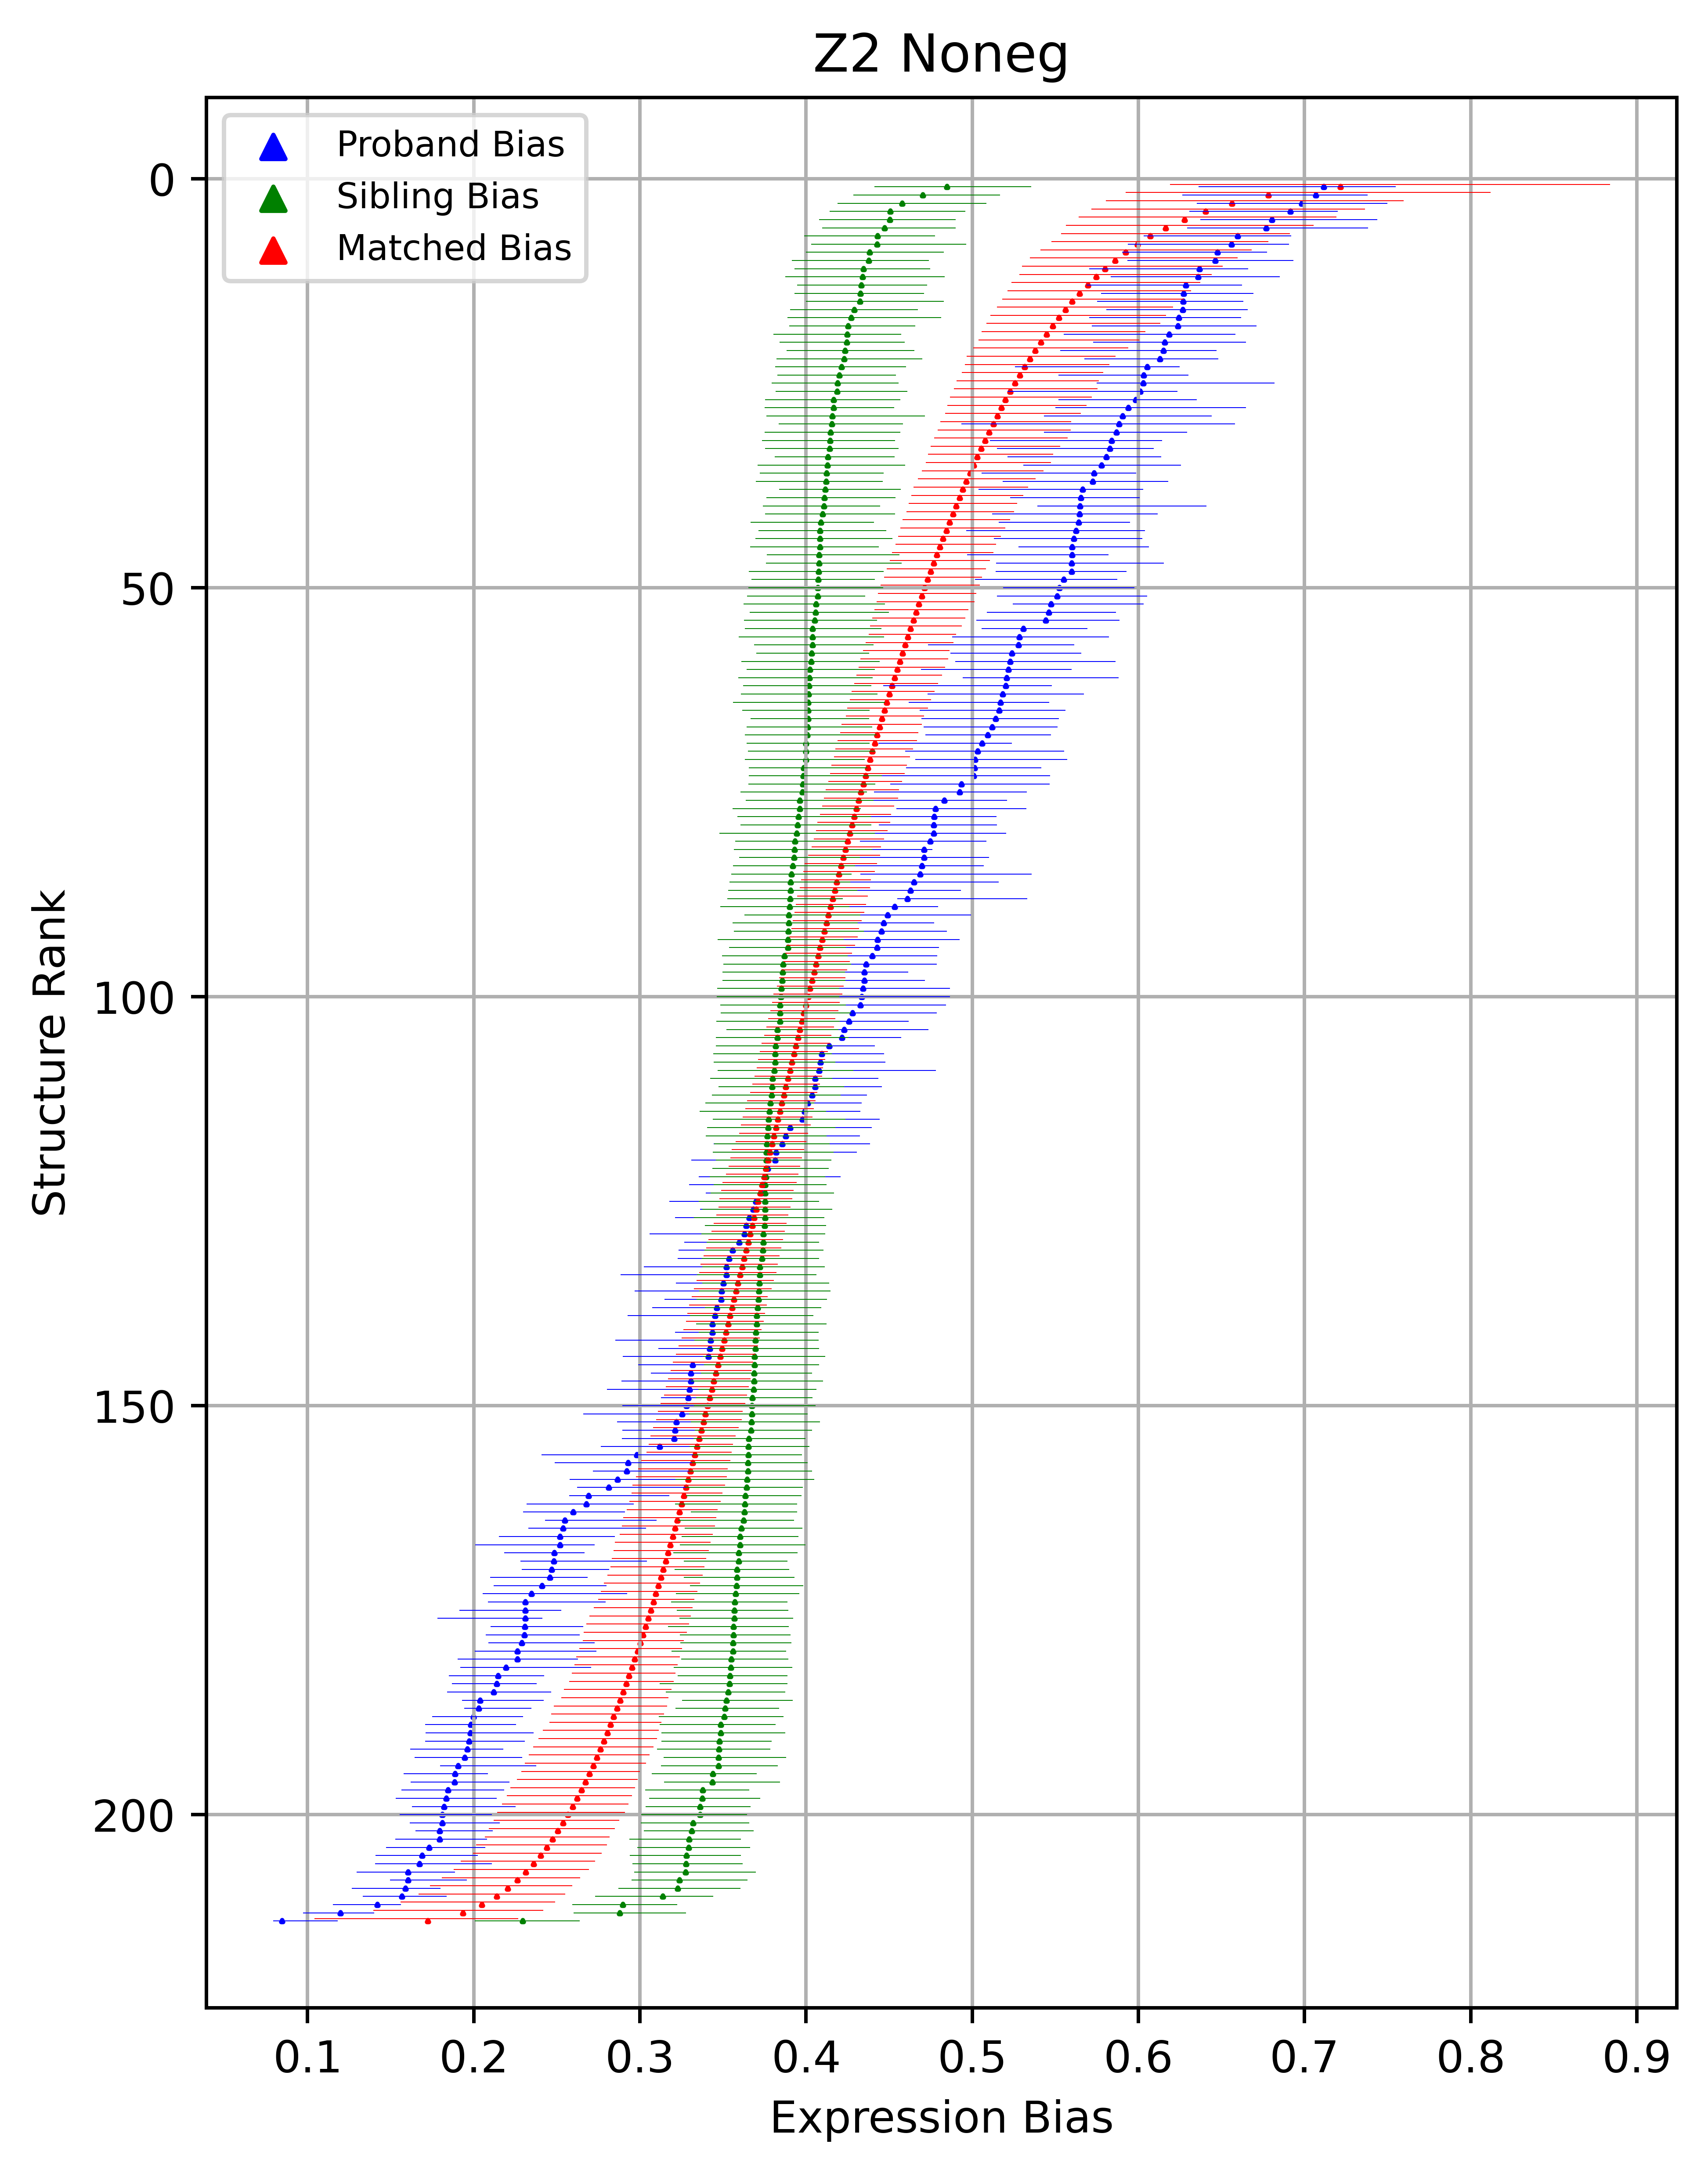

In [238]:
plt = PlotExpBias(_Z2_ng_Bias, Z2_Sib_ng, _Z2_ng_Match_Bias_Rank, "Z2 Noneg")

In [131]:
Z1_qn_ng_Bias = pd.read_csv("dat/bias2/ASD.EW.pLI.z1.qn.ng.csv", index_col="STR")
Z1_qn_ng_Boot_Dir = "dat/Bootstrap_Match/asd.boot.bias.z1_qn.noneg/"
Z1_qn_ng_Match_Dir = "dat/Bootstrap_Match/asd.cont.bias.z1_qn.noneg/"
_Z1_qn_ng_Bias, _Z1_qn_ng_Match_Bias_Rank, _Zq_qn_ng_Match_Bias_STR = LoadBiasData(
    Z1_qn_ng_Bias,Z1_qn_ng_Boot_Dir,Z1_qn_ng_Match_Dir)

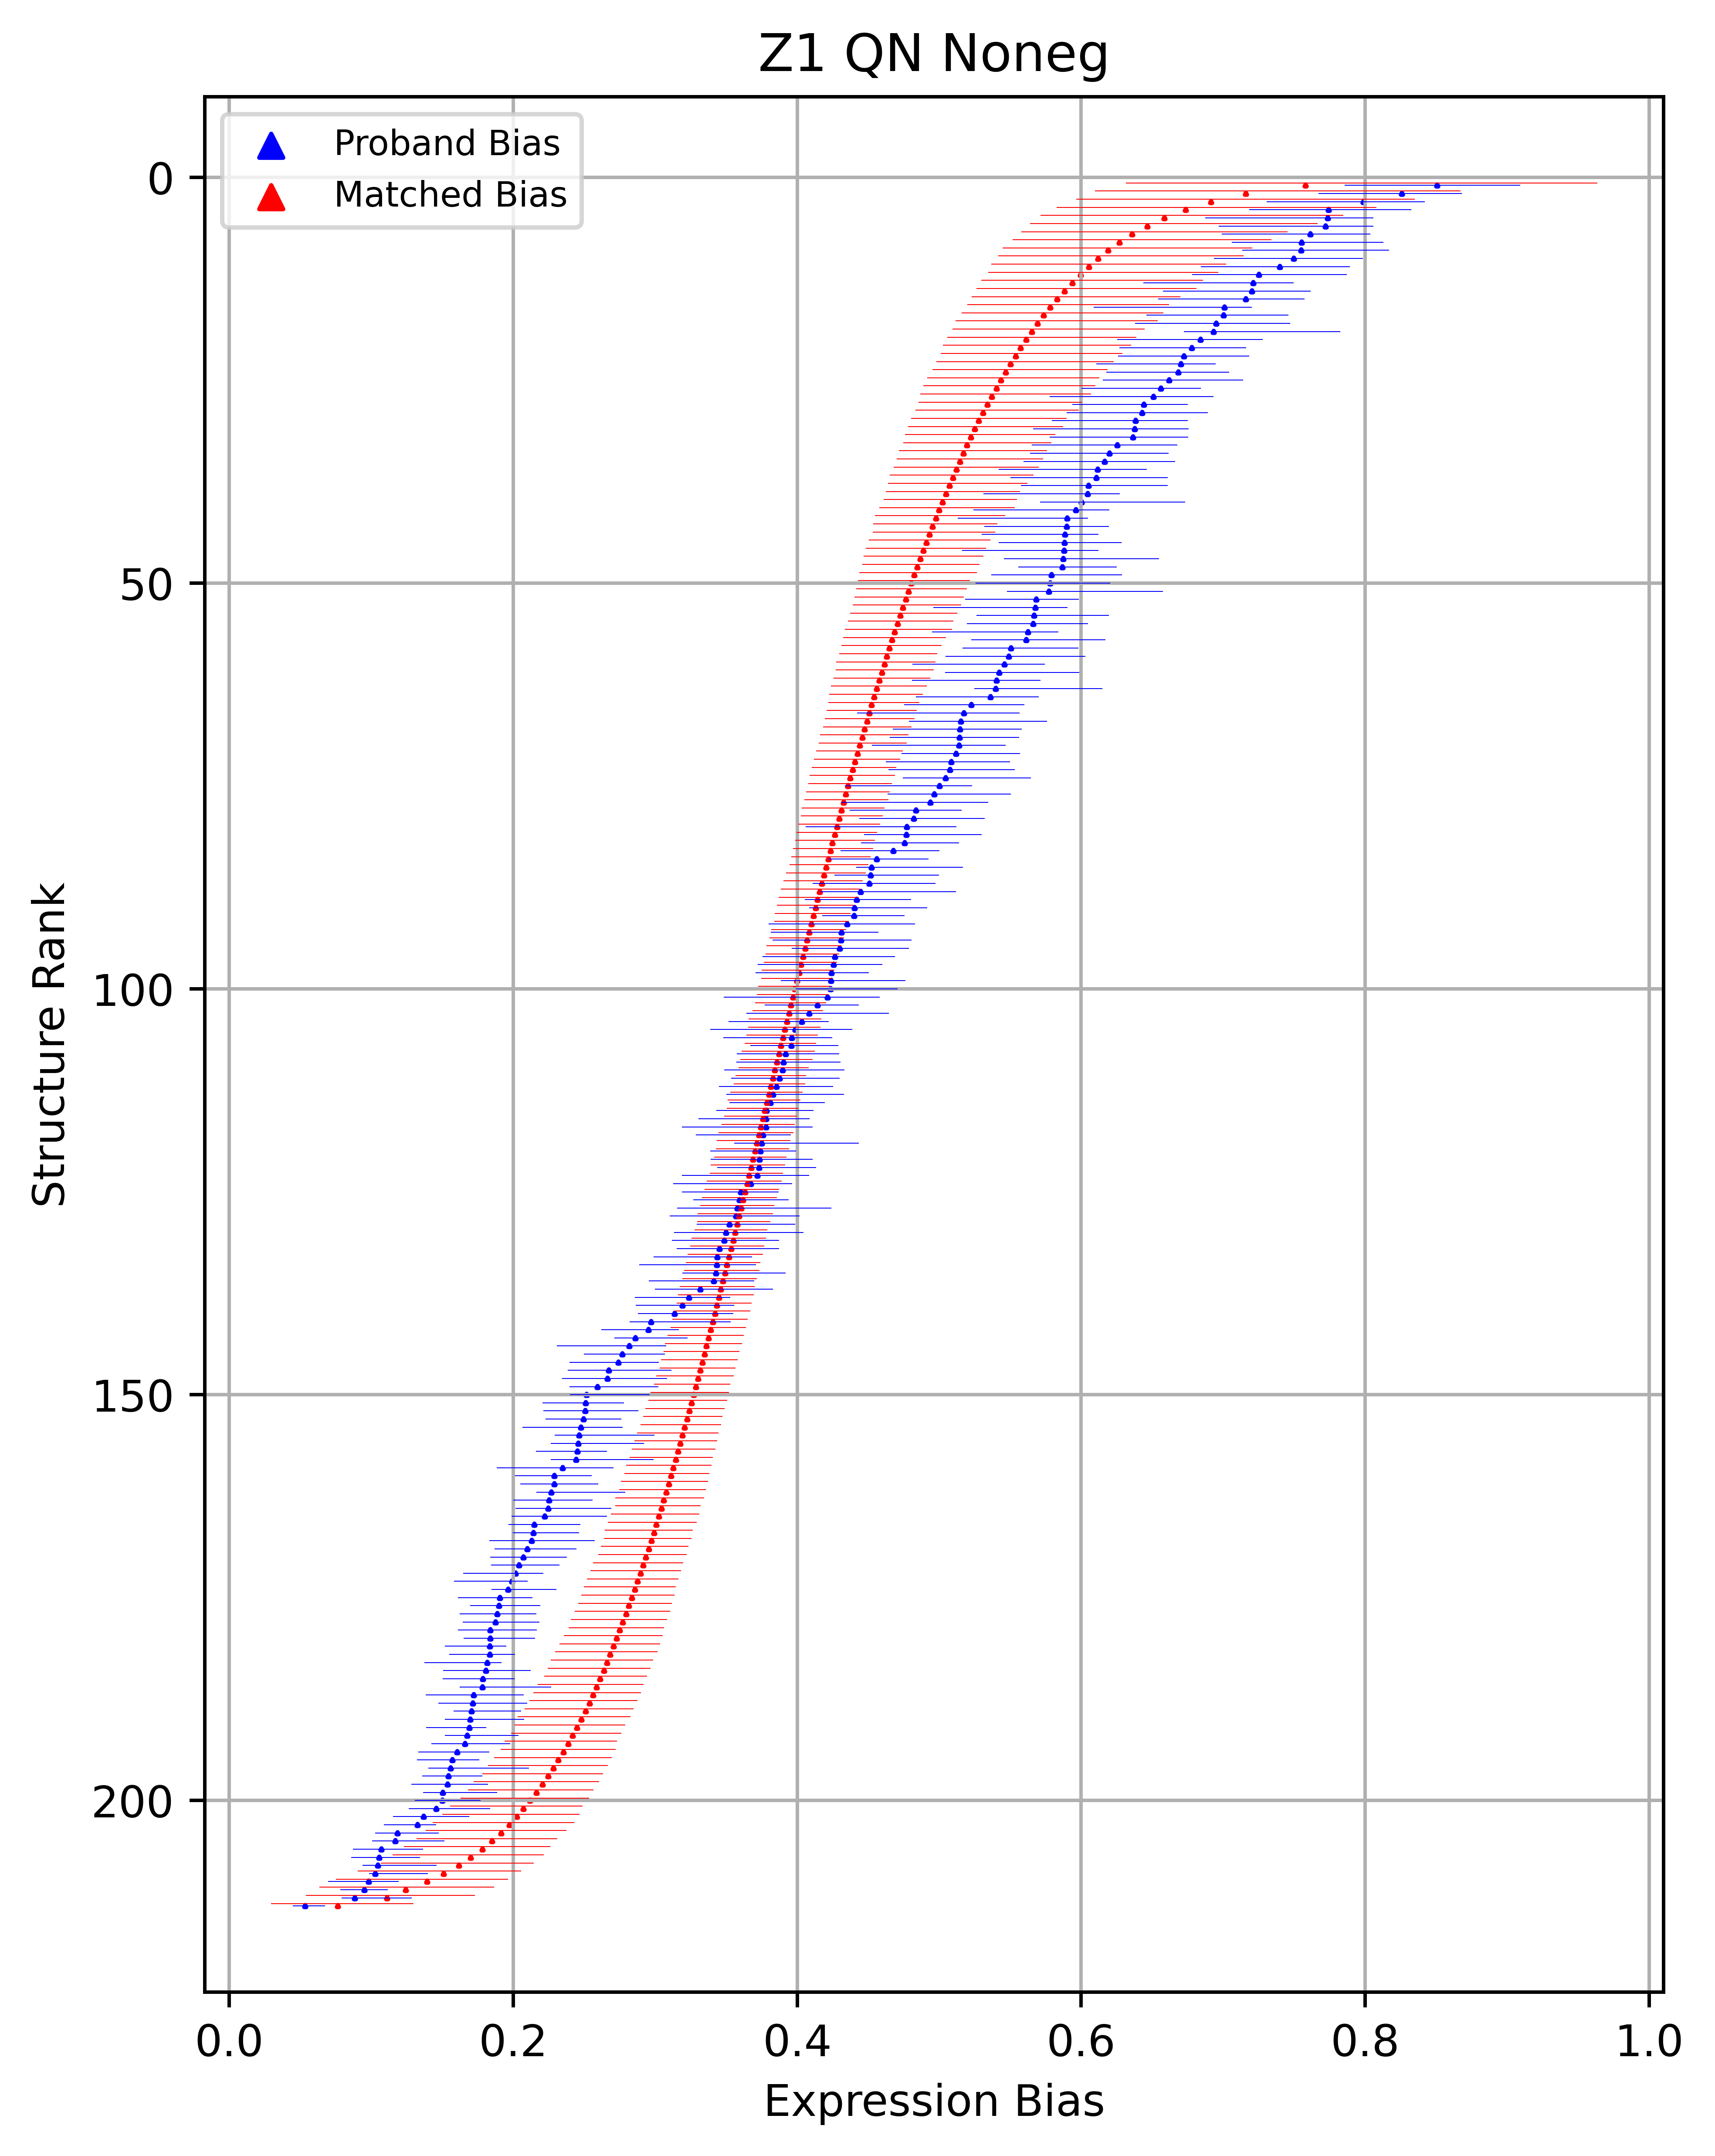

In [148]:
plt = PlotExpBias(_Z1_qn_ng_Bias, _Z1_qn_ng_Match_Bias_Rank, "Z1 QN Noneg")

# Bias vs Cohe

In [240]:
def LoadBiasvsCoheFil(fil):
    fin = open(fil, 'rt')
    l1 = fin.readline().strip().split("\t")
    l2 = fin.readline().strip().split("\t")
    l2 = [int(x) for x in l2]
    l3 = fin.readline().strip().split("\t")
    l3 = [float(x) for x in l3]
    l4 = fin.readline().strip().split("\t")
    l4 = [float(x) for x in l4]
    return l1, l2, l3, l4

In [241]:
# Rand
Rand_Dat = []
for i in range(1,101,1):
    f = "dat/BiasRankCohe/rand_rank/rand.{}.txt".format(i)
    l1,l2,l3,l4 = LoadBiasvsCoheFil(f)
    dat = [l1,l2,l3,l4]
    Rand_Dat.append(dat)

In [251]:
l1,l2,l3,l4 = LoadBiasvsCoheFil("dat/BiasRankCohe/ASD.EW.pLI.z2.rankcohe.txt")
asd_z2_dat = [l1,l2,l3,l4]

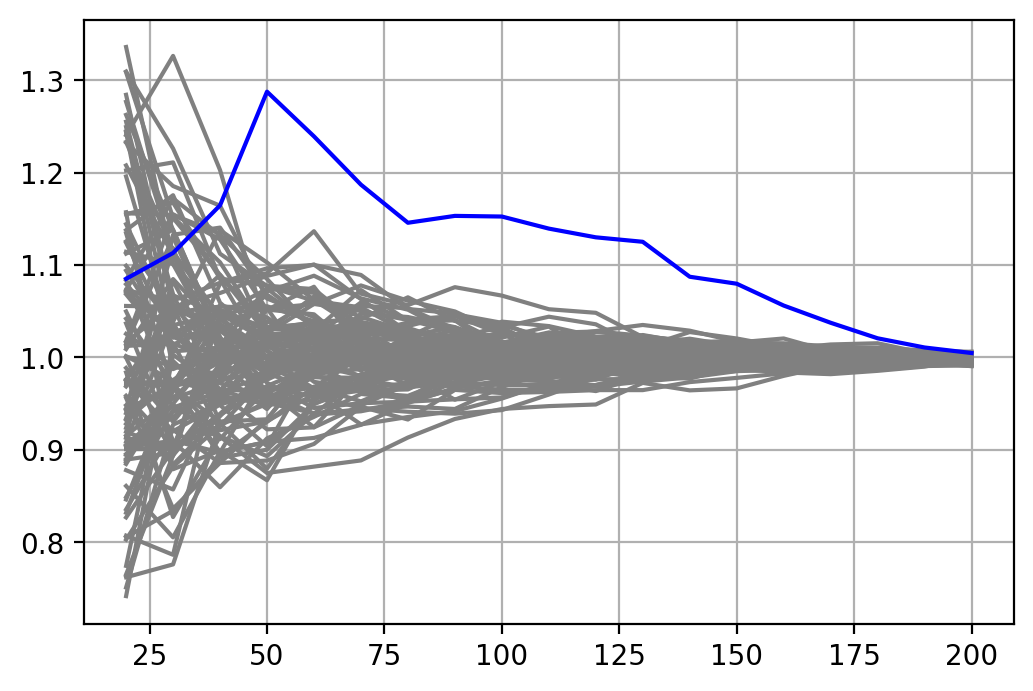

In [255]:
topNs = Rand_Dat[0][1]
fig, ax = plt.subplots(dpi=200)
for i in range(1,100,1):
    Cohes = Rand_Dat[i][2]
    plt.plot(topNs, Cohes, color="grey")
plt.plot(topNs, asd_z2_dat[2], color="blue")
plt.grid(True)

In [264]:
sib_boot_dir = "dat/BiasRankCohe/Sib_boot_z2/"
Sib_Dat = []
for file in os.listdir(sib_boot_dir):
    l1,l2,l3,l4 = LoadBiasvsCoheFil(sib_boot_dir + file)
    if l3[l2.index(50)] > 1.3:
        #print(file)
    dat = [l1,l2,l3,l4]
    Sib_Dat.append(dat)

Sib.107.txt
Sib.129.txt
Sib.138.txt
Sib.157.txt
Sib.188.txt
Sib.253.txt
Sib.26.txt
Sib.34.txt
Sib.345.txt
Sib.367.txt


In [269]:
graph = LoadConnectome2()
graph2 = LoadConnectome2("../dat/allen-mouse-conn/adj_mat_cartesian_distal.csv")

In [271]:
file = "Sib.107.txt"
l1,l2,l3,l4 = LoadBiasvsCoheFil(sib_boot_dir + file)
top_strs = l1[:50]
s1, _ = ScoreSTRSet(graph, top_strs, {})
s2, _ = ScoreSTRSet(graph2, top_strs, {})
print(s1, s2)

0.2785482983269931 0.1853197463944137


In [272]:
l1,l2,l3,l4 = LoadBiasvsCoheFil("dat/BiasRankCohe/ASD.EW.pLI.z2.rankcohe.txt")
top_strs = l1[:50]
s1, _ = ScoreSTRSet(graph, top_strs, {})
s2, _ = ScoreSTRSet(graph2, top_strs, {})
print(s1, s2)

0.3583216229628354 0.33785179406875615


In [ ]:
s1, _ = ScoreSTRSet(graph, top_strs, {})
s2, _ = ScoreSTRSet(graph2, top_strs, {})

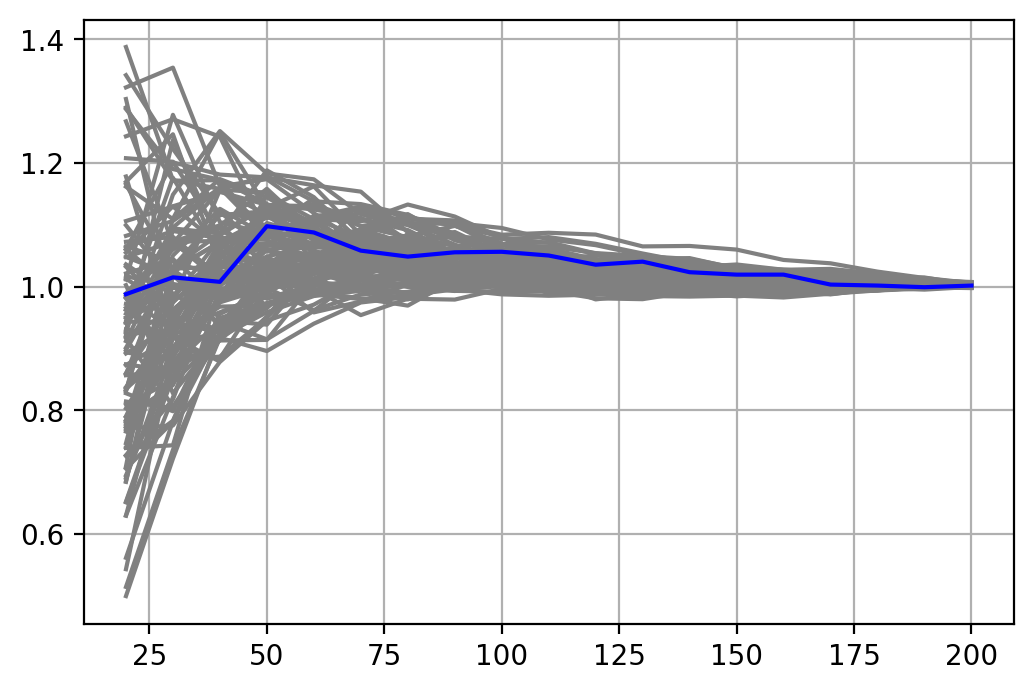

In [350]:
topNs = Rand_Dat[0][1]
fig, ax = plt.subplots(dpi=200)
for i in range(1,100,1):
    Cohes = Sib_Dat[i][2]
    plt.plot(topNs, Cohes, color="grey")
plt.plot(topNs, asd_z2_dat[2], color="blue")
plt.grid(True)

In [405]:
graph = LoadConnectome2()
#graph = LoadConnectome2("../dat/allen-mouse-conn/adj_mat_cartesian_distal.csv")

In [406]:
sib_boot_dir = "dat/BiasRankCohe/Sib_boot_z2/"
Sib_Dat = []
Sib_Cohesivness_Boot = []
for file in os.listdir(sib_boot_dir):
    l1,l2,l3,l4 = LoadBiasvsCoheFil(sib_boot_dir + file)
    topN_cohe = []
    for topN in topNs:
        top_strs = l1[:topN]
        topN_cohe.append(ScoreSTRSet(graph, top_strs, {})[0])
    topN_cohe = np.array(topN_cohe)
    Sib_Cohesivness_Boot.append(topN_cohe)
Sib_Cohesivness_Boot = np.array(Sib_Cohesivness_Boot)

In [407]:
sib_avg = Sib_Cohesivness_Boot.mean(axis=0)
sib_avg

array([0.92839255, 0.87771519, 0.82925918, 0.78208088, 0.73534766,
       0.68712693, 0.64048548, 0.59251439, 0.54621134, 0.50013212,
       0.45414744, 0.40858906, 0.36215021, 0.31583951, 0.27034257,
       0.22379612, 0.17660677, 0.12795103, 0.08335343])

In [408]:
dnv_sim_dir = "dat/bias2/DNV_SM_Z2/"
dnv_sim_Cohesivness_Boot = []
for file in os.listdir(dnv_sim_dir):
    df = pd.read_csv(dnv_sim_dir + file, index_col="STR")
    topN_cohe = []
    for topN in topNs:
        top_strs = df.index.values[:topN]
        topN_cohe.append(ScoreSTRSet(graph, top_strs, {})[0])
    topN_cohe = np.array(topN_cohe)
    dnv_sim_Cohesivness_Boot.append(topN_cohe)
dnv_sim_Cohesivness_Boot = np.array(dnv_sim_Cohesivness_Boot)

In [409]:
dnv_avg = dnv_sim_Cohesivness_Boot.mean(axis=0)
dnv_avg

array([0.93173748, 0.88383212, 0.83714458, 0.79169225, 0.74711353,
       0.70277783, 0.65917158, 0.61568916, 0.57209528, 0.52920318,
       0.48568838, 0.442381  , 0.39788991, 0.35402694, 0.30939146,
       0.26327162, 0.21674308, 0.16905382, 0.11855206])

In [410]:
sub_sib_dir = "dat/Bootstrap_Match/subsampled_sibling/"
sub_sib_Cohesivness_Boot = []
for file in os.listdir(sub_sib_dir):
    df = pd.read_csv(sub_sib_dir + file, index_col="STR")
    topN_cohe = []
    for topN in topNs:
        top_strs = df.index.values[:topN]
        topN_cohe.append(ScoreSTRSet(graph, top_strs, {})[0])
    topN_cohe = np.array(topN_cohe)
    sub_sib_Cohesivness_Boot.append(topN_cohe)
sub_sib_Cohesivness_Boot = np.array(sub_sib_Cohesivness_Boot)
sub_sib_avg = sub_sib_Cohesivness_Boot.mean(axis=0)
sub_sib_avg

array([0.93863952, 0.89440941, 0.85138581, 0.8088564 , 0.76704834,
       0.72564267, 0.68357601, 0.64205206, 0.6000721 , 0.55625384,
       0.5126179 , 0.46836455, 0.42340579, 0.37758681, 0.33033349,
       0.2814085 , 0.23261506, 0.18180613, 0.12773165])

In [411]:
match_boot_dir = "dat/Bootstrap_Match/asd.cont.bias.z2/"
Match_Cohesivness_Boot = []
for file in os.listdir(match_boot_dir):
    df = pd.read_csv(match_boot_dir + file, index_col="STR")
    topN_cohe = []
    for topN in topNs:
        top_strs = df.index.values[:topN]
        topN_cohe.append(ScoreSTRSet(graph, top_strs, {})[0])
    topN_cohe = np.array(topN_cohe)
    Match_Cohesivness_Boot.append(topN_cohe)
Match_Cohesivness_Boot = np.array(Match_Cohesivness_Boot)

In [412]:
mat_avg = Match_Cohesivness_Boot.mean(axis=0)
mat_avg

array([0.94193454, 0.89956588, 0.85844468, 0.81818249, 0.77880705,
       0.73968369, 0.70011828, 0.6600691 , 0.61962035, 0.5797828 ,
       0.53908223, 0.49745554, 0.45453009, 0.41056264, 0.36591356,
       0.31752913, 0.26755555, 0.21254072, 0.15231015])

In [413]:
l1,l2,l3,l4 = LoadBiasvsCoheFil("dat/BiasRankCohe/ASD.EW.pLI.z2.rankcohe.txt")
asd_topN_cohe = []
for topN in topNs:
    top_strs = l1[:topN]
    asd_topN_cohe.append(ScoreSTRSet(graph, top_strs, {})[0])

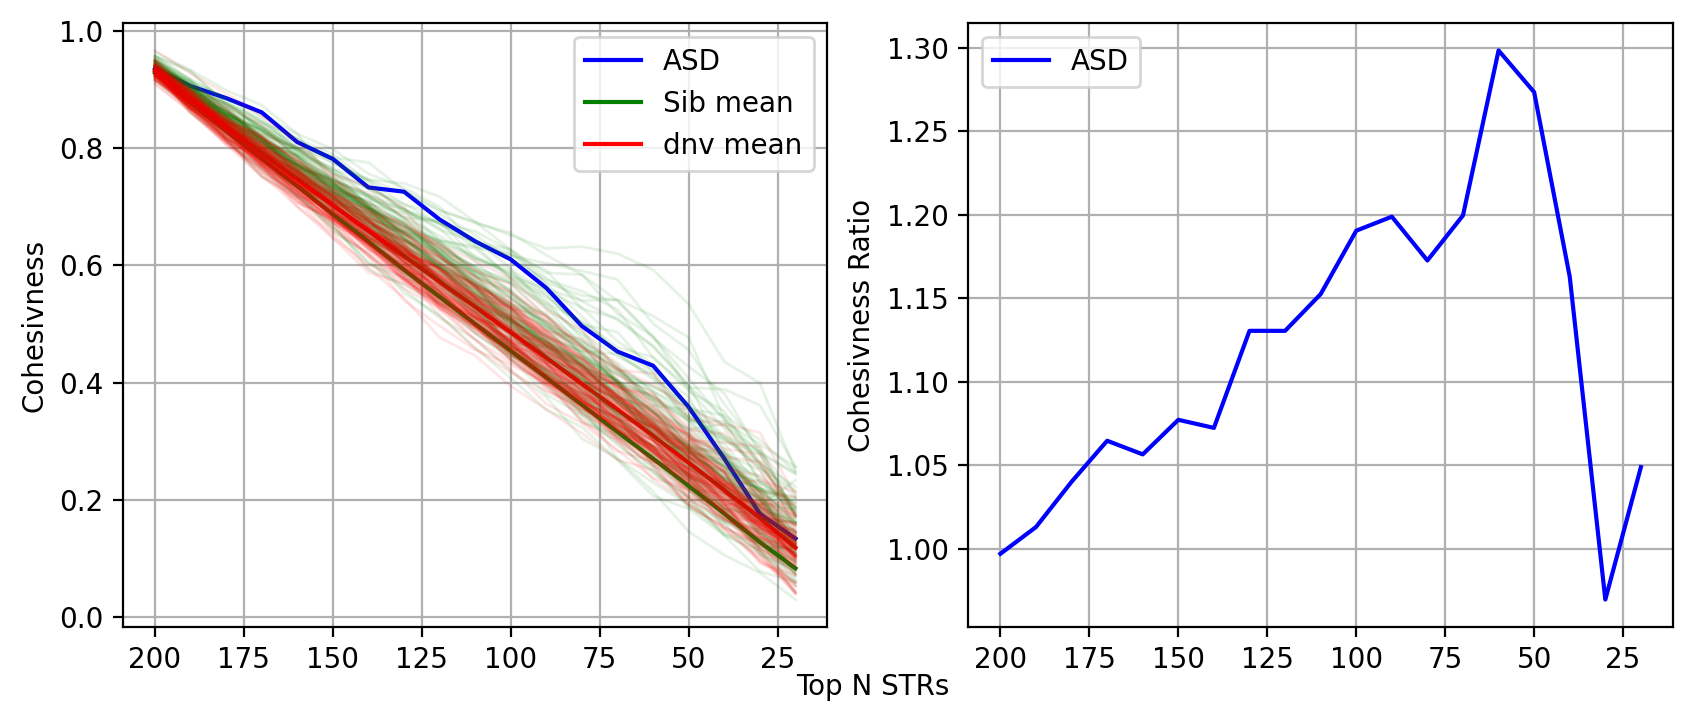

In [414]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(10,4), dpi=200)
ax.plot(topNs, asd_topN_cohe, color="blue", label="ASD")
ax.plot(topNs, sib_avg, color="green", label="Sib mean")
ax.plot(topNs, dnv_avg, color="red", label="dnv mean")
#ax.plot(topNs, (np.array(topNs)/213),  color='black', ls="dashed", label="expect")
for i in range(100):
    ax.plot(topNs, sub_sib_Cohesivness_Boot[i,:], color="green", alpha=0.1, lw=1)
for i in range(100):
    ax.plot(topNs, dnv_sim_Cohesivness_Boot[i,:], color="red", alpha=0.1, lw=1)
ax.invert_xaxis()
ax.legend()

#ax2.plot(topNs, asd_topN_cohe/(np.array(topNs)/213), color="blue", label="ASD")
#ax2.plot(topNs, sib_avg/(np.array(topNs)/213), color="green", label="Sib")
#ax2.plot(topNs, dnv_avg/(np.array(topNs)/213), color="red", label="Match")
ax2.plot(topNs, asd_topN_cohe/sub_sib_avg, color="blue", label="ASD")
#ax2.plot(topNs, sib_avg/dnv_avg, color="green", label="Sib")
ax2.invert_xaxis()


ax2.legend(loc="upper left")
ax.grid(True)
ax2.grid(True)

ax.set_ylabel("Cohesivness")
ax2.set_ylabel("Cohesivness Ratio")
fig.text(0.5, 0.04, 'Top N STRs', ha='center')
plt.savefig("figs/Boot_TopN_Cohesivness.pdf")

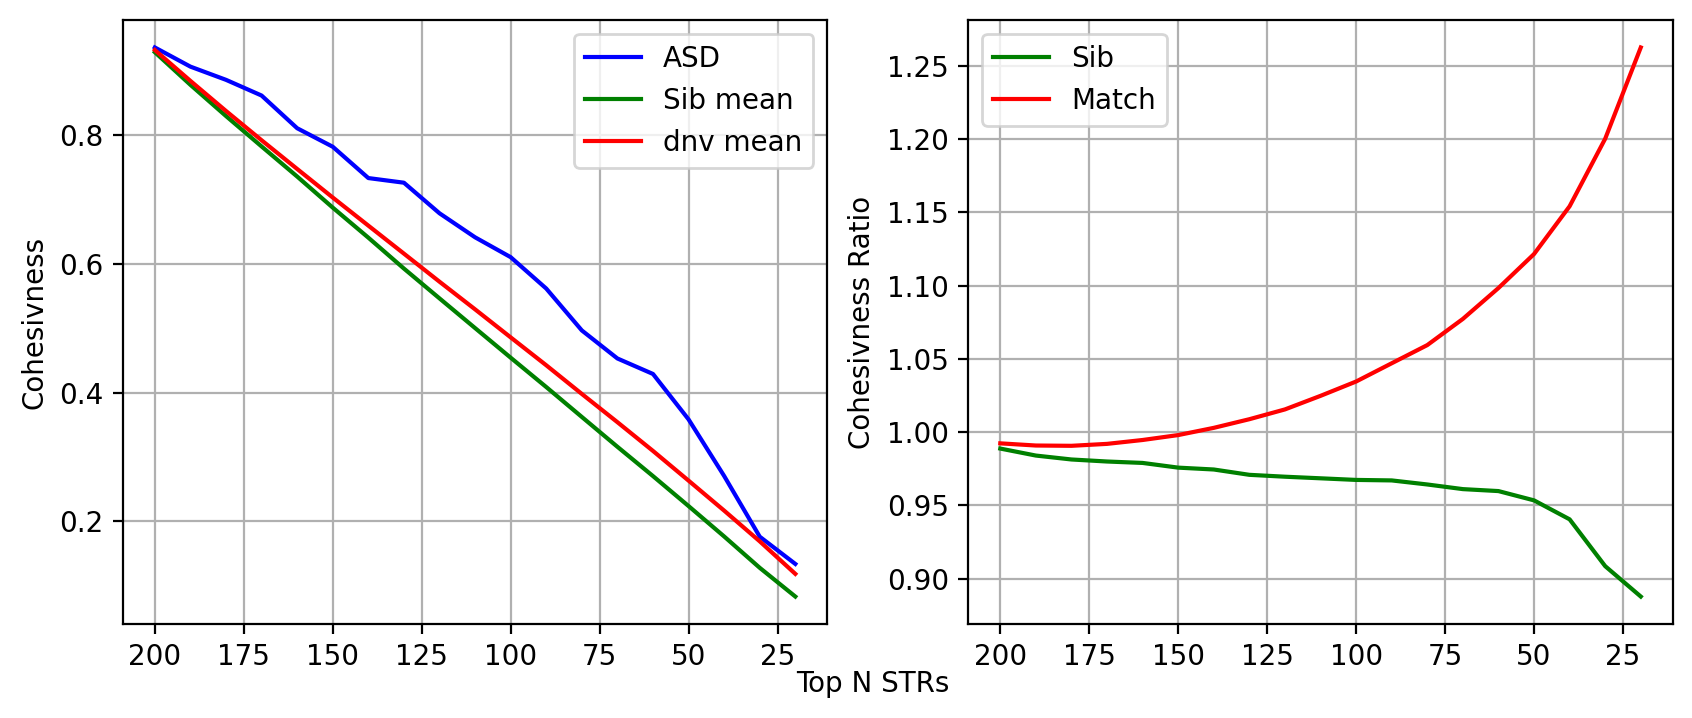

In [415]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(10,4), dpi=200)
ax.plot(topNs, asd_topN_cohe, color="blue", label="ASD")
ax.plot(topNs, sib_avg, color="green", label="Sib mean")
ax.plot(topNs, dnv_avg, color="red", label="dnv mean")
ax.invert_xaxis()
ax.legend()

#ax2.plot(topNs, asd_topN_cohe/(np.array(topNs)/213), color="blue", label="ASD")
ax2.plot(topNs, sib_avg/(np.array(topNs)/213), color="green", label="Sib")
ax2.plot(topNs, dnv_avg/(np.array(topNs)/213), color="red", label="Match")
#ax2.plot(topNs, asd_topN_cohe/sub_sib_avg, color="blue", label="ASD")
#ax2.plot(topNs, sib_avg/dnv_avg, color="green", label="Sib")
ax2.invert_xaxis()


ax2.legend(loc="upper left")
ax.grid(True)
ax2.grid(True)

ax.set_ylabel("Cohesivness")
ax2.set_ylabel("Cohesivness Ratio")
fig.text(0.5, 0.04, 'Top N STRs', ha='center')
plt.savefig("figs/Boot_TopN_Cohesivness.pdf")

No handles with labels found to put in legend.


50


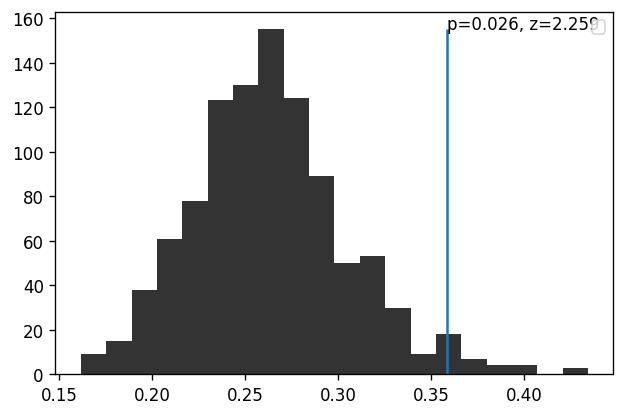

In [387]:
#asd_topN_cohe[-4]
idx = -4
print(topNs[idx])
PlotPermutationP(dnv_sim_Cohesivness_Boot[:, idx],asd_topN_cohe[idx])

No handles with labels found to put in legend.


50


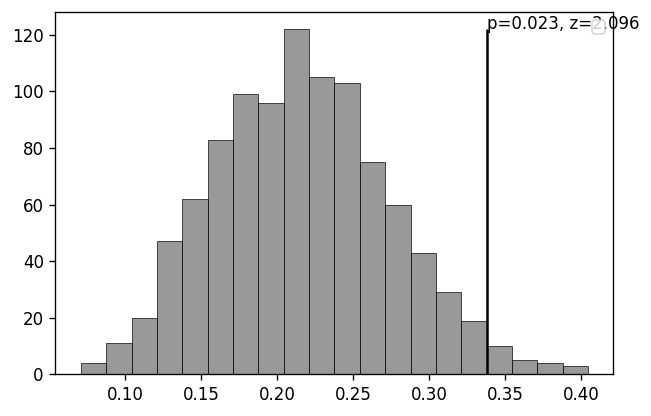

In [403]:
idx = -4
print(topNs[idx])
PlotPermutationP(sub_sib_Cohesivness_Boot[:, idx],asd_topN_cohe[idx])

In [ ]:
graph = LoadConnectome2()

In [419]:
boot_asd_dir = "dat/Bootstrap_Match/asd.boot.bias.z2/"
boot_asd_Cohesivness = []
for file in os.listdir(boot_asd_dir):
    if not file.startswith("bootstrap"):
        continue
    df = pd.read_csv(boot_asd_dir + file, index_col="STR")
    topN_cohe = []
    for topN in topNs:
        top_strs = df.index.values[:topN]
        topN_cohe.append(ScoreSTRSet(graph, top_strs, {})[0])
    topN_cohe = np.array(topN_cohe)
    boot_asd_Cohesivness.append(topN_cohe)
boot_asd_Cohesivness = np.array(boot_asd_Cohesivness)

In [421]:
boot_sib_dir = "dat/Bootstrap_Match/Sib.boot.Z2.bias/"
boot_sib_Cohesivness = []
for file in os.listdir(boot_sib_dir):
    df = pd.read_csv(boot_sib_dir + file, index_col="STR")
    topN_cohe = []
    for topN in topNs:
        top_strs = df.index.values[:topN]
        topN_cohe.append(ScoreSTRSet(graph, top_strs, {})[0])
    topN_cohe = np.array(topN_cohe)
    boot_sib_Cohesivness.append(topN_cohe)
boot_sib_Cohesivness = np.array(boot_sib_Cohesivness)

In [427]:
asd_err = boot_asd_Cohesivness.std(axis=0)
sib_err = boot_sib_Cohesivness.std(axis=0)
cohe_exp = np.array((np.array(topNs)/213))

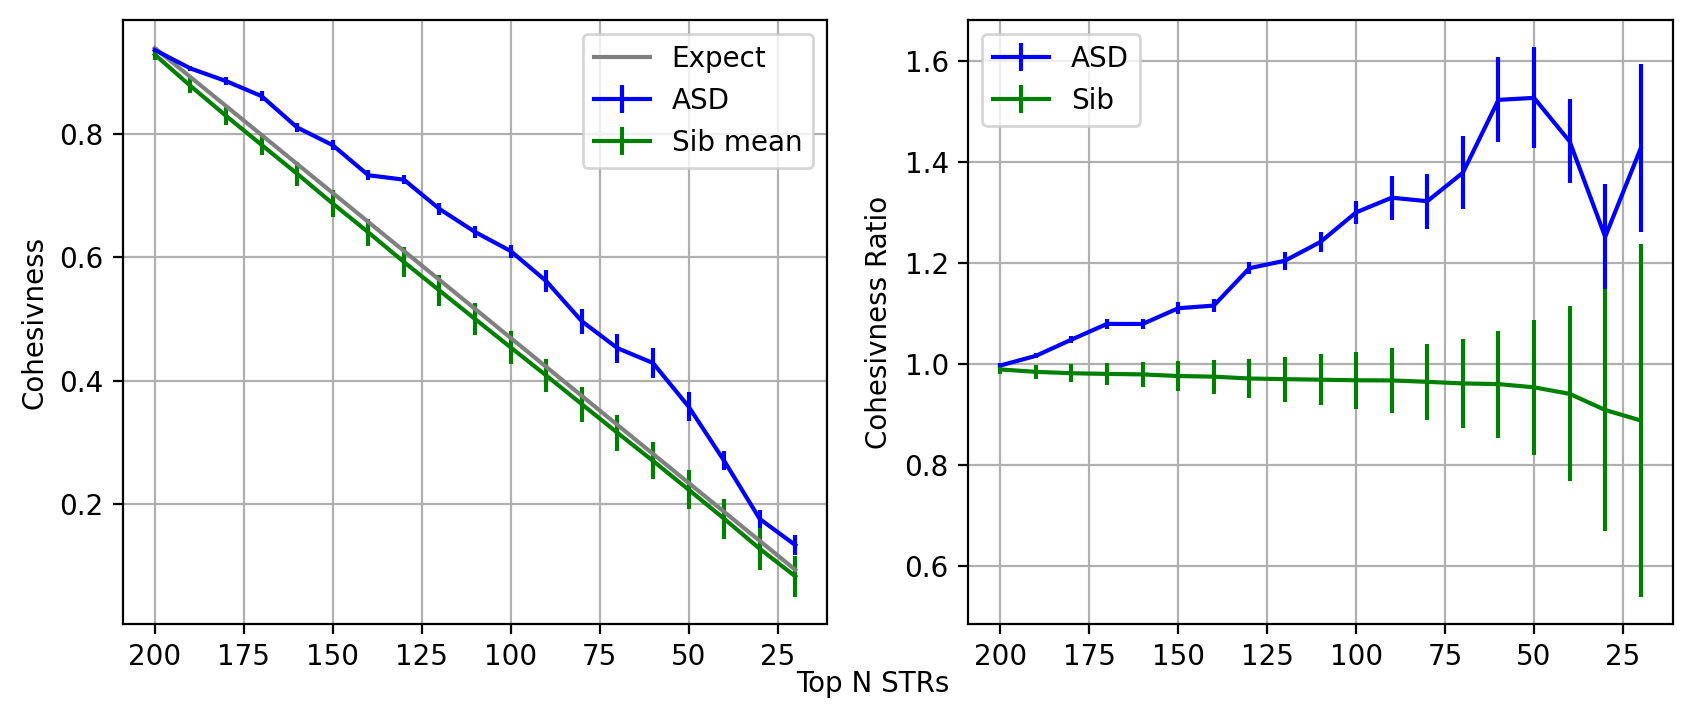

In [449]:
fig, (ax, ax2) = plt.subplots(1,2, figsize=(10,4), dpi=200)
ax.errorbar(topNs, asd_topN_cohe, yerr=asd_err, color="blue", label="ASD")
ax.errorbar(topNs, sib_avg, yerr=sib_err, color="green", label="Sib mean")
ax.plot(topNs, cohe_exp, color="grey", label="Expect")
#ax.plot(topNs, (np.array(topNs)/213),  color='black', ls="dashed", label="expect")

ax.invert_xaxis()
ax.legend()

ax2.errorbar(topNs, asd_topN_cohe/cohe_exp, yerr=asd_err/cohe_exp ,color="blue", label="ASD")
ax2.errorbar(topNs, sib_avg/cohe_exp, yerr=sib_err/cohe_exp, color="green", label="Sib")
ax2.invert_xaxis()


ax2.legend(loc="upper left")
ax.grid(True)
ax2.grid(True)

ax.set_ylabel("Cohesivness")
ax2.set_ylabel("Cohesivness Ratio")
fig.text(0.5, 0.04, 'Top N STRs', ha='center')
plt.savefig("figs/Boot_TopN_Cohesivness.pdf")

50


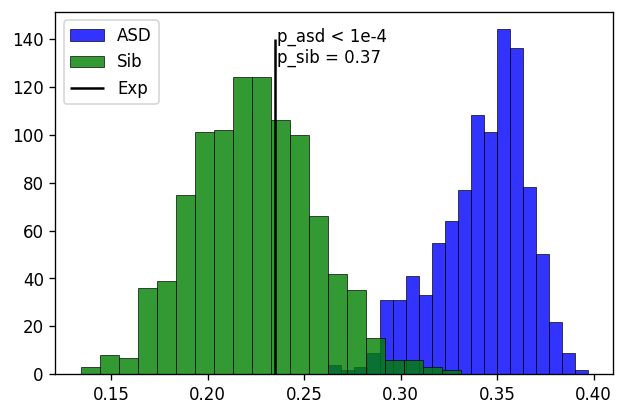

In [456]:
idx = -4
print(topNs[idx])
plt.figure(dpi=120)
plt.hist(boot_asd_Cohesivness[:, idx], bins=20, histtype = "barstacked", align = 'mid', 
         facecolor='blue', alpha=0.8, label="ASD", edgecolor="black", linewidth=0.5)
plt.hist(boot_sib_Cohesivness[:, idx], bins=20, histtype = "barstacked", align = 'mid', 
         facecolor='green', alpha=0.8, label="Sib", edgecolor="black", linewidth=0.5)
plt.vlines(x=topNs[idx]/213, ymin=0, ymax=140, label="Exp", color="black")
plt.text(x=topNs[idx]/213 + 0.001 , y=130, s="p_asd < 1e-4\np_sib = 0.37")
plt.legend()

In [ ]:
p(50) = 0.026;  p(60) = 0.012

In [ ]:
p(50) = 0.002;  p(60) = 0.002

# Anly Z1 and Z2

##### 0. Construct Z2 matrix

In [4]:
Z2_DIR = "dat/Z2scores/"
DFs = []
for file in os.listdir(Z2_DIR):
    df = pd.read_csv(Z2_DIR+file, index_col=0)
    DFs.append(df)

In [24]:
Z2DF = pd.concat(DFs)
Z2DF.to_csv("dat/z2.all.genes.str.mat.csv")

##### correlation of STR

In [21]:
def comparebias(DF1, DF2, STR, genes=[]):
    X, Y = [], []
    if len(genes) == 0:
        genes = DF1.index.values
    for idx in genes:
        try:
            x = DF1.loc[idx, STR]
            y = DF2.loc[idx, STR]
            if x == x and y==y:
                X.append(x)
                Y.append(y)
        except:
            continue
    return pearsonr(X,Y)

In [13]:
Rs = []
for STR in Z2DF.columns.values:
    r,p = comparebias(Z2DF, ExpZscoreMat, STR)
    Rs.append(r)

(array([ 4.,  0.,  5., 10., 11., 13., 17., 47., 51., 55.]),
 array([0.95409976, 0.95838778, 0.9626758 , 0.96696382, 0.97125185,
        0.97553987, 0.97982789, 0.98411591, 0.98840393, 0.99269195,
        0.99697998]),
 <BarContainer object of 10 artists>)

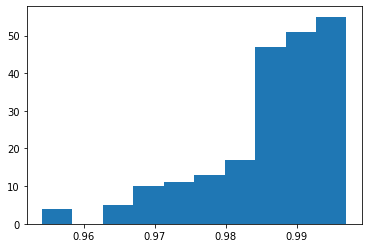

In [15]:
plt.hist(Rs)

In [18]:
# Among ASD genes
Spark_Meta_2stage = pd.read_excel("../dat/genes/asd/TabS_DenovoWEST_Stage1+2.xlsx",
                           skiprows=2, sheet_name="TopDnEnrich")
Spark_Meta_ExomeWide = Spark_Meta_2stage[Spark_Meta_2stage["pDenovoWEST_Meta"]<=1.3e-6]

In [19]:
Spark_Meta_ExomeWide

GeneID  EntrezID   HGNC  CytoBand  ExACpLI   LoFOvsE  LOEUF  \
0    ENSG00000143442     23126   POGZ    1q21.3        1  0.045859  0.119   
1    ENSG00000169057      4204  MECP2      Xq28  0.69809  0.085755  0.407   
2    ENSG00000136531      6326  SCN2A    2q24.3        1  0.060487  0.127   
3    ENSG00000171862      5728   PTEN  10q23.31  0.97551  0.240930  0.507   
4    ENSG00000173575      1106   CHD2   15q26.1        1  0.027031  0.070   
..               ...       ...    ...       ...      ...       ...    ...   
97   ENSG00000158321     26053  AUTS2   7q11.22  0.99619  0.134640  0.253   
115  ENSG00000108557     10743   RAI1   17p11.2  0.99914  0.036788  0.116   
116  ENSG00000103197      7249   TSC2   16p13.3        1  0.023406  0.074   
120  ENSG00000163625     23001  WDFY3   4q21.23        1  0.037990  0.071   
144  ENSG00000080603     10847  SRCAP   16p11.2        1  0.048453  0.096   

     LOEUFbin  SynOvsE      sHet  ... AllExpected_NDD pAllEnrich_NDD  \
0           0  0.97057  0.214955  ...        0.934605            0.0   
1           1  2.02820  0.088203  ...         0.18052            0.0   
2           0  1.00840  0.257771  ...        1.884194            0.0   
3           2  1.01830   0.12616  ...        0.365588            0.0   
4           0  0.95212  0.172054  ...        1.615307            0.0   
..        ...      ...       ...  ...             ...            ...   
97          0  1.08100  0.067271  ...        0.958668            0.0   
115         0  1.16930  0.012328  ...        1.153482            0.0   
116         0  1.48200  0.096255  ...        1.148531       0.000036   
120         0  1.01720  0.149233  ...        2.470801        0.00852   
144         0  1.14530  0.082309  ...        1.896978            0.0   

    MisObserved_NDD MisExpected_NDD pMisEnrich_NDD MisEvents_NDD MisDist_NDD  \
0              2.44        0.601588        0.00168             9       550.2   
1              9.24        0.124697            0.0            44       131.4   
2             34.18        1.474638            0.0            58      1106.6   
3              14.1        0.273796            0.0            20       178.5   
4              8.78         1.11824            0.0            13       410.8   
..              ...             ...            ...           ...         ...   
97             0.63        0.719486              1             3       698.6   
115            1.05        0.858245           0.39             5        1580   
116            1.89        0.826876           0.02             9      1740.2   
120            1.81         1.61981           0.37             6        2851   
144            1.47        1.317775           0.44             7      2910.5   

    pMisCluster_NDD  pMisComb_NDD  pDenovoWEST_NDD  
0              0.03      0.000571              0.0  
1               0.0           0.0              0.0  
2           0.00247           0.0              0.0  
3           0.00542           0.0              0.0  
4          0.000024           0.0              0.0  
..              ...           ...              ...  
97              0.3          0.66              0.0  
115            0.67          0.61              0.0  
116            0.99           0.1         0.000036  
120            0.66          0.59          0.00852  
144            0.87          0.75              0.0  

[61 rows x 67 columns]

(array([  1.,   1.,   1.,   1.,   2.,   9.,  11.,  22.,  54., 111.]),
 array([0.95677257, 0.96098444, 0.9651963 , 0.96940817, 0.97362003,
        0.97783189, 0.98204376, 0.98625562, 0.99046749, 0.99467935,
        0.99889121]),
 <BarContainer object of 10 artists>)

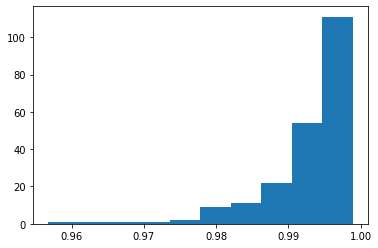

In [23]:
Rs_asd = []
for STR in Z2DF.columns.values:
    r,p = comparebias(Z2DF, ExpZscoreMat, STR, Spark_Meta_ExomeWide["EntrezID"].values)
    Rs_asd.append(r)
plt.hist(Rs_asd)

##### distribution of Z and ASD Zs

In [25]:
Z1Mat = ExpZscoreMat
Z2Mat = Z2DF

In [27]:
#Region = "Prelimbic_area"
topSpecs = []
for g in Z1Mat.index.values:
    exps = [x for x in Z1Mat.loc[g, :].values if x == x]
    exps.sort()
    top5_spec = np.mean(exps[-5:])
    topSpecs.append(top5_spec)

In [33]:
topASDSpecs = []
for g in Spark_Meta_ExomeWide["EntrezID"].values:
    try:
        exps = [x for x in Z1Mat.loc[g, :].values if x == x]
    except:
        continue
    exps.sort()
    top5_spec = np.mean(exps[-5:])
    topASDSpecs.append(top5_spec)

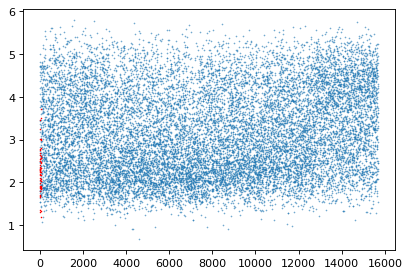

In [36]:
plt.scatter(np.arange(len(topSpecs)), topSpecs, s=0.1)
plt.scatter(np.arange(len(topASDSpecs)), topASDSpecs, s=0.2, color="red", marker="x")

In [37]:
print(np.mean(topSpecs), np.mean(topASDSpecs))

3.1378320300292235 2.2924386920901116


In [60]:
def topNSpect(Mat, GeneSet, topN=5):
    topSpecs = []
    topSelectSpec = []
    idx_all = []
    idx_select = []
    for i, g in enumerate(Mat.index.values):
        exps = [x for x in Mat.loc[g, :].values if x == x]
        exps.sort()
        top5_spec = np.mean(exps[-topN:])
        topSpecs.append(top5_spec)
        idx_all.append(i)
        if g in GeneSet:
            topSelectSpec.append(top5_spec)
            idx_select.append(i)
    return idx_all, topSpecs, idx_select, topSelectSpec

def topNSpecVsExpLevel(MatSpec, MatLevel, GeneSet, topN=5):
    expLevel = []
    topSpecs = []
    topSelectSpec = []
    expLevelSelect = []
    idx_all = []
    idx_select = []
    for i, g in enumerate(MatSpec.index.values):
        spec = [x for x in MatSpec.loc[g, :].values if x == x]
        spec.sort()
        top5_spec = np.mean(spec[-topN:])
        topSpecs.append(top5_spec)
        idx_all.append(i)
        exp = MatLevel.loc[g, :].mean()
        expLevel.append(exp)
        if g in GeneSet:
            topSelectSpec.append(top5_spec)
            idx_select.append(i)
            expLevelSelect.append(exp)
    return idx_all, topSpecs, expLevel, idx_select, topSelectSpec, expLevelSelect

3.1378320300292235 2.292438692090111


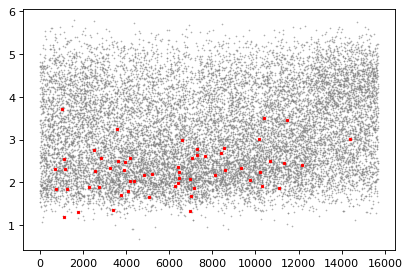

In [86]:
GeneSet = set(Spark_Meta_ExomeWide["EntrezID"].values)
idx_all, topSpecs, expLevel, idx_select, topSelectSpec, expLevelSelect = topNSpecVsExpLevel(Z1Mat, ExpMat, GeneSet, topN=5)
plt.scatter(idx_all, topSpecs, color="grey", s=0.1)
plt.scatter(idx_select, topSelectSpec, s=5, color="red", marker="x")
print(np.mean(topSpecs), np.mean(topSelectSpec))

SpearmanrResult(correlation=-0.6408478091781178, pvalue=7.892754840126564e-08)


Text(0, 0.5, 'Z1')

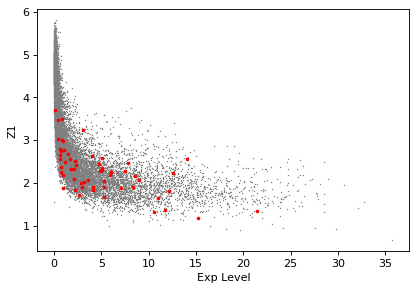

In [87]:
plt.scatter(expLevel, topSpecs, s=0.1, color="grey", marker="x")
plt.scatter(expLevelSelect, topSelectSpec, s=5, color="red", marker="o")
print(spearmanr(expLevelSelect, topSelectSpec))
plt.xlabel("Exp Level")
plt.ylabel("Z1")

3.05043033892496 2.266996834576874


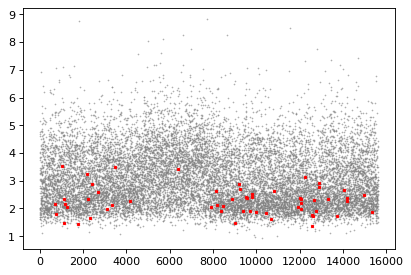

In [154]:
GeneSet = set(Spark_Meta_ExomeWide["EntrezID"].values)
idx_all, topSpecs, expLevel, idx_select, topSelectSpec, expLevelSelect = topNSpecVsExpLevel(Z2Mat, ExpMat, GeneSet, topN=5)
plt.scatter(idx_all, topSpecs, s=0.1, color="grey")
plt.scatter(idx_select, topSelectSpec, s=5, color="red", marker="x")
print(np.mean(topSpecs), np.mean(topSelectSpec))

In [155]:
sibling_genes = pd.read_csv("dat/sibling_match.csv", index_col=0).index.values
idx_all, topSpecs, expLevel, idx_select2, topSelectSpec2, expLevelSelect2 = topNSpecVsExpLevel(
    Z2Mat, ExpMat, sibling_genes, topN=5)

In [165]:
def MoveingAvg2(Percents, Mut_Den, l): 
    res = []
    last_v = 0
    for i, v in enumerate(l[:]):
        res.append([])
        for j, percent in enumerate(Percents):
            if percent > last_v and percent <= v:
                res[i].append(Mut_Den[j])
        last_v = v
    return res

In [169]:
l = np.arange(0, 40, 5)
res = MoveingAvg2(expLevelSelect, topSelectSpec, l)
res2 = MoveingAvg2(expLevelSelect2, topSelectSpec2, l)

In [186]:
def eeee(expLevelSelect, topSelectSpec, expLevelSelect2, topSelectSpec2, cutoff=1):
    xx1, xx2 = [], []
    yy1, yy2 = [], []
    for level, bias in zip(expLevelSelect, topSelectSpec):
        if level > cutoff:
            xx2.append(bias)
        else:
            xx1.append(bias)
    for level, bias in zip(expLevelSelect2, topSelectSpec2):
        if level > cutoff:
            yy2.append(bias)
        else:
            yy1.append(bias)
    print(np.mean(topSelectSpec), np.mean(xx1), np.mean(xx2))
    print(np.mean(topSelectSpec2), np.mean(yy1), np.mean(yy2))
eeee(expLevelSelect, topSelectSpec, expLevelSelect2, topSelectSpec2, cutoff=1)

2.266996834576874 2.793989070235078 2.095417967153273
2.961312675728151 3.6315399386921654 2.1949286105830046


SpearmanrResult(correlation=-0.6680062224526835, pvalue=1.3724882155085318e-08)


/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Expression Bias')

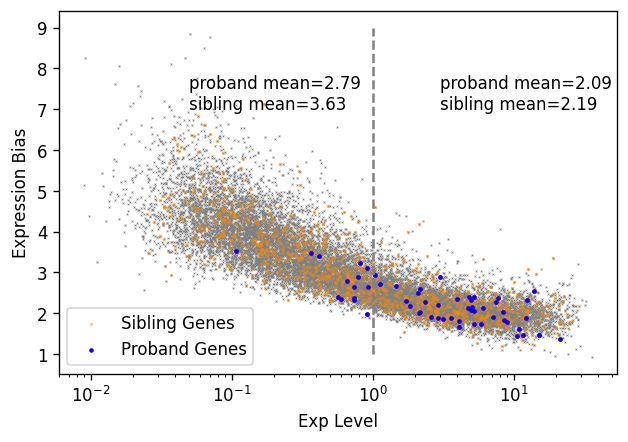

In [836]:
fig, ax = plt.subplots(dpi=120)
ax.scatter(expLevel, topSpecs, s=0.1, color="grey", marker="x")
ax.scatter(expLevelSelect, topSelectSpec, s=3, color="red", marker="o")
ax.scatter(expLevelSelect2, topSelectSpec2, s=2, color="darkorange", marker="o", alpha=0.3, 
            label="Sibling Genes")
ax.scatter(expLevelSelect, topSelectSpec, s=3, color="blue", marker="o", 
            label="Proband Genes")
#plt.plot(l, res, color="red")
#plt.plot(l, res2, color="blue")
ax.annotate(xy=(0.05,7), s="proband mean=2.79\nsibling mean=3.63")
ax.annotate(xy=(3,7), s="proband mean=2.09\nsibling mean=2.19")
ax.vlines(ymin=1, ymax=9, x=1, color="grey", ls="dashed")
print(spearmanr(expLevelSelect, topSelectSpec))
ax.set_xlabel("Exp Level")
ax.set_xscale('log')
plt.legend(loc="lower left")
ax.set_ylabel("Expression Bias")

3.1378320300292235 2.292438692090111


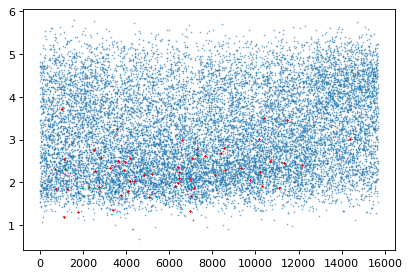

In [50]:
GeneSet = set(Spark_Meta_ExomeWide["EntrezID"].values)
idx_all, topSpecs, idx_select, topSelectSpec = topNSpect(Z1Mat, GeneSet, topN=5)
plt.scatter(idx_all, topSpecs, s=0.1)
plt.scatter(idx_select, topSelectSpec, s=1, color="red", marker="x")
print(np.mean(topSpecs), np.mean(topSelectSpec))

4.203061842263978 2.812113859611011


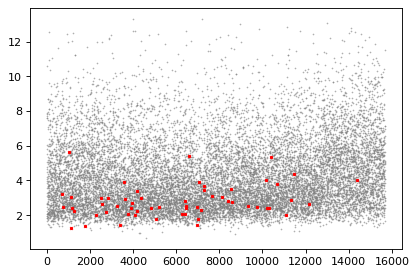

In [78]:
idx_all, topSpecs, idx_select, topSelectSpec = topNSpect(Z1Mat, GeneSet, topN=1)
plt.scatter(idx_all, topSpecs, s=0.1, color="grey")
plt.scatter(idx_select, topSelectSpec, s=5, color="red", marker="x")
print(np.mean(topSpecs), np.mean(topSelectSpec))

1.3584188933520351 1.3151789019631146


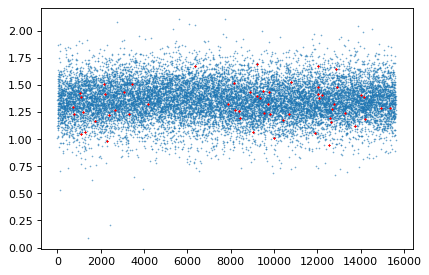

In [56]:
idx_all, topSpecs, idx_select, topSelectSpec = topNSpect(Z2Mat, GeneSet, topN=50)
plt.scatter(idx_all, topSpecs, s=0.1)
plt.scatter(idx_select, topSelectSpec, s=1, color="red", marker="x")
print(np.mean(topSpecs), np.mean(topSelectSpec))

3.985065191851969 2.691383186262775


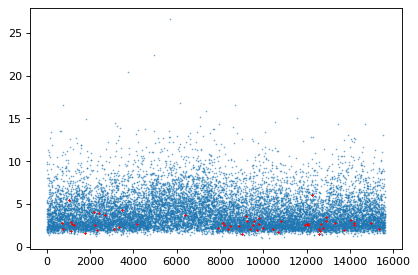

In [53]:
idx_all, topSpecs, idx_select, topSelectSpec = topNSpect(Z2Mat, GeneSet, topN=1)
plt.scatter(idx_all, topSpecs, s=0.1)
plt.scatter(idx_select, topSelectSpec, s=1, color="red", marker="x")
print(np.mean(topSpecs), np.mean(topSelectSpec))

# Pvalue for Zmean from sib

In [71]:
EFFECTS = []
for i in range(1000):
    tmp = ssc_sib.sample(n=101)
    Sib_sample101 = sibling_gene_weight(tmp)
    Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat, Sib_sample101, Method=1)
    effect = np.array(Sib_avgZ1["EFFECT"].values)
    EFFECTS.append(effect)
EFFECTS = np.array(EFFECTS)

In [73]:
np.save("dat/bias/effects_sib.nparr", EFFECTS)

In [75]:
EFFECTS.shape

(1000, 213)

(array([  4.,  23.,  66., 168., 272., 256., 135.,  53.,  18.,   5.]),
 array([-0.03107105, -0.0233376 , -0.01560414, -0.00787069, -0.00013723,
         0.00759623,  0.01532968,  0.02306314,  0.0307966 ,  0.03853005,
         0.04626351]),
 <a list of 10 Patch objects>)

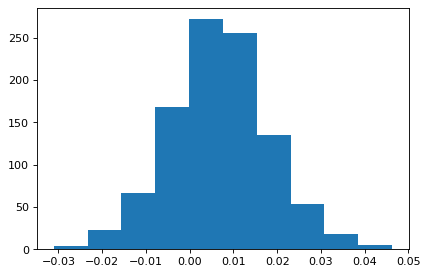

In [90]:
plt.hist(EFFECTS[:, 100])

In [91]:
Meta_Zscore = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EFFECTS[:, i], effect)
    else:
        pvalue = GetPermutationP(EFFECTS[:, i], effect, gt = False)
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue

In [92]:
Meta_Zscore.to_csv('dat/bias/test.csv')

## De novo Simulations

In [95]:
denovo_simulations = pd.read_csv("dat/meta_denovo_simulations.csv", index_col = "index")
denovo_simulations.head(2)

1    2 131076   12   13   14   15   16   18 163859  ... 196513  \
index                                                        ...          
0      0,0  0,1    0,0  0,0  0,0  0,0  0,0  0,0  0,1    1,0  ...    0,0   
1      0,0  0,0    0,0  0,0  0,0  0,0  0,0  1,0  0,1    0,0  ...    0,0   

      196527 196528 196541 163782 163786 6503 131034 327657 201895  
index                                                               
0        0,0    0,0    0,0    0,0    0,0  0,0    0,0    0,0    0,0  
1        0,0    0,0    0,0    0,0    0,0  0,0    0,1    0,0    0,0  

[2 rows x 13752 columns]

In [129]:
def sim_denovo_row2gweight(row, n_gene=101, LGD_Weight = 0.357, DMIS_Weight = 0.231):
    dat = []
    for index, value in row.items():
        N_lgd, N_dmis = map(int, value.split(","))
        #print(index, N_lgd, N_dmis)
        if N_lgd + N_dmis == 0:
            continue
        dat.append([index, N_lgd, N_dmis, N_lgd * LGD_Weight + N_dmis * DMIS_Weight])
    df = pd.DataFrame(data=dat, columns=["Entrez", "NLGD", "NDmis", "Weight"])
    df = df.sort_values("Weight", ascending=False)
    top = df.head(n_gene)
    return dict(zip([int(x) for x in top["Entrez"].values], top["Weight"].values))

In [132]:
EFFECTS = []
for i, row in denovo_simulations.iterrows():
    weights = sim_denovo_row2gweight(row)
    sim_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat, weights, Method=1)
    effect = np.array(sim_avgZ1["EFFECT"].values)
    EFFECTS.append(effect)
EFFECTS = np.array(EFFECTS)

In [133]:
np.save("dat/bias/effects_sim.nparr", EFFECTS)

In [134]:
Meta_Zscore = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EFFECTS[:, i], effect)
    else:
        pvalue = GetPermutationP(EFFECTS[:, i], effect, gt = False)
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue
Meta_Zscore.to_csv('dat/bias/test.csv')

(array([ 36., 139., 232., 246., 180.,  86.,  51.,  18.,   9.,   3.]),
 array([0.05159681, 0.0607005 , 0.06980418, 0.07890787, 0.08801156,
        0.09711525, 0.10621894, 0.11532263, 0.12442632, 0.13353001,
        0.1426337 ]),
 <a list of 10 Patch objects>)

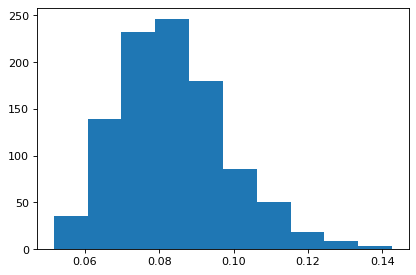

In [139]:
plt.hist(EFFECTS[:, 50])

(array([ 4.,  4., 21., 46., 51., 50., 22.,  8.,  5.,  2.]),
 array([-0.38713945, -0.30449129, -0.22184313, -0.13919496, -0.0565468 ,
         0.02610136,  0.10874952,  0.19139768,  0.27404584,  0.356694  ,
         0.43934216]),
 <a list of 10 Patch objects>)

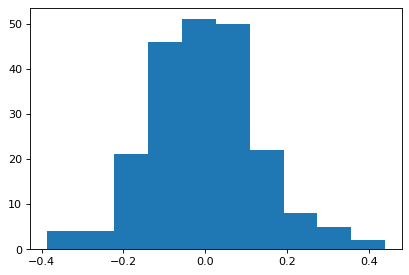

In [140]:
plt.hist(EFFECTS[1, :])

In [143]:
## Dist as same STR
EFFECTS2 = {}
for i, row in denovo_simulations.iterrows():
    weights = sim_denovo_row2gweight(row)
    sim_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat, weights, Method=1)
    for STR, row in sim_avgZ1.iterrows():
        #print(STR, EFFECT)
        if STR in EFFECTS2:
            EFFECTS2[STR].append(row["EFFECT"])
        else:
            EFFECTS2[STR] = [row["EFFECT"]]

In [145]:
#EFFECTS2[]
Meta_Zscore = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EFFECTS2[_str], effect)
    else:
        pvalue = GetPermutationP(EFFECTS2[_str], effect, gt = False)
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue
Meta_Zscore.to_csv('dat/bias/test2.csv')

In [193]:
dat = []
for k, v in EFFECTS2.items():
    dat.append([k, np.mean(v), np.var(v)])
null = pd.DataFrame(data=dat, columns=["STR", "MEAN", "VAR"])
null = null.sort_values("MEAN", ascending=False)
null.index = null["STR"].values

In [194]:
null

STR  \
Anterior_pretectal_nucleus                                Anterior_pretectal_nucleus   
Inferior_colliculus_central_nucleus              Inferior_colliculus_central_nucleus   
Inferior_colliculus_external_nucleus            Inferior_colliculus_external_nucleus   
Nucleus_of_the_optic_tract                                Nucleus_of_the_optic_tract   
Lateral_posterior_nucleus_of_the_thalamus  Lateral_posterior_nucleus_of_the_thalamus   
...                                                                              ...   
Retrochiasmatic_area                                            Retrochiasmatic_area   
Substantia_nigra_compact_part                          Substantia_nigra_compact_part   
Nucleus_raphe_magnus                                            Nucleus_raphe_magnus   
Tuberal_nucleus                                                      Tuberal_nucleus   
Diagonal_band_nucleus                                          Diagonal_band_nucleus   

                                               MEAN       VAR  
Anterior_pretectal_nucleus                 0.250317  0.009316  
Inferior_colliculus_central_nucleus        0.196168  0.008804  
Inferior_colliculus_external_nucleus       0.195882  0.009545  
Nucleus_of_the_optic_tract                 0.184289  0.008402  
Lateral_posterior_nucleus_of_the_thalamus  0.159468  0.008886  
...                                             ...       ...  
Retrochiasmatic_area                      -0.147751  0.006912  
Substantia_nigra_compact_part             -0.162306  0.007995  
Nucleus_raphe_magnus                      -0.168415  0.008699  
Tuberal_nucleus                           -0.168593  0.007232  
Diagonal_band_nucleus                     -0.177062  0.007150  

[213 rows x 3 columns]

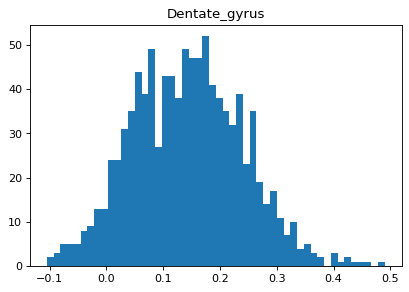

In [238]:
plt.hist(EFFECTS2["Dentate_gyrus"], bins=50)
plt.title("Dentate_gyrus")
plt.show()

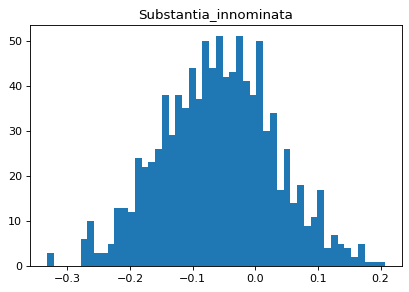

In [239]:
plt.hist(EFFECTS2["Substantia_innominata"], bins=50)
plt.title("Substantia_innominata")
plt.show()

In [195]:
STR2REG = STR2Region()
for i, row in null.iterrows():
    null.loc[i, "REG"] = STR2REG[row["STR"]]

In [196]:
null.head(5)

STR  \
Anterior_pretectal_nucleus                                Anterior_pretectal_nucleus   
Inferior_colliculus_central_nucleus              Inferior_colliculus_central_nucleus   
Inferior_colliculus_external_nucleus            Inferior_colliculus_external_nucleus   
Nucleus_of_the_optic_tract                                Nucleus_of_the_optic_tract   
Lateral_posterior_nucleus_of_the_thalamus  Lateral_posterior_nucleus_of_the_thalamus   

                                               MEAN       VAR       REG  
Anterior_pretectal_nucleus                 0.250317  0.009316  Midbrain  
Inferior_colliculus_central_nucleus        0.196168  0.008804  Midbrain  
Inferior_colliculus_external_nucleus       0.195882  0.009545  Midbrain  
Nucleus_of_the_optic_tract                 0.184289  0.008402  Midbrain  
Lateral_posterior_nucleus_of_the_thalamus  0.159468  0.008886  Thalamus

In [197]:
REGs = list(set(null["REG"].values))

In [227]:
dat = []
for reg in REGs:
    dat.append([reg, np.mean(null[null["REG"]==reg]["MEAN"].values)])
torank = pd.DataFrame(data=dat, columns=["REG", "MEAN"])
torank = torank.sort_values("MEAN")
torank.head(2)
REGs = torank["REG"].values

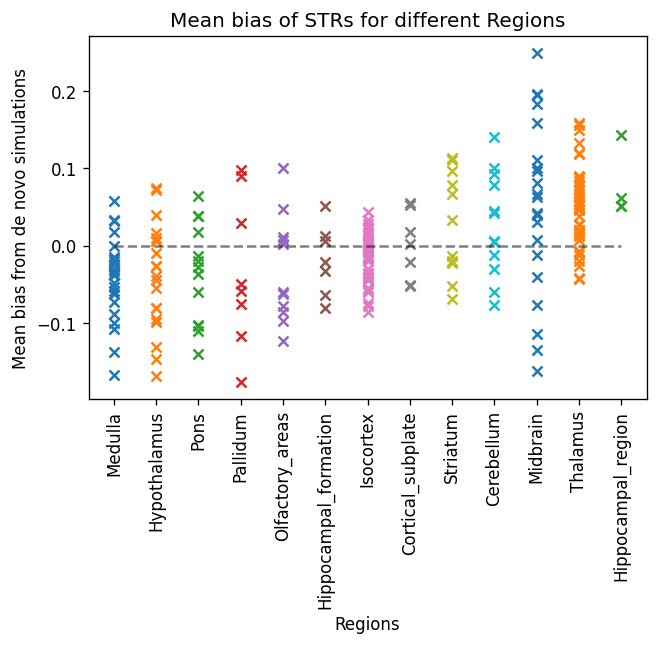

In [228]:
dat = []
x_ = -1
fig, ax = plt.subplots(dpi=120)
for reg in REGs:
    x_ += 1
    tmp = null[null["REG"]==reg]
    ax.scatter([x_]*tmp.shape[0], tmp["MEAN"].values, marker='x')
ax.hlines(xmin = 0, xmax = 12, y=0, linestyles='dashed', alpha=0.5)
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(REGs, rotation='vertical')
ax.set_title("Mean bias of STRs for different Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Mean bias from de novo simulations")
plt.show()

In [240]:
mean_var = null["VAR"].mean()

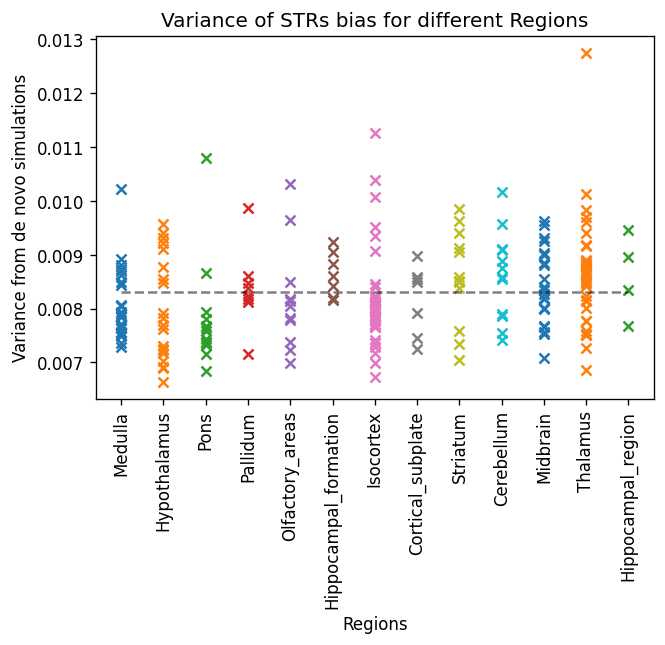

In [242]:
dat = []
x_ = -1
fig, ax = plt.subplots(dpi=120)
for reg in REGs:
    x_ += 1
    tmp = null[null["REG"]==reg]
    ax.scatter([x_]*tmp.shape[0], tmp["VAR"].values, marker='x')
ax.hlines(xmin = 0, xmax = 12, y=mean_var, linestyles='dashed', alpha=0.5)
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(REGs, rotation='vertical')
ax.set_title("Variance of STRs bias for different Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Variance from de novo simulations")
plt.show()

In [201]:
Meta_Zscore = pd.read_csv("dat/bias/Agg.AvgZ.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EFFECTS2[_str], effect)
    else:
        pvalue = GetPermutationP(EFFECTS2[_str], effect, gt = False)
    new_effect = effect - null.loc[_str, "MEAN"]
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue
    Meta_Zscore.loc[_str, "EFFECT2"] = new_effect
Meta_Zscore.to_csv('dat/bias/test3.csv')

In [ ]:
## Qunatils checking

In [205]:
ExpZscoreMat.head(2)

Anterior_amygdalar_area  Anterior_cingulate_area_dorsal_part  \
ROW                                                                 
1                   0.160640                            -0.539153   
2                  -0.476558                            -0.559858   

     Anterior_cingulate_area_ventral_part  Nucleus_accumbens  \
ROW                                                            
1                               -0.504043          -0.761513   
2                               -0.517535          -0.524070   

     Anterodorsal_nucleus  Anterior_hypothalamic_nucleus  \
ROW                                                        
1               -0.693056                       1.644456   
2                0.155116                      -0.414605   

     Agranular_insular_area_dorsal_part  \
ROW                                       
1                             -0.925718   
2                             -0.132720   

     Agranular_insular_area_posterior_part  \
ROW                                          
1                                      NaN   
2                                -0.366087   

     Agranular_insular_area_ventral_part  Nucleus_ambiguus  ...  \
ROW                                                         ...   
1                              -0.445816         -0.491676  ...   
2                              -0.228981         -0.431621  ...   

     Primary_visual_area  Posterolateral_visual_area  \
ROW                                                    
1              -0.826146                    1.096054   
2              -0.477847                   -0.507564   

     posteromedial_visual_area  Ventral_medial_nucleus_of_the_thalamus  \
ROW                                                                      
1                    -1.042356                               -0.149321   
2                    -0.227819                               -0.304092   

     Ventromedial_hypothalamic_nucleus  \
ROW                                      
1                             1.309056   
2                            -0.342912   

     Ventral_posterolateral_nucleus_of_the_thalamus  \
ROW                                                   
1                                         -0.090982   
2                                         -0.505963   

     Ventral_posteromedial_nucleus_of_the_thalamus  \
ROW                                                  
1                                         0.224140   
2                                        -0.469515   

     Ventral_posteromedial_nucleus_of_the_thalamus_parvicellular_part  \
ROW                                                                     
1                                            -0.079631                  
2                                            -0.360610                  

     Ventral_tegmental_area  Hypoglossal_nucleus  
ROW                                               
1                  1.733742             0.713978  
2                 -0.054245             1.149715  

[2 rows x 213 columns]

In [ ]:
ExpZscoreMat

In [219]:
def get_percentile(STR, MAT = ExpZscoreMat, P=[10, 50, 90]):
    values = MAT[STR].values
    values = [x for x in values if x==x]
    res = []
    for p in P:
        res.append(np.percentile(values, q=p))
    return res

In [220]:
print(get_percentile("Anterior_amygdalar_area"))
print(get_percentile("Anterior_cingulate_area_dorsal_part"))
print(get_percentile("Anterior_cingulate_area_ventral_part"))
print(get_percentile("Ventral_tegmental_area"))

[-1.0036701566616328, -0.188189282385728, 1.2515600583166464]
[-1.0036701565866828, -0.18818928298236598, 1.2515600524549726]
[-1.0036702236757309, -0.18818928405823449, 1.251565298976829]
[-1.0036701846273999, -0.18818834763392, 1.2515622453055562]


In [246]:
denovo_simulations.head(2)

1    2 131076   12   13   14   15   16   18 163859  ... 196513  \
index                                                        ...          
0      0,0  0,1    0,0  0,0  0,0  0,0  0,0  0,0  0,1    1,0  ...    0,0   
1      0,0  0,0    0,0  0,0  0,0  0,0  0,0  1,0  0,1    0,0  ...    0,0   

      196527 196528 196541 163782 163786 6503 131034 327657 201895  
index                                                               
0        0,0    0,0    0,0    0,0    0,0  0,0    0,0    0,0    0,0  
1        0,0    0,0    0,0    0,0    0,0  0,0    0,1    0,0    0,0  

[2 rows x 13752 columns]

### P value for expression level

In [265]:
## Construct expression match matrix
#denovo_simulations.head(2)
dat = []
_dir = "dat/Match_Volume_W/"
_index = np.empty(0)
no_g = []
for g in denovo_simulations.columns.values:
    try:
        tmp = loadgenelist(_dir + str(g) + ".txt.gz")
    except:
        no_g.append(g)
    dat.append(tmp)
    _index = np.append(_index, g)
Sim_Denovo_Matching = pd.DataFrame(data=dat, index=_index)

In [266]:
Sim_Denovo_Matching.head(2)

0       1       2       3       4     5       6       7       8    \
1  23581  162605  152687    9245  131540   915  130162  285172  219432   
2  54971    2297    1842  117145   51360  1293   54881   56927   84725   

      9    ...   990     991   992     993     994    995   996    997    998  \
1  254013  ...  9702  389336  6557  167555  126282    368  5330   8406  79589   
2    3290  ...  2651    4739  5317  146852    3655  83894  6780  92002  54457   

      999  
1  130589  
2    3589  

[2 rows x 1000 columns]

In [253]:
print(no_g)

['100499483', '100996939', '100505591', '100505993', '100506049', '100506564', '100506581', '100506658', '100506736', '100310846', '100288797', '101928601']


In [259]:
Sim_Denovo_Matching.index

Index(['1', '2', '131076', '12', '13', '14', '15', '16', '18', '163859',
       ...
       '196513', '196527', '196528', '196541', '163782', '163786', '6503',
       '131034', '327657', '201895'],
      dtype='object', length=13752)

In [268]:
Sim_Denovo_Matching.loc['54971', :]

0       64801
1       27131
2       85441
3       92002
4        5449
        ...  
995      5978
996     79134
997     25855
998    253714
999     84725
Name: 54971, Length: 1000, dtype: int64

In [ ]:
## Dist as same STR
EFFECTS2 = {}
for i, row in denovo_simulations.iterrows():
    weights = sim_denovo_row2gweight(row)
    
    #sim_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat, weights, Method=1)
    #for STR, row in sim_avgZ1.iterrows():
        #print(STR, EFFECT)
    #    if STR in EFFECTS2:
    #        EFFECTS2[STR].append(row["EFFECT"])
    #    else:
    #        EFFECTS2[STR] = [row["EFFECT"]]

In [269]:
DIR = "/Users/jiayao/Work/ASD_Circuits/src/dat/bias/DNV_SM_ExpLevel/"
EXP_LEVEL_EFFECT = {}
for i in range(1000):
    tmp_df = pd.read_csv("{}/dnv_sm.{}.csv".format(DIR, i), index_col="STR")
    for STR, row in tmp_df.iterrows():
        #print(STR, EFFECT)
        if STR in EXP_LEVEL_EFFECT:
            EXP_LEVEL_EFFECT[STR].append(row["EFFECT"])
        else:
            EXP_LEVEL_EFFECT[STR] = [row["EFFECT"]]

In [271]:
dat = []
for k, v in EXP_LEVEL_EFFECT.items():
    dat.append([k, np.mean(v), np.var(v)])
null = pd.DataFrame(data=dat, columns=["STR", "MEAN", "VAR"])
null = null.sort_values("MEAN", ascending=False)
null.index = null["STR"].values

In [272]:
STR2REG = STR2Region()
for i, row in null.iterrows():
    null.loc[i, "REG"] = STR2REG[row["STR"]]
REGs = list(set(null["REG"].values))  
dat = []
for reg in REGs:
    dat.append([reg, np.mean(null[null["REG"]==reg]["MEAN"].values)])
torank = pd.DataFrame(data=dat, columns=["REG", "MEAN"])
torank = torank.sort_values("MEAN")
torank.head(2)
REGs = torank["REG"].values

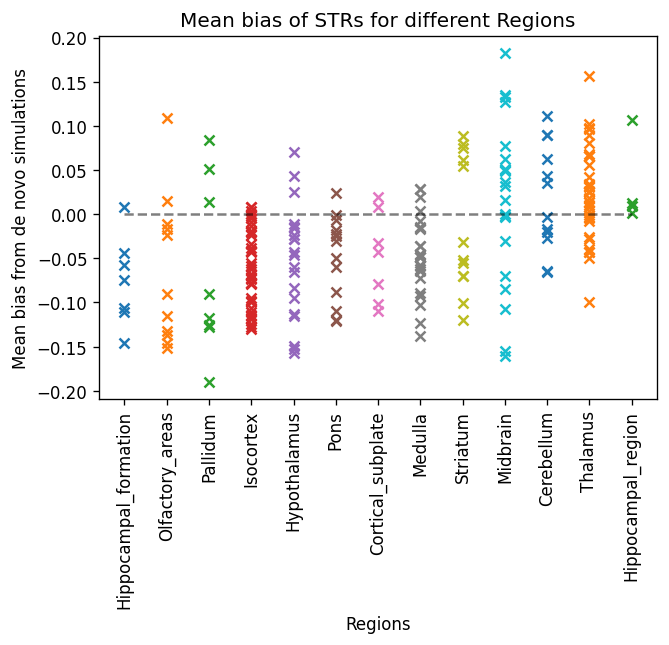

In [273]:
dat = []
x_ = -1
fig, ax = plt.subplots(dpi=120)
for reg in REGs:
    x_ += 1
    tmp = null[null["REG"]==reg]
    ax.scatter([x_]*tmp.shape[0], tmp["MEAN"].values, marker='x')
ax.hlines(xmin = 0, xmax = 12, y=0, linestyles='dashed', alpha=0.5)
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(REGs, rotation='vertical')
ax.set_title("Mean bias of STRs for different Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Mean bias from de novo simulations")
plt.show()

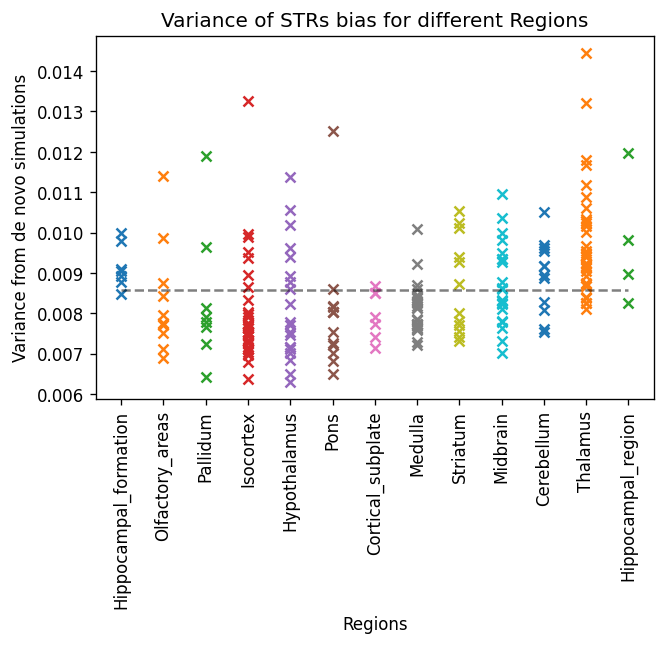

In [274]:
mean_var = null["VAR"].mean()
dat = []
x_ = -1
fig, ax = plt.subplots(dpi=120)
for reg in REGs:
    x_ += 1
    tmp = null[null["REG"]==reg]
    ax.scatter([x_]*tmp.shape[0], tmp["VAR"].values, marker='x')
ax.hlines(xmin = 0, xmax = 12, y=mean_var, linestyles='dashed', alpha=0.5)
ax.set_xticks(np.arange(0, 13, 1.0))
ax.set_xticklabels(REGs, rotation='vertical')
ax.set_title("Variance of STRs bias for different Regions")
ax.set_xlabel("Regions")
ax.set_ylabel("Variance from de novo simulations")
plt.show()

In [276]:
Meta_Zscore = pd.read_csv("dat/bias/Agg.explevel.Mutcount.bias.csv", index_col = "STR")
for i,( _str, row )in enumerate(Meta_Zscore.iterrows()):
    effect = row["EFFECT"]
    if effect > 0:
        pvalue = GetPermutationP(EXP_LEVEL_EFFECT[_str], effect)
    else:
        pvalue = GetPermutationP(EXP_LEVEL_EFFECT[_str], effect, gt = False)
    new_effect = effect - null.loc[_str, "MEAN"]
    Meta_Zscore.loc[_str, "Pvalue"] = pvalue
    Meta_Zscore.loc[_str, "EFFECT2"] = new_effect
Meta_Zscore.to_csv('dat/bias/test4.csv')

# Compare 3 different method for sepcificity bias

In [2]:
Aggregate = pd.read_csv("../dat/genes/asd/DenovoWEST_TADA.txt", delimiter="\t")
Aggregate['pDenovoWEST'] = pd.to_numeric(Aggregate["pDenovoWEST"], errors='coerce')
Agg_gene2None, Agg_gene2MutN = Aggregate_Gene_Weights(Aggregate, out = "dat/bias2/meta.gene.weights.csv")
Agg_match_df = pd.read_csv("dat/matching/asd_agg_exp_matches_1000.new.csv", index_col="GENE")
print(len(Agg_gene2MutN))

101


In [39]:
Agg_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_gene2MutN, Method=1,
                                              csv_fil = "dat/bias3/Agg.AvgZ1.Mutcount.bias.csv")

41


In [12]:
Agg_avgZ2 = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_gene2MutN, Method=2, Match_DF=Agg_match_df, 
                                              csv_fil = "dat/bias3/Agg.AvgZ2.Mutcount.bias.csv")

39


In [15]:
Agg_avgZ3 = AvgSTRZ_Weighted(ExpZscoreMat2, Agg_gene2MutN, Method=3, Match_DF=Agg_match_df, 
                                              csv_fil = "dat/bias3/Agg.AvgZ3.Mutcount.bias.csv")

38


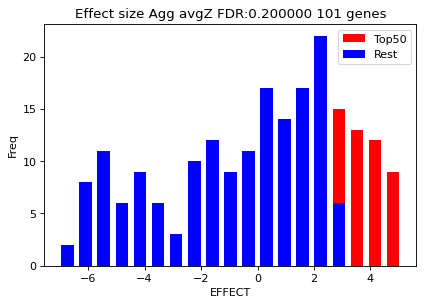

In [40]:
PlotEffectDist(Agg_avgZ3, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

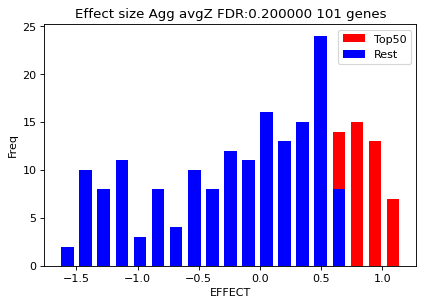

In [20]:
PlotEffectDist(Agg_avgZ2, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

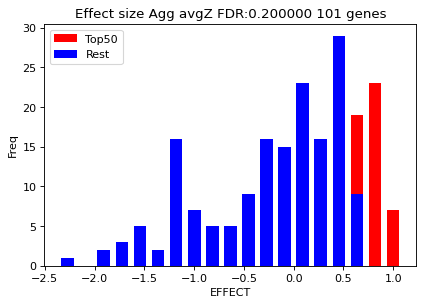

In [21]:
PlotEffectDist(Agg_avgZ1, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

In [17]:
RD_Agg_expl_RD = RegionDistributions(Agg_avgZ3.set_index("STR"), show=True)

Midbrain 	 1 	 Anterior_pretectal_nucleus
Thalamus 	 5 	 Lateral_posterior_nucleus_of_the_thalamus; Parafascicular_nucleus; Nucleus_of_reuniens; Rhomboid_nucleus; Mediodorsal_nucleus_of_thalamus
Isocortex 	 22 	 Prelimbic_area; Orbital_area_lateral_part; Orbital_area_ventrolateral_part; Infralimbic_area; Primary_somatosensory_area_lower_limb; Primary_visual_area; Anterior_cingulate_area_dorsal_part; Anteromedial_visual_area; Primary_motor_area; Retrosplenial_area_lateral_agranular_part; Agranular_insular_area_ventral_part; Secondary_motor_area; Gustatory_areas; Visceral_area; Lateral_visual_area; Dorsal_auditory_area; Posterior_parietal_association_areas; Agranular_insular_area_posterior_part; Primary_somatosensory_area_trunk; Anterior_cingulate_area_ventral_part; Orbital_area_medial_part; Posterolateral_visual_area
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum
Olfactory_areas 	 4 	 Anterior_olfactory_nucleus; Dorsal_peduncular_area; Accessory

In [18]:
RD_Agg_expl_RD = RegionDistributions(Agg_avgZ2.set_index("STR"), show=True)

Midbrain 	 1 	 Anterior_pretectal_nucleus
Thalamus 	 6 	 Lateral_posterior_nucleus_of_the_thalamus; Parafascicular_nucleus; Nucleus_of_reuniens; Rhomboid_nucleus; Submedial_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus
Isocortex 	 21 	 Orbital_area_lateral_part; Prelimbic_area; Orbital_area_ventrolateral_part; Infralimbic_area; Primary_somatosensory_area_lower_limb; Primary_visual_area; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Retrosplenial_area_lateral_agranular_part; Primary_motor_area; Secondary_motor_area; Gustatory_areas; Visceral_area; Agranular_insular_area_ventral_part; Dorsal_auditory_area; Orbital_area_medial_part; Lateral_visual_area; Primary_somatosensory_area_trunk; Posterior_parietal_association_areas; Agranular_insular_area_posterior_part; Anterior_cingulate_area_ventral_part
Hippocampal_formation 	 4 	 Subiculum_ventral_part; Subiculum_dorsal_part; Parasubiculum; Presubiculum
Olfactory_areas 	 3 	 Anterior_olfactory_nucleus; Dorsal_pedun

In [19]:
RD_Agg_expl_RD = RegionDistributions(Agg_avgZ1.set_index("STR"), show=True)

Midbrain 	 1 	 Anterior_pretectal_nucleus
Thalamus 	 8 	 Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus; Parafascicular_nucleus; Nucleus_of_reuniens; Intermediodorsal_nucleus_of_the_thalamus; Paraventricular_nucleus_of_the_thalamus; Mediodorsal_nucleus_of_thalamus; Submedial_nucleus_of_the_thalamus
Isocortex 	 22 	 Prelimbic_area; Orbital_area_lateral_part; Dorsal_auditory_area; Orbital_area_ventrolateral_part; Infralimbic_area; Primary_visual_area; Primary_somatosensory_area_lower_limb; Anteromedial_visual_area; Anterior_cingulate_area_dorsal_part; Agranular_insular_area_posterior_part; Retrosplenial_area_lateral_agranular_part; Visceral_area; Secondary_motor_area; Orbital_area_medial_part; Primary_motor_area; Lateral_visual_area; Posterolateral_visual_area; Agranular_insular_area_ventral_part; Gustatory_areas; Posterior_parietal_association_areas; Primary_somatosensory_area_trunk; Anterior_cingulate_area_ventral_part
Hippocampal_formation 	 3 	 Subiculum_ventral_part; Su

# For Method 3, Does it able to normlize gene set size?

In [23]:
ssc_all = pd.read_excel("/Users/jiayao/Work/ASD_Circuits/dat/genes/Supplementary_Table_7.xlsx")
ssc_sib = ssc_all[(ssc_all["dnv_LGDs_sib"]!=0) | (ssc_all["dnv_missense_sib"]!=0)]

In [24]:
ssc_sib.shape

(1215, 29)

In [25]:
tmp = ssc_sib.sample(n=101)

In [26]:
tmp.shape

(101, 29)

In [32]:
def sibling_gene_weight(df):
    gene2MutN = {}
    for i, row in df.iterrows():
        try:
            g = GeneSymbol2Entrez[row["gene"]]
            gene2MutN[g] = row["dnv_LGDs_sib"]*0.375 + (row["dnv_missense_sib"]) * 0.145
        except:
            continue
    return gene2MutN

In [41]:
tmp = ssc_sib.sample(n=101)
Sib_sample101 = sibling_gene_weight(tmp)
print(len(Sib_sample101))

94


In [42]:
Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=1,
                                              csv_fil = "dat/bias3/Sib.AvgZ1.Mutcount.bias.csv")

35


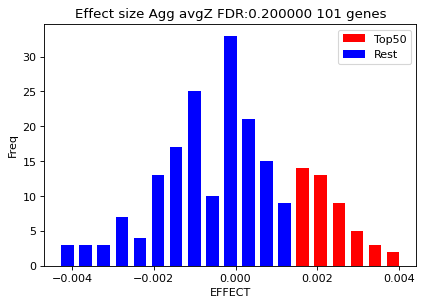

In [43]:
PlotEffectDist(Sib_avgZ1, title="Effect size Agg avgZ FDR:%f %d genes"%(0.2, 101))

In [48]:
for i in range(10):
    tmp = ssc_sib.sample(n=101)
    Sib_sample101 = sibling_gene_weight(tmp)
    Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=1)
    top50_bs = Sib_avgZ1.head(50)["EFFECT"].values
    print(np.mean(top50_bs), np.var(top50_bs))

0.0019389413868474712 5.378630752479766e-07
0.00212888363670234 1.7775576724506274e-06
0.0016110278965608001 1.3050112890064857e-06
0.0019358141239947896 5.760567288389296e-07
0.0022852619988945146 7.708278715898236e-07
0.0031768258531090377 2.2397084615744967e-06
0.0023976437120662992 7.834306513733399e-07
0.002349322249294572 1.029242751347744e-06
0.0020237881053463396 2.221745386863179e-06
0.0019175731271255324 5.128107621677241e-07


In [49]:
for i in range(10):
    tmp = ssc_sib.sample(n=51)
    Sib_sample101 = sibling_gene_weight(tmp)
    Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=1)
    top50_bs = Sib_avgZ1.head(50)["EFFECT"].values
    print(np.mean(top50_bs), np.var(top50_bs))

0.0056178484525570005 2.7923883679755892e-06
0.0063490141009708775 6.71122461813859e-06
0.006272680032825859 7.2703626914502964e-06
0.004640283704860911 9.524726181487976e-06
0.007033120044551493 3.6697212756592134e-05
0.0053330014479219855 4.446320349635775e-06
0.004881409060390986 3.2799961958770596e-06
0.008129327437749478 2.2443012497996824e-05
0.005829531961867925 7.041011879232908e-06
0.006899409318098098 1.1198934525975897e-05


In [50]:
for i in range(10):
    tmp = ssc_sib.sample(n=200)
    Sib_sample101 = sibling_gene_weight(tmp)
    Sib_avgZ1 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=1)
    top50_bs = Sib_avgZ1.head(50)["EFFECT"].values
    print(np.mean(top50_bs), np.var(top50_bs))

0.001100446505943761 2.988754348972949e-07
0.0011642074229136932 7.341448714940769e-07
0.0010108115411336094 4.5438772774939387e-07
0.0007369056751881707 2.392685044830714e-07
0.0007036137265139063 5.696060924448429e-08
0.00099602873182754 3.12551865580685e-07
0.0008208283876010277 2.821142591447742e-07
0.0006866171908992538 1.9505664913639837e-07
0.0010822239264682272 1.9859062228758234e-07
0.0008399816450629278 1.6045526842913665e-07


In [ ]:
print("hj")

In [56]:
Sib_match = Agg_match_df = pd.read_csv("dat/matching/asd_sib_exp_matches_1000.csv", index_col="GENE")

In [58]:
tmp = ssc_sib.sample(n=51)
Sib_sample51 = sibling_gene_weight(tmp)
Sib_avgZ3_51 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample51, Method=3, Match_DF=Sib_match)
top50_bs = Sib_avgZ3_51.head(50)["EFFECT"].values
print(np.mean(top50_bs), np.var(top50_bs))

230.46532803896204 4366.858251996743


In [59]:
tmp = ssc_sib.sample(n=101)
Sib_sample101 = sibling_gene_weight(tmp)
Sib_avgZ3_101 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample101, Method=3, Match_DF=Sib_match)
top50_bs = Sib_avgZ3_101.head(50)["EFFECT"].values
print(np.mean(top50_bs), np.var(top50_bs))

47.95358833527919 498.3731183045462


In [60]:
tmp = ssc_sib.sample(n=201)
Sib_sample201 = sibling_gene_weight(tmp)
Sib_avgZ3_201 = AvgSTRZ_Weighted(ExpZscoreMat2, Sib_sample201, Method=3, Match_DF=Sib_match)
top50_bs = Sib_avgZ3_201.head(50)["EFFECT"].values
print(np.mean(top50_bs), np.var(top50_bs))

24.469691297297096 160.61366363201324
